### Imports

In [1]:
#!pip install pypdb
import requests
import os
import string
from collections import defaultdict, OrderedDict
from collections import Counter
import re
import shutil
import statistics
from datetime import date
import logging
#import hail as hl
import glob
import time
import pytrimal
# Import from installed package
#from pypdb.clients.pdb.pdb_client import *
import dask.dataframe as dd
import json
import pandas as pd
#import plotly as px
from Bio.Seq import Seq
from Bio import SeqIO, Align, PDB, Seq, AlignIO
from Bio.PDB import PDBParser, PDBIO, Select, MMCIFParser, Structure, Chain, Atom, Superimposer
from Bio.PDB import Model as Bio_Model
from Bio.PDB import Chain as Bio_chain
from Bio.SeqIO import PirIO
from Bio.SeqRecord import SeqRecord
from Bio.Align import substitution_matrices
#from Bio import pairwise2
from io import StringIO
from modeller import *
from modeller.automodel import *
from modeller.parallel import job, local_slave
import matplotlib.pyplot as plt
import matplotlib.style as style
import logging
#logging.basicConfig(level=logging.DEBUG)
import subprocess
import shlex
from subprocess import PIPE, run
import numpy as np
import math
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, wait
from functools import partial
from bs4 import BeautifulSoup  #required later to download SIFT files.
import atomium
from itertools import compress
from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.gridspec as gridspe
import plotly.express as px
import plotly.io as pio
from bravado.client import SwaggerClient
from pycanal import Canal
#import hdbscan
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pathlib import Path
import concurrent.futures
import threading
from threading import Lock
from concurrent.futures import ProcessPoolExecutor, as_completed
from packman import molecule
from packman.apps import predict_hinge

from sklearn.cluster import OPTICS, cluster_optics_dbscan

#logging.getLogger("requests").setLevel(logging.WARNING)


# Input Conversion Class

In [3]:
class UserInputPreprocessor:
    """
    This class acts as an entry point for searches through GeneNames or UniprotIDs. 
    You can try both GeneName or UniprotID to fetch all homologs of a given species but the UniprotID is more reliable!
    First you can fetch the UniprotID or the GeneName and then you call SetupNewEnv. This first step can be skipped if you already know your Uniprot target.
    In that case you can directly call SetupNewEnv(uniprot_id="YourID"). After setting up an environment, you can use different DBs to query against. 
    Default is currently Cosmic DB which only contains Human queries but this can be easily extended in the future.
    For retrieving queries you simply call QueryAgainstDB(query="YourUniprotID") which you can fetch through the helper function GeneToUniprot if you are uncertain about it.
    The return of QueryAgainstDB is a pandas.DataFrame that contains all your pdbs and their associated sequence identities for your query.
    This output is the Input for the next class: DownloadPipeline
    """
    def __init__(self, db_dir, cutoff=None, db=None, work_dir=None):
        self.work_dir = work_dir
        #self.script_dir = script_dir
        self.db_dir = db_dir
        self.cutoff = cutoff
        self.uniprot_id = None
        self.gene_name = None
        self.db = db
        self.hits = None


    def UniprotToGene(self, uniprot_id):
        # we fetch the id which is the gene name.
        fields = "id"
    
        URL = f"https://rest.uniprot.org/uniprotkb/search?format=tsv&fields={fields}&query={uniprot_id}"
        resp = self._get_url(URL)
        resp = resp.text
        resp = resp.split("\n")
        self.gene_name = resp[1] # list because we need compatibility with cases where users search for genetouniprot which can get multiple uniprots.
        self.uniprot_id = uniprot_id
        return self.gene_name

    def GeneToUniprot(self, gene_name):
        # we fetch the gene which is the accession
        fields = "accession"

        URL = f"https://rest.uniprot.org/uniprotkb/search?format=tsv&fields={fields}&query=gene:{gene_name}"
        
        resp = self._get_url(URL)
        resp = resp.text
        resp_lines = resp.split("\n")
        # If there are multiple UniProt IDs for the gene, they will be on separate lines
        uniprot_ids = resp_lines[1:]  # Skip the header
        # There can be multiple Uniprot IDs per gene so we return all of them and the user selects which one he wants to query against.
        self.uniprot_id = [id for id in uniprot_ids if id][0]
        return self.uniprot_id # for convenience the first hit.

    def QueryTest(self, query, prefered_db="Cosmic_Query_DB", show_options=False):

        extensions = [".csv", ".tsv", ".m8", ".db"] #these will be accepted as hits. 
        pattern = os.path.join(self.db_dir, "*DB.csv")

        dict_with_dbs = {
        os.path.splitext(os.path.basename(f))[0]: os.path.join(self.db_dir, f)
        for f in os.listdir(self.db_dir)
        if os.path.isfile(os.path.join(self.db_dir, f)) and any(f.endswith(ext) for ext in extensions)
        }
        
        if show_options:
            print(dict_with_dbs)
        
        df_all = pd.read_csv(dict_with_dbs[prefered_db], sep=",",index_col=0)
        
        return df_all

    
    def QueryAgainstDb(self, query, prefered_db="Cosmic_Query_DB", show_options=False):


        # if we have a uniprot id lets take it
        if self.uniprot_id:
            query = self.uniprot_id
            
        extensions = [".csv", ".tsv", ".m8", ".db"] #these will be accepted as hits. 
        pattern = os.path.join(self.db_dir, "*DB.csv")

        dict_with_dbs = {
        os.path.splitext(os.path.basename(f))[0]: os.path.join(self.db_dir, f)
        for f in os.listdir(self.db_dir)
        if os.path.isfile(os.path.join(self.db_dir, f)) and any(f.endswith(ext) for ext in extensions)
        }
        
        if show_options:
            print(dict_with_dbs)
        
        df_all = pd.read_csv(dict_with_dbs[prefered_db], sep=",",index_col=0)

        #print(df_all.head())
        mask = df_all["Query_id"] == query # mask to filter true 
        df_queries_hits = df_all[mask]
        self.hits = df_queries_hits
        return df_queries_hits


    def SetupNewEnv(self, work_dir=None, uniprot_id=None):

        #if user wants another work dir, he can specify. otherwise we use default work dir 
        if not work_dir:
            if self.work_dir:
                work_dir = self.work_dir
            else:
                print(f"We need a directory environment to set up a new directory for the new Query.\nPlease either initialize the Class with work_dir='/your/work/dir' or call this function with work_dir='your/work/dir'")
                return
                
        dir_name = None  # Initialize dir_name
        # If a gene name is set, use it
        if uniprot_id:
            dir_name = self.UniprotToGene(uniprot_id)
        # If a UniProt ID is provided, use it to get the gene name
        elif self.gene_name:
            dir_name = self.gene_name
        # If no gene name or UniProt ID is provided, try using the first UniProt ID from self.uniprot_ids
        elif self.uniprot_id:
            try:
                #this is the first uniprot found. 
                dir_name = self.UniprotToGene(self.uniprot_id)
                
            except Exception as e:
                print(f"Error fetching gene name from UniProt ID: {e}")
    
        # Proceed if dir_name was successfully determined
        if dir_name:
            dir_to_make = os.path.join(work_dir, dir_name)  # Use the passed work_dir parameter
            if not os.path.exists(dir_to_make):
                os.makedirs(dir_to_make)
                print(f"Directory '{dir_to_make}' was created.")
            else:
                print(f"Directory '{dir_to_make}' already exists.")
                return dir_to_make
        else:
            dir_to_make = None
            print("No directory name could be determined. Try first calling UniprotToGene() or GeneToUniprot()!")

        #we want the new dir as return
        return dir_to_make

    def fetch_uniprot_domains(self, uniprot_id, regex="(Domain|Chain)"):
    
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
        response = requests.get(url)
        response.raise_for_status()  # This will raise an exception for non-200 responses
        data = response.json()
    
        # Initialize a list to hold domain boundary information
        pattern = re.compile(r'(Domain|Chain)', re.IGNORECASE)  # chain is always the full length and domain might be a part of chain that is independent
    
        features_info = {}
        #print(data['features'])
        # Check if 'features' is in the response data
        for feature in data.get('features', []):
            if pattern.search(feature['type']):
                start = feature['location']['start']['value']
                end = feature['location']['end']['value']
                # Add the feature to the dictionary, initializing the list if necessary
                features_info.setdefault(feature['type'], []).append((start, end, feature.get('description', '')))
    
        self.features_info = features_info 
        return features_info

    
    #helper function to download
    def _get_url(self, url):
        try:
            response = requests.get(url) 
            if not response.ok:
                print(response.text)
        except:
            response.raise_for_status()
            #sys.exit()

        return response


# Download Class

In [4]:
class DownloadPipe:
    '''Class object containing the download function that will download all pdbs 
    which we need for downstream analysis of a particular uniprot ID'''

    def __init__(self, input_df, work_dir, script_dir, seq_id_cutoff=None, download_type="pdb", logging=True):
        self.work_dir = work_dir # Storage of seq identity useful later for temp selection.
        self.script_dir = script_dir #here we store all scripts
        self.seq_id_cutoff = seq_id_cutoff
        self.download_type = download_type # Download PDB or also mmCIF (currently only PDB)
        self.input_df = input_df
        self.pdbs_to_download = input_df.loc[:, "Target_id"]
        self.seq_id = input_df.loc[:, "Seq_identity"]
        # The bash script location which will download the pdbs. 
        self.download_script = os.path.join(script_dir, "batch_download_modified.sh") #modify for script location
        self.download_tmp = os.path.join(work_dir, "pdb_list.csv") # The location for the temporary file that is required for the download_script as input.
        self.log_dir = os.path.join(work_dir, "log_files")
        # The list of chains that will be used later to fetch correct structures.
        self.chain_seqid_dict = self._setup_download_list()
        self.temp_seqid_dict = {template: seq_id for template, seq_id in zip(self.pdbs_to_download, self.seq_id)}
        # We store also meta info as a json dict
        self.meta_dict = None
        #we store high resolution structures as a list if the user wants to separate based on resolution.
        self.high_resolution = None
        # set a flag that stops redownloading.
        self.already_downloaded = None
        # collect conservation
        self.conservation_df = None
        #filtered structures based on meta resolution
        self.filtered_structures = None
        #store shifts.
        self.shift_dict = None
        self.logging = logging # for report purpose.
            
    def paralellized_download(self):
        '''
        This function is going to call _download_files n times to parallelize download. 
        It is going to pass the function call itself **_download_file**,
        self.download_tmp (the location of the tmp file which is pdb_id comma separated), 
        p (an additional parameter specifying that 
        we want to download pdbs, and self.work_dir(the current work dir)
        '''

        self.already_downloaded = self._check_for_pdbs_present()
        # ThreadPoolExecutor
        print(f"{self.already_downloaded=}")
        if self.already_downloaded == False:
            print("we start downloading now:")

            # now for debugging.

            return 0
            
            with ThreadPoolExecutor() as executor:
                # Submit your tasks to the executor.
                futures_pdb = [executor.submit(self._download_files, self.download_tmp, 'p', self.work_dir)]
                # Optionally, you can use as_completed to wait for and retrieve completed results.
                for future in as_completed(futures_pdb):
                    result = future.result()
            self.already_downloaded = True
        else:
            print("we already have pdbs from the templates downloaded")
    
    def _setup_download_list(self):
        '''Helper function to setup the list of comma-separated pdb
        ids for the download_files function'''
        
        
        if not self.input_df.empty:
            pdbs = self.input_df.loc[:, "Target_id"]
            seq_ids = self.input_df.loc[:, "Seq_identity"]
        else:
            # we cant proceed
            return

        #initialize dict
        chain_seqid_dict = defaultdict(list)

        self.pdbs_to_download = [] # overwrite to set it blank for seq_id filtering.

        original_pdbs = len(set([x[0:4] for x in pdbs])) #for logging purpose. tells us how many pdbs originally were there before cutoff
        for pdb, seq_id in zip(pdbs, seq_ids):
            if float(seq_id) > float(self.seq_id_cutoff):
                pdb_4_digit_id = pdb[:4] # e.g 4CFR
                chain = pdb[-1] # e.g A
                chain_seqid_dict[pdb_4_digit_id].append((chain, seq_id)) #map chains and seq id to pdb id
                # We only want to download pdb files once. 
                # No reason to download a PDB-file 4 times just because we need chain [A, B, C, D]
                self.pdbs_to_download.append(pdb_4_digit_id) # we store it for a later check 
                
        unique_pdbs = chain_seqid_dict.keys() # Keys : PDB-IDs, Vals: Chains, seq_id
        # Create download_files input list
        
        if unique_pdbs:
            with open(self.download_tmp, "w") as pdb_tar:
                pdb_tar.write(",".join(unique_pdbs))
            
            #return dict {key: pdb_id = [(chain, seq_id)]}
            print(f"Before applying cutoff: {original_pdbs} Structures\nAfter applying cutoff: {len(unique_pdbs)} Structures")
            return chain_seqid_dict
        else:
            print(f"No structures available for cutoff {self.seq_id_cutoff}. Try lowering cutoff.")

    
    def _download_files(self, download_tmp, download_type, path)->list:
        """This helper function runs inside paralellized_download 
        and will be used to get the PDB files that we require for downstream analysis."""
        results = []
        # Input for subprocess
        bash_curl_cmd = f"{self.download_script} -f {download_tmp} -o {path} -{download_type}"
        # split into list 
        bash_curl_cmd_rdy = bash_curl_cmd.split()
        
        try:
            # Run subprocess
            result = run(bash_curl_cmd_rdy, stdout=PIPE, stderr=PIPE, universal_newlines=True)
            # Append result output to results
            results.append(result.stdout.split("\n")[:-1])  # Skip the last empty element
        except Exception as e:
            results.append(f"Error downloading: {e}")

        return results    

    def _check_for_pdbs_present(self):
        '''
        Could be good to improve so that if we miss SOME structures we fetch them as well and download ONLY those.
        For those structures we also need seqid per chain and then also update the seqid_chain dict for the whole directory after
        successful download.
        Currently we only check if pdbs are present and if yes we dont download anything further.
        '''
        pdbs_to_retrieve = {f[:4] for f in os.listdir(self.work_dir) if f.endswith(".pdb")}  # Use a set for efficient lookups
        template_codes = {f[:4] for f in self.pdbs_to_download}  # Convert list to set for efficient intersection operation

        print(f"{pdbs_to_retrieve=}, {template_codes=}")
        # Check for any overlap between the two sets
        overlap = pdbs_to_retrieve.intersection(template_codes)
        
        print(f"This is overlap in the directory: {overlap}")
        # Return 1 if there is an overlap, else 0
        return True if overlap else False

    
    def retrieve_meta(self, dict_location=None, human_readable=True)->dict:
        '''
        We also want to store meta information about resolution etc.
        This function takes each pdb file and retrieves the following information:
        - Title
        - Keywords
        - PDBcode
        - Authors
        - Deposition date
        - Technique
        - Resolution
        - R_value : If crystallography else None
        - R_free : If crystallographe else None
        - Classification
        - Organism
        - Expression System
        - Number of amino acids in the asymmetric unit
        - Mass of amino acids in the asymmetric unit (Da)
        - Number of amino acids in the biological unit
        - Mass of amino acids in the biological unit (Da)
        '''
        
        json_file_path = os.path.join(self.log_dir, 'meta_dictionary.json')

        for path in [json_file_path, dict_location]: #check first the supposed location alternatively the user supplied location.
            if path and os.path.exists(path):
                try:
                    with open(path, 'r') as json_fh:
                        self.meta_dict = json.load(json_fh)
                except Exception as e:
                    print(f"Error reading {path}: {e}")
                
        #little helper function to deal with date data
        def _date_encoder(obj):
            if isinstance(obj, date):
                return obj.isoformat()  # Convert date to ISO format

        #grab all PDB files which contain the meta information.
        pdbs_to_retrieve = [f for f in os.listdir(self.work_dir) if f.endswith(".pdb")]
        #here we store info about ALL pdbs.
        meta_dictionary = dict()
        
        for pdbs in pdbs_to_retrieve:
            if len(pdbs) == 8: #lets exclude preprocessed pdbs that are longer or shorter.
                sub_dict = dict()
                pdb_code = pdbs[:4]
                try:
                    fullp = os.path.join(self.work_dir, pdbs)
                    pdb = atomium.open(fullp)
                    sub_dict["title"] = pdb.title
                    sub_dict["key_words"] = pdb.keywords
                    sub_dict["code"] = pdb.code
                    sub_dict["authors"] = pdb.authors
                    #sub_dict["deposition_date"] = pdb.deposition_date.isoformat()  #isoformat because it is a time object
                    sub_dict["technique"] = pdb.technique
                    sub_dict["resolution"] = pdb.resolution
                    sub_dict["r_val"] = pdb.rvalue
                    sub_dict["r_free"] = pdb.rfree
                    sub_dict["classification"] = pdb.classification
                    sub_dict["organism"] = pdb.source_organism
                    sub_dict["expression_system"] = pdb.expression_system
                    sub_dict['number_of_residues_asymmetric_unit'] = len(pdb.model.residues())
                    sub_dict['mass_dalton_asymetric_unit'] = f"{pdb.model.mass:.2f}" 
                    try:
                        assembly = pdb.generate_assembly(1) #build the biological assembly 
                        sub_dict['number_of_residues_biological_unit'] = len(assembly.residues())
                        sub_dict['mass_dalton_biological_unit'] = f"{assembly.mass:.2f}"
                    except Exception as e:
                        print(f"We could not build the assembly for: {pdb_code}")
    
                except Exception as e:
                    print(f"We had an error with file: {pdb_code}")
                # store meta info and return
                meta_dictionary[pdb_code] = sub_dict


        #lets store meta info as json dict
        self.meta_dict = meta_dictionary
        
        # Code block to store meta info as a txt file.
        self._save_meta_dict(self.meta_dict, human_readable=human_readable)


    def _save_meta_dict(self, meta_dictionary, human_readable=True):
        '''Helper function to store meta info as a txt file.'''
        #check if log file dir exists, else make it.
        
        if self.log_dir and not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        #lets store the dict in json to read it in for later useage.
        json_file_path = os.path.join(self.log_dir, 'meta_dictionary.json')
        #convert defaultdict to normal dict.
        
        with open(json_file_path, 'w') as json_fh:
            json.dump(meta_dictionary, json_fh, indent=4, default=str)  # Use default=str to handle non-serializable objects

    
    def conservation(self, uniprot_id):
        '''Gets 3 different types of Conservation:
        - Shannon conservation: 
        Shannon entropy. 
        Higher values indicate lower conservation and greater variability at the site.
        
        - Relative conservation:
        Kullback-Leibler divergence.
        Higher values indicate greater conservation and lower variability at the site.
        
        - Lockless conservation
        Evolutionary conservation parameter defined by Lockless and Ranganathan (1999). 
        Higher values indicate greater conservation and lower variability at the site.
        '''

        if self.log_dir and not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        
        mmseq_fasta_result = self._mmseq_multi_fasta(uniprot_id=uniprot_id, outdir=self.work_dir)
        #get 3 different conservation scores in a pandas df.
        conserv_df = self._get_conservation(path_to_msa=mmseq_fasta_result)
        self.conservation_df = conserv_df

        conserv_df.to_csv(f"{self.log_dir}/conservation_df.csv")
        
    def _mmseq_multi_fasta(self, uniprot_id:str, outdir:str, 
                      sensitivity=7, filter_msa=0,
                     query_id = 0.6):
        """
        uniprot_id: The unique uniprot identifier used to fetch the corresponding fasta file that will be used as a template for mmseq2
        outdir: location where result files will be stored.
        sensitivity: mmseq2 specific parameter that goes from 1-7. The higher the more sensitive the search.
        filter_msa = 0 default. if 1 hits are stricter.
        query_id = 0.6 [0, 1]  the higher the more identity with query is retrieved. 1 means ONLY the query hits while 0 means take everything possible.
        """

        #we blast with this fasta as query.
        trgt_fasta_seq = self._get_gene_fasta(uniprot_id)
        #Make outdir for all required files.
        #we need to write it out to file.
        with open(f"{self.work_dir}/{uniprot_id}_fasta.fa", "w") as fasta_out:
            fasta_out.write(f">{uniprot_id}\n")
            fasta_out.write(trgt_fasta_seq)

        #fetch pre downloaded database from a parent folder.
        msa_file = None
        new_location = None
        try:
            DB_storage_location = f"{work_dir}"
            #shutil.copy(previous_path, savepath)
            bash_curl_cmd = f"mmseqs createdb {self.work_dir}/{uniprot_id}_fasta.fa {DB_storage_location}/query_fastaDB" 
            bash_curl_cmd_rdy = bash_curl_cmd.split()
            #run first cmd which setups query database based on our input fasta file
            result_setup_query_db = run(bash_curl_cmd_rdy, stdout=PIPE, stderr=PIPE, 
                                 universal_newlines=True)
            bash_curl_cmd_2 = f"mmseqs search {DB_storage_location}/query_fastaDB {DB_storage_location}/swiss_DB {DB_storage_location}/result_DB {DB_storage_location}/tmp -s {sensitivity}"    
            bash_curl_cmd_rdy_2 = bash_curl_cmd_2.split()
            #run 2nd cmd which blasts against swiss_DB and generates the resultDB (i.e our hits that were found)
            result_setup_blast_db = run(bash_curl_cmd_rdy_2, stdout=PIPE, stderr=PIPE, 
                                 universal_newlines=True)
            #mmseqs convert2fasta DB_clu_rep DB_clu_rep.fasta
            bash_curl_cmd_5 = f"mmseqs result2msa {DB_storage_location}/query_fastaDB {DB_storage_location}/swiss_DB {DB_storage_location}/result_DB {DB_storage_location}/{uniprot_id}_out.fasta --msa-format-mode 3 --filter-msa {filter_msa} --qid {query_id}" 
            bash_curl_cmd_5_rdy = bash_curl_cmd_5.split()
            result_setup_msa_convert = run(bash_curl_cmd_5_rdy, stdout=PIPE, stderr=PIPE, 
                                 universal_newlines=True)
            #delete last line.. required.
            sed_cmd = f'sed -e 1,4d -e $d {DB_storage_location}/{uniprot_id}_out.fasta'        
            bash_curl_cmd_6_rdy = sed_cmd.split()
            #f"{DB_storage_location}/{uniprot_id}_new_out.fasta"
            with open(f"{DB_storage_location}/{uniprot_id}_new_out.fasta", "w") as new_fasta:
                result_truncation = run(bash_curl_cmd_6_rdy, stdout=new_fasta, stderr=PIPE, 
                                 universal_newlines=True)
            # Specify the path to your MSA file
            msa_file = f"{DB_storage_location}/{uniprot_id}_new_out.fasta"
            #transfer the meta file to another location and delete useless files.
            # we need to delete : all uniprot* files. 
            # all query*. All result* 
            new_location = f"{self.work_dir}/{uniprot_id}.fasta"
            shutil.copy(msa_file, new_location)
            #remove_files_and_dirs_msa(DB_storage_location, uniprot_id=uniprot_id)
            
        except Exception as error:
            print(error)
        #we want the path to msa_file for downstream analysis.
        return new_location

    def _get_gene_fasta(self, uniprot_id:str):
        '''
        Helper function to grab the sequence 
        based on the Uniprot ID
        '''
        fields = "sequence"
        URL = f"https://rest.uniprot.org/uniprotkb/search?format=fasta&fields={fields}&query={uniprot_id}"
        resp = self._get_url(URL)
        resp = resp.iter_lines(decode_unicode=True)
        seq = ""
        i = 0
        for lines in resp:
            if i > 0:
                seq += lines
            i += 1
        return seq

    def _get_conservation(self, path_to_msa:str):    
        '''
        Helper function to compute 3 different types of conservation.
        
        - Shannon conservation: 
        Shannon entropy. 
        Higher values indicate lower conservation and greater variability at the site.
        
        - Relative conservation:
        Kullback-Leibler divergence.
        Higher values indicate greater conservation and lower variability at the site.
        
        - Lockless conservation
        Evolutionary conservation parameter defined by Lockless and Ranganathan (1999). 
        Higher values indicate greater conservation and lower variability at the site.
        '''
        canal = Canal(fastafile=path_to_msa, #Multiple sequence alignment (MSA) of homologous sequences
          ref=0, #Position of reference sequence in MSA, use first sequence always
          startcount=0, # ALways 0 because our seqs are always from 1 - end
          verbose=False) # no verbosity 
    
        result_cons = canal.analysis(method="all")
        return result_cons

    def _get_url(self, url):
        '''Helper function that uses requests for Downloads.'''
        try:
            response = requests.get(url)  
            if not response.ok:
                print(response.text)
        except:
            response.raise_for_status()
            #sys.exit() 
        return response
    
    def setup_cutoff(self, cutoff=10, apply_filter=False):
        '''If we want to setup a resolution cutoff filter for further downstream analysis, 
        this function helps with it.'''
        # If there is no meta dict we cant proceed and filter based on resolution.
        if self.meta_dict:
            #here we store the pdb codes that we keep
            pdbs_to_keep = []
            #Now lets parse through the whole meta dict and fetch the cutoffs for structures.
            for _, single_pdbs in self.meta_dict.items():
                try:
                    if single_pdbs['resolution'] <= cutoff:
                        pdbs_to_keep.append(single_pdbs['code'].lower()) #normalize to lower in order to have uniform list members.   
                except:
                    # 'technique': 'SOLUTION NMR' check for that.
                    print(f"we allow for now {single_pdbs=} because no resolution! check if NMR")
                    pass

            
            self.filtered_structures = pdbs_to_keep
            #now if we directly want to apply the filter to remove files that dont match our criteria.
            if apply_filter:
                #check for union between files and kept structures.
                pdbs_to_retrieve = [f[:4] for f in os.listdir(self.work_dir) if f.endswith(".pdb")]
                #lets fetch the intersect between the 2 sets which corresponds to the pdbs we want to keep.
                common_pdb = set(pdbs_to_retrieve) & set(pdbs_to_keep) #intersection
                intersect_lst = list(common_pdb)
                self.filtered_structures = intersect_lst
                if self.chain_seqid_dict:
                    #now we need to update the chain_dict as well:
                    filtered_dict = {pdb: v for pdb, v in self.chain_seqid_dict.items() if pdb[:4] in self.filtered_structures}
                    self.filtered_structures = filtered_dict
                    
        else:
            print("We have no meta dict to implement a cutoff")
            #In this case we take all.
            print(f"{self.chain_seqid_dict=}")
            # this also needs to take into account the seq id to be useful.
            pdbs_to_retrieve = [f[:4] for f in os.listdir(self.work_dir) if f.endswith(".pdb") and len(f) == 8] #exclude non original files. Only store pdb + _ + chains.
            
            self.filtered_structures = pdbs_to_retrieve

    def parallel_shift_calculation(self):
        '''Here we compute the shift according to uniprot or authors
        in order to be in line with UNIPROT numbering which is crucial for later renumbering.'''
        
        pdbs_to_retrieve = [f[0:4] for f in os.listdir(self.work_dir) if f.endswith(".pdb")]  
        pdbs_to_retrieve = set(pdbs_to_retrieve) & set(x[:4] for x in self.oligodict.keys()) #here we check the first 4 which is pdb code
        link_path = "https://www.ebi.ac.uk/pdbe/api/mappings/uniprot"
        shift_dict = defaultdict()
        
        with ThreadPoolExecutor() as executor:
            calculate_shift_bound = partial(self._calculate_shift)
            tasks = ((link_path, pdb) for pdb in pdbs_to_retrieve)
            # Map the bound function to the arguments in parallel
            results = executor.map(calculate_shift_bound, tasks)
            for result in results:
                for keys, vals in result.items():
                    shift_dict[keys] = vals
                    
        self.shifts = shift_dict

    def _calculate_shift(self, args):
        '''
        Helper function to compute the shift.
        Args: link_path to UNIPROT page and the pdb path.
        '''
        link_path, pdb = args
        shift_dict = defaultdict()
        searchp = f"{link_path}/{pdb[0:4]}"
        resp = self._get_url(searchp)
        resp = resp.json()
        for pdb_id, pdb_info in resp.items():
            for uniprot_id, uniprot_info in pdb_info['UniProt'].items():
                for mapping in uniprot_info['mappings']:
                    chain_id = mapping['chain_id']
                    unp_start = mapping['unp_start']
                    unp_end = mapping['unp_end']
                    author_start = mapping['start']['author_residue_number']
                    author_end = mapping['end']['author_residue_number']
    
                    if author_start is None:
                        author_start = unp_start
                    if author_end is None:
                        author_end = unp_end
                    shift_start = unp_start - author_start
                    shift_end = unp_end - author_end
                    shift_dict[f"{pdb_id}_{chain_id}"] = shift_start 
                    
        self.shift_dict = shift_dict
        return shift_dict

    
    def parallel_renumbering(self):
        '''
        Helper function to do parallelized renumbering.
        If already renumbered, don't do it again.
        '''
        if self.renumbered:
            print("You already renumbered your structures based on shift.")
            return  # Exit the function early

        if not self.shifts:
            print("You first need to obtain shifts which will be used as reference in order to start renumbering.\nCall .parallel_shift_calculation() first.")
            return  # Exit the function if no shifts are available

        # At this point, we know renumbering has not been done and shifts are available
        relevant_files = self.chain_seq_dict.keys()
        with ProcessPoolExecutor() as executor:
            # Using partial to create a function with fixed parameters (shift_dict, path)
            renumber_structure_partial = partial(self._renumber_structure, shift_dict=self.shifts, path=self.work_dir)
            # Map the renumbering function to each relevant file in parallel
            executor.map(renumber_structure_partial, relevant_files)

        self.renumbered = True

    
    def _renumber_structure(self, files, shift_dict, path):
        '''Function that is going to apply pdb_shiftres_by_chain.py to each pdb file that is shifted.
        Will apply renumbering to ALL structures if you did not set a cutoff previously and applied filter. 
        If filter applied for resolution will only renumber those structures that are left after filtering.'''
        for keys, vals in shift_dict.items():
            #dont renumber if there is not shift
            if files == keys[0:4] and vals != str(0):
                chain = keys[-1]
                shift = int(vals)
                filepath = f"{self.work_dir}/{files}.pdb"
                # Should we really shift by shift + 1??? or just shift?
                bash_cmd = f"python {self.script_dir}/pdb_shiftres_by_chain.py {filepath} {shift} {chain}"
                bash_cmd_rdy = bash_cmd.split()
            
                with open(f"{filepath}_tmp", "w") as fh_tmp:
                    result = run(bash_cmd_rdy, stdout=fh_tmp, stderr=PIPE, universal_newlines=True)
                    # Now replace the original one with the temp file.
                    os.replace(f"{filepath}_tmp", filepath)

# PDBBUILDER class

In [5]:
class PDBBuilder:
    '''Class to build biological units from asymmetric units'''
    def __init__(self, work_dir, script_dir, structures, remove_intermediates=True, main_protein_sequence=None, logging=True):
        self.work_dir = work_dir
        #Here we store the structures that need to be built.
        self.structures = structures
        #script dir
        self.script_dir = script_dir
        #we store intermediate files per default.
        self.remove_intermediates = remove_intermediates
        #we set oligo to None but store later the oligodict
        self.oligodict = None
        # dict to store the potential ranges.
        self.range_dict = None
        # logging purpose
        self.log_dir = os.path.join(work_dir, "log_files")
        # enable logging.
        self.logging = logging
        #main_prot_seq
        self.main_protein_sequence = main_protein_sequence
        # result dict for established domains
        self.established_domain_dict = defaultdict(dict)
        # top templates found for each range
        self.top_templates = None
        self.assembled_structures = None

    def build_assembly(self):
        '''
        This function takes all pdbs in self.structures that were passed to class initialization:

        structure:
        self.structures -> dict
        keys: pdb_id_4_digit
        values: tuple (chain_id, seq_identity)

        example: {'5ltu': [('A', 0.96), ('B', 0.96)]}

        We rechain all pdbs in order to have uniformized chain labels for downstream processing.
        Then, we build biological assemblies based on the asymmetric unit deposition and caputure the oligomeric status.
        We return then an updated self.oligodict that has the following structure:

        key: PDB_ID_CHAIN(s)
        values: tuple(chain, seq_id)
        example: {'5ltu_AB.pdb': [('A', 0.96), ('B', 0.96)]}
        This corresponds to the fully assembled structure.
        
        '''
        # These files need to be opened, rechained and assemblies built.
        full_pdb_paths = [os.path.join(self.work_dir, f"{file}.pdb") for file in self.structures]
        oligostates = defaultdict(str)
        #this letterdict is used for rechaining.
        letterdict = {i: chr(65 + i) for i in range(26)}
        #changed this here from threadpool to process pool
        with ProcessPoolExecutor() as executor:
            # Define your processing function, partially applied with gene_name and main_protein_seq
            process_func = partial(self._process_pdb, letterdict=letterdict)
            results = executor.map(process_func, full_pdb_paths)
            for result in results:
                #print(f"this is result: {result}")
                oligostates.update(result)

        #beautifully chaotic.... basically we update... 4 digit ID + chains i.e 4 means ABCD 2 means AB 1 means A, and concatenate it with .pdb to get 4rt4_ABCD.pdb
        new_oligostates = {f"{k[0:4]}_{''.join(letterdict[i] for i in range(v))}.pdb": v for k, v in oligostates.items()}

        #lets update the dict now with info about seq id.
        self._update_oligostates_with_sequence_identities(new_oligostates)

    def _update_oligostates_with_sequence_identities(self, dict_to_update):
        '''
        This function helps to bring back the sequence identity information to the new oligodict
        For those chains that wont end up in the biological unit, we drop the information.
        '''
        updated_oligostates = {}
        for pdb_chain_file, oligostate in dict_to_update.items():
            pdb_id = pdb_chain_file.split('_')[0]  # Extract the PDB ID from the filename
            chain_ids = pdb_chain_file.split('_')[1].rstrip('.pdb')  # Extract chain IDs
            # Initialize a list to hold sequence identities for each chain
            seq_identities = []

            if pdb_id in self.structures:
                # Iterate through each chain and its corresponding sequence identity in the structures
                for chain_id, seq_identity in self.structures[pdb_id]:
                    # If the current chain is part of the oligostate (i.e., it's in the chain_ids string), add its sequence identity
                    if chain_id in chain_ids:
                        seq_identities.append((chain_id, seq_identity))
            
            # Update the dictionary with the new value format
            updated_oligostates[pdb_chain_file] = (seq_identities)
        
        # Update the class attribute
        self.oligodict = updated_oligostates
    
    def _process_pdb(self, path:str,letterdict:dict)->dict:
        #helper function to split between nmr and xray / cryoem
        try:
            pdb_file_name = os.path.basename(path)
            if len(pdb_file_name) != 8:
                #this means its already processed previously because its not 5DUK_A.pdb instead of 5DUK.pdb
                oligostate = len(pdb_file_name[5:-4]) # this is the oligostate e.g ABC = 3 
                return {pdb_file_name: oligostate}
                
            pdb_file = atomium.open(path)
            model_len = len(pdb_file.models)
            
            if model_len > 5:  # if multiple models => NMR OR CRYO-EM?
                return {} # for now.
                #return {pdb_file_name: self._NMR_ensemble(path=path, letterdict=letterdict)}
            else:
                return {pdb_file_name: self._non_NMR_structures(path=path, letterdict=letterdict)}

            #now we remove the original file.
            os.remove(path)
            
        except Exception as error:
            print("process pdb did not work")
            print(error)
            return {}
    
    #helper function for XRAY and CRYO-EM ensembles.
    def _non_NMR_structures(self, path:str, letterdict:dict):
    
        """This function takes in the the pdb file that is xray or cryoem and rechains each chain. 
        Additionally, we merge the new labelled chains into a merged_pdb file for further use."""
    
        #store base dir.
        base_dir = os.path.dirname(path)
        pdb_name = os.path.basename(path)[:4]
        #/home/micnag/bioinformatics/rcsb_retrieved_pdbs/rcsb_fetched_structures/NUDT4B/3h95.pdb
        pdb_file = atomium.open(path)
        assemblies = [pdb_file.generate_assembly(n + 1) for n in range(len(pdb_file.assemblies))]
        #we take the first one(this is the biological unit built from the asymmetric unit)
        assembly = assemblies[0]
        #for logger purpose
        #assembly_info = f"{pdb_name=}, {assemblies=}"
        #self._logger(assembly_info)        
        #tuple containing chain ID and LEN of each chain.
        seq_chains = [(chain.id, len(chain.sequence)) for chain in assembly.chains()]
        sorted_lens = sorted(seq_chains, key= lambda x: x[1], reverse=True) #reverse = true :largest first.
        accepted_chains = []  #this will be used to store and evalute oligomeric state.
        min_accepted_length = float('inf')   # Minimum length of accepted chains init as pos inf.

        for chain, length in seq_chains:
            #for each chain and length.
            if not accepted_chains or length > 0.8 * min_accepted_length:
                #we accept it if either we have no other chain so far OR length > 80% of the chain we have so far.
                accepted_chains.append(chain)
                #first chain will be accepted and then will be the standard for the next chains to follow.
                min_accepted_length = min(min_accepted_length, length)

        oligostate = len(accepted_chains)  #this excludes small peptides ect from being mistaken as oligomers.
        """Part 2. We investigate oligomeric state."""
        accepted_chains_set = set(accepted_chains)
        oligomeric_status = None
        if len(accepted_chains_set) != len(accepted_chains):
            #this means we have a homo-oligomer!
            #e.g A vs A A A .. len(1) != len(0)
            #hetero-mers are not caught here.. A B C == A B C == len(3)
            oligomeric_status = "homo_oligomer"
        
        elif len(accepted_chains) == 1:
            #this means we deal with a monomer.
            oligomeric_status = "monomer"
        
        elif len(accepted_chains) > 1 and len(accepted_chains) == len(accepted_chains_set):
            #this means its a mixed heteromer. becaue len(1) > AND set == list aka no redundancy ergo heteromer.
            oligomeric_status = "hetero_oligomer"

        """Part 3: We follow through and now save individual chains + send them to proper rechaining. """    
        path_list = []

        for idx, chain in enumerate(assembly.chains()):
            chain_label = chain.id
            if chain_label in accepted_chains_set:
                path_to_pdb = f"{self.work_dir}/{pdb_name}_{idx}.pdb"
                #save it here.
                path_list.append(path_to_pdb)
                #and also save the structure in its wrong chain state first.
                chain.save(path_to_pdb)
        
            path_list = sorted(path_list, key=lambda x: int(x[-5]))
    
        """Part 4: We now deal with all kind of oligomers, and also save all single chains in the procedure.
        Normal monomers are also simply saved and rechained. Everything according to a general schema for efficient
        downstream processing."""


        self._merge_pdb_chains(path_list, pdb_name=pdb_name, oligomeric_status=oligomeric_status, 
                      letterdict=letterdict, accepted_chains = accepted_chains, accepted_chains_set=accepted_chains_set)
        
        #we return the oligostate of this file and merge it into dict as return value.
        return oligostate

    #helper function for NMR ensembles.
    def _NMR_ensemble(self, path:str, letterdict:dict):

        """This function takes in the NMR ensemble and 
        splits each state into a respective PDB file."""
    
        #open the pdb file
        print(f"we currently open with atomium: {path}")
        pdb_name = os.path.basename(path)[:4] #4 digit ID
        base_dir = os.path.dirname(path) #base dir name
        pdb_file = atomium.open(path)
        oligostate = 1 #default initialize
        path_list = []
    
        for i, model in enumerate(pdb1.models):
            #now iterate through each model and its respective chains.
            chain_len = len([x.id for x in model.chains()]) > 1 # True if multiple chains.
            #if larger than 1 : we need to merge.
            chain_paths = []
            new_chains = []
            
            for j, chain in enumerate(model.chains()): #enumerate because there are NMR models with MULTIPLE CHAINS
                #here we save the structure. as number.. we need to check the chain id.
                new_chain = chain.copy(id=letterdict[j]) #new chain ID.
                #this effectively rechained the chain.
                save_location = f"{base_dir}/{pdb_name}_{i}_{letterdict[j]}.pdb"
                new_chain.save(save_location) # e.g 4ND5_0_A.pdb 4ND5_1_A etc..
                  
                if chain_len:
                    chain_paths.append(save_location)
                    new_chains.append(new_chain.id)
        
            #if done: check if there are multiple chains. if yes. merge.
            if chain_len:
                oligostate = len(new_chains)
                #we merge the chains.
                save_nmr_oligomer = f"{base_dir}/{pdb_name}_{i}_{''.join(new_chains)}.pdb"
                merge_command = f"python {self.script_dir}/pdb_merge.py {' '.join(chain_paths)}"
                merge_command_rdy = merge_command.split()
                merge_output_file = f"{save_nmr_oligomer}_tmp.pdb"  #tmp
    
                with open(merge_output_file, "w") as fh_out:
                    result_pdbs = run(merge_command_rdy, stdout=fh_out, stderr=PIPE, universal_newlines=True)
        
                # Run tidy on the merged PDB
                tidy_command = f"python {self.script_dir}/pdb_tidy.py {merge_output_file}"
                tidy_command_rdy = tidy_command.split()
                tidy_output_file = f"{save_nmr_oligomer}.pdb"
    
                with open(tidy_output_file, "w") as fh_out2:
                    results_tidy = run(tidy_command_rdy, stdout=fh_out2, stderr=PIPE, universal_newlines=True)

                #we remove tmp intermediate files.
                if self.remove_intermediates:
                    #print("we remove", merge_output_file)
                    os.remove(merge_output_file) #this is the tmp file that is not tidy.

        return oligostate
    
    def _merge_pdb_chains(self, path_list:list, pdb_name:str, oligomeric_status:str, letterdict:dict,
                     accepted_chains:list, accepted_chains_set:set):

        if oligomeric_status == "homo_oligomer":
            self._pure_oligomer_rechaining(path_list=path_list, letterdict=letterdict, pdb_name=pdb_name)
            
        elif oligomeric_status == "hetero_oligomer":
            self._mixed_oligomer_rechaining(path_list=path_list, letterdict=letterdict, pdb_name=pdb_name,
                                  accepted_chains=accepted_chains, accepted_chains_set=accepted_chains_set)
            
        elif oligomeric_status == "monomer":
            self._monomeric_rechaining(path_list=path_list, letterdict=letterdict, pdb_name=pdb_name)
            
        else:
            print(f"There was an issue with: {oligomeric_status=}")
            
        return

    def _pure_oligomer_rechaining(self, path_list:list, letterdict:dict, pdb_name:str): 
        #path_list = ['/home/micnag/bioinformatics/rcsb_retrieved_pdbs/rcsb_fetched_structures/NUDT4B/3h95_0.pdb',
        # '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/rcsb_fetched_structures/NUDT4B/3h95_1.pdb']
        directory = os.path.dirname(path_list[0]) #this does not change. so no reason to constantly evaluate it in the loop
        #store path to chains here.
        lst_to_merge_paths = []
        #store lists here for later merge.
        chain_lst = []

        #remove later downstream the intermediates
        paths_to_remove = []
        
        for path_to_pdb in path_list:
            
            filename = os.path.basename(path_to_pdb) #same as above.
            new_chain_digit = filename[5]  # Get the single chain id (e.g., '0')
            parser = PDBParser(QUIET=True)
            individual_structure = parser.get_structure("default", path_to_pdb)
            new_chain = letterdict[int(new_chain_digit)]

            for models in individual_structure:
                for chain in models:
                    if chain.id == new_chain:
                        #then we simply save it under its original chain.
                        io = PDBIO()
                        io.set_structure(chain)
                        save_location = os.path.join(directory, f"{pdb_name}_{chain.id}.pdb")
                        lst_to_merge_paths.append(save_location)
                        chain_lst.append(chain.id)
                        io.save(save_location)
                        paths_to_remove.append(save_location)
                    
                    else:
                        chain.id = new_chain
                        io = PDBIO()
                        io.set_structure(chain)
                        save_location = os.path.join(directory, f"{pdb_name}_{chain.id}.pdb")
                        chain_lst.append(chain.id)
                        lst_to_merge_paths.append(save_location)
                        io.save(save_location)
                        paths_to_remove.append(save_location)


        #prepare subprocess for pdb_merge.py
        merge_command = f"python {self.script_dir}/pdb_merge.py {' '.join(lst_to_merge_paths)}"
        merge_command_rdy = merge_command.split()
        merge_output_file = f"{self.work_dir}/{pdb_name}_{''.join(chain_lst)}_tmp.pdb"  #tmp

        with open(merge_output_file, "w") as fh_out:
            result_pdbs = run(merge_command_rdy, stdout=fh_out, stderr=PIPE, universal_newlines=True)
        
        # prepare subprocess for pdb_tidy.py
        tidy_command = f"python {self.script_dir}/pdb_tidy.py {merge_output_file}"
        tidy_command_rdy = tidy_command.split()
        tidy_output_file = f"{self.work_dir}/{pdb_name}_{''.join(chain_lst)}.pdb"
    
        with open(tidy_output_file, "w") as fh_out2:
            results_tidy = run(tidy_command_rdy, stdout=fh_out2, stderr=PIPE, universal_newlines=True)

        os.remove(merge_output_file) #this is the tmp file that is not tidy.
        #lets remove artifacts if the user wishes
        if self.remove_intermediates:
            for path_to_pdb in paths_to_remove:
                try:
                    os.remove(path_to_pdb)
                except Exception as e:
                    print(f"Error removing file {path_to_pdb}: {e}")
            for path_to_pdb_num in path_list:
                try:
                    os.remove(path_to_pdb_num)
                except Exception as e:
                    print(f"Error removing file {path_to_pdb_num}: {e}")

    def _mixed_oligomer_rechaining(self, accepted_chains:list,
                               accepted_chains_set:set,
                               path_list:list,
                               letterdict:dict, pdb_name:str):

        seen_chains = sorted(accepted_chains, reverse=False)
        chain_seq_len = len(seen_chains) #e.g 6
        shift = len(accepted_chains_set) # e.g 3
        blocksize = chain_seq_len // shift # e.g 2
        block_count = int(chain_seq_len/blocksize) 
        '''
        # A A B B C C becomes A D B E C F
        # B B C C becomes A C B D 
        # i = 1
        # A D 
        # block 1 2 3 for A A B B C C 
        # 0 2 1 3
        '''
        j = 0
        new_chain_seq = []
        lst_to_merge_paths = []
        paths_to_remove = []
        
        for blocks in range(0, block_count):
            for i in range(0, blocksize):
                '''
                # first iteration A D
                # second iteration B E
                # third iteration C F
                '''
                new_chain = letterdict[blocks+i*shift]
                new_chain_seq.append(new_chain)
                path_to_pdb = path_list[j]
                directory = os.path.dirname(path_to_pdb)
                j += 1
                parser = PDBParser(QUIET=True)
                prot_name = f"default"
                #open the correct pdb and rechain it.
                structure_template = parser.get_structure(prot_name, path_to_pdb)
                
                for models in structure_template:
                    for chain in models:
                        if chain.id != new_chain:
                            chain.id = new_chain
                
                        io = PDBIO()
                        io.set_structure(chain)
                        #print(f"This is single chain save inside oligomer rechain: {directory}/{pdb_name}_{chain.id}.pdb")
                        io.save(f"{directory}/{pdb_name}_{chain.id}.pdb")
                        lst_to_merge_paths.append(f"{directory}/{pdb_name}_{chain.id}.pdb")
                        paths_to_remove.append(f"{directory}/{pdb_name}_{chain.id}.pdb")

        # Prepare subprocess for pdb_merge.py
        merge_command = f"python {self.script_dir}/pdb_merge.py {' '.join(lst_to_merge_paths)}"
        merge_command_rdy = merge_command.split()
        merge_output_file = f"{self.work_dir}/{pdb_name}_{''.join(new_chain_seq)}_tmp.pdb"  #tmp
        with open(merge_output_file, "w") as fh_out:
            result_pdbs = run(merge_command_rdy, stdout=fh_out, stderr=PIPE, universal_newlines=True)
            
        # Prepare subprocess for pdb_tidy.py
        tidy_command = f"python {self.script_dir}/pdb_tidy.py {merge_output_file}"
        tidy_command_rdy = tidy_command.split()
        tidy_output_file = f"{self.work_dir}/{pdb_name}_{''.join(new_chain_seq)}.pdb"
        
        with open(tidy_output_file, "w") as fh_out2:
            results_tidy = run(tidy_command_rdy, stdout=fh_out2, stderr=PIPE, universal_newlines=True)
    
        os.remove(merge_output_file) #this is the tmp file that is not tidy.  
        #lets remove artifacts if the user wishes
        if self.remove_intermediates:
            for path_to_pdb in paths_to_remove:
                try:
                    os.remove(path_to_pdb)
                except Exception as e:
                    print(f"Error removing file {path_to_pdb}: {e}")
            for path_to_pdb_num in path_list:
                try:
                    os.remove(path_to_pdb_num)
                except Exception as e:
                    print(f"Error removing file {path_to_pdb_num}: {e}")


    def _monomeric_rechaining(self, path_list:list,
                          letterdict:dict,
                          pdb_name:str):

        #path_list=['/home/micnag/bioinformatics/rcsb_retrieved_pdbs/rcsb_fetched_structures/NUDT4B/2q9p_0.pdb'], 
        #letterdict={0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K',
        #11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21:
        #'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}, 
        
        parser = PDBParser(QUIET=True)
        prot_name = "default"
        #We only have 1 path in this list.
        pdb = path_list[0]
        # Open the correct PDB and rechain it.
        dir_name = os.path.dirname(pdb)
        structure_template = parser.get_structure(prot_name, pdb) 
        # Get the new chain ID
        new_chain = "A"  #always... A
        for model in structure_template:
            for original_chain in model:
                if original_chain.id != new_chain:
                    original_chain.id = new_chain
        save_path = os.path.join(dir_name, f"{pdb_name}_{new_chain}.pdb")
        #print(f"This is save path: {save_path=}")
        # Save the modified structure
        io = PDBIO()
        io.set_structure(structure_template)
        #print("we save now:")
        io.save(save_path)
        if self.remove_intermediates:
            #print("we remove", pdb)
            os.remove(pdb)
    
    def create_domain_boundaries(self, initial_boundaries=False, save=True):
        '''
        Process PDB data by getting real ranges and then splitting domains.
        This is the single entry point for users to execute the workflow.
        '''
        
        # Step 1: Get Real Ranges
        self.range_dict = self._get_real_ranges()
        
        #print(f"{self.range_dict=}")  #keys : oligostate , val: tuple (path, minresnum, maxresnum)
        # Step 2: Split Domains
        # Ensure that range_dict is not None or handle the case if it is
        
        # now we want to split domains either through an initial template of boundaries or without.
        if self.range_dict is not None:
            for oligostate, path_min_max_lst in self.range_dict.items():
                #path min max is a list of tuples (path, min , max)
                self.established_domain_dict[oligostate] = self._split_domains_pdb(path_min_max_lst, initial_boundaries)
                
            #logging
            #if logging:
            #    outp = os.path.join(self.log_dir, "established_domains.json")
            #    converted_dict = self._convert_keys_to_string(self.established_domain_dict)
            #    self._logging(outp, converted_dict)
            
        else:
            print("Range dictionary is empty. Cannot proceed with splitting domains.")
            return None


    def _get_real_ranges(self):
        '''
        Here we try to find out if the protein of interest is a multi-domain or single domain protein.
        If there are many structures that consist of multiple different ranges that might or might not overlap,
        we will end up with N domains corresponding to K ranges where K can be larger than N (if the domain itself has many different ranges)
        '''
        real_range_dict = defaultdict(list)
        pdbs = [os.path.join(self.work_dir, k) for k in self.oligodict]
        
        """
        self.oligodict={'5ltu_AB.pdb': [('A', 0.96), ('B', 0.96)], '7nnj_A.pdb': [('A', 0.956)], '2duk_A.pdb': [('A', 0.967)], 
        '3mcf_A.pdb': [('A', 0.952)], '7tn4_A.pdb': [('A', 0.787)], '2q9p_A.pdb': [('A', 0.787)], '2fvv_A.pdb': [('A', 0.787)], 
        '6pck_A.pdb': [('A', 0.81)], '6pcl_A.pdb': [('A', 0.81)], '6wo7_A.pdb': [('A', 0.81)], '6wo8_A.pdb': [('A', 0.81)], 
        '6wo9_A.pdb': [('A', 0.81)], '6woa_A.pdb': [('A', 0.81)], '6wob_A.pdb': [('A', 0.81)], '6woc_A.pdb': [('A', 0.81)], 
        '6wod_A.pdb': [('A', 0.81)], '6woe_A.pdb': [('A', 0.81)], '6wof_A.pdb': [('A', 0.81)], '6wog_A.pdb': [('A', 0.81)], 
        '6woh_A.pdb': [('A', 0.81)], '6woi_A.pdb': [('A', 0.81)], '7aut_A.pdb': [('A', 0.4)], '7aui_A.pdb': [('A', 0.395)],
        '7auk_A.pdb': [('A', 0.395)], '7aul_A.pdb': [('A', 0.395)], '7aum_A.pdb': [('A', 0.395)], '7aun_A.pdb': [('A', 0.395)], 
        '7auo_A.pdb': [('A', 0.395)], '7aup_A.pdb': [('A', 0.395)], '7auq_A.pdb': [('A', 0.395)], '7aur_A.pdb': [('A', 0.395)], 
        '7aus_A.pdb': [('A', 0.395)], '7auu_A.pdb': [('A', 0.419)], '7auj_A.pdb': [('A', 0.388)], '3h95_AB.pdb': [('A', 0.295)], 
        '3i7u_ABCD.pdb': [('A', 0.438), ('B', 0.438), ('C', 0.438), ('D', 0.438)], '3i7v_A.pdb': [('A', 0.438)], '4hfq_AB.pdb': [('A', 0.355), ('B', 0.355)]}
        """



        # we need to pass the inital hits to this function as templates.
        with ProcessPoolExecutor() as executor:
            results = list(executor.map(self._get_range_parallelized, pdbs))
        # Process the results
        for hit in results:
            #hit=[('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/5ltu_AB.pdb', 'AB', 1, 257)]
            #hit=[('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/7nnj_A.pdb', 'A', 9, 146)]
            #hit=[('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/2duk_A.pdb', 'A', 1, 138)]
            for pdb_path, chains, min_num, max_num in hit:
                real_range_dict[str(len(chains))].append((pdb_path, min_num, max_num))

        #print(f"{real_range_dict=}")
        return real_range_dict
    
    def _get_range_parallelized(self, pdb_path:str):
        """
        This function gets called by get_real_ranges and leverages parallelization 
        to speed up domain boundary computations
        """
        hits = []
        try:
            parser = PDBParser()
            structure = parser.get_structure("none", pdb_path)
            chains_residues = []
            for model in structure:
                for chain in model:
                    chain_id = chain.id
                    residues_in_chain = [res for res in chain if res.get_id()[0] == " "]
                    result = [res.get_id()[1] for res in residues_in_chain]
                    chains_residues.append((chain_id, result))
    
            # Now we have all chains and their ids
            if len(chains_residues) == 1:  # Monomer
                for chain_id, resids in chains_residues:
                    min_num, max_num = min(resids), max(resids)
                    hits.append((pdb_path, chain_id, min_num, max_num))
            else:  # Oligomer or other
                chain_names = ''
                total_length = 0
                for chain_id, resids in chains_residues:
                    chain_names += chain_id
                    total_length += len(resids)
                    
                hits.append((pdb_path, chain_names, 1, total_length))
    
        except Exception as e:
            print(f"Error processing {pdb_path}: {e}")

        return hits




    # SPLIT DOMAINS NEED OVERHAUL NOW.
    # WE WANT TO END UP WITH SEPARATE LENGTHS FOR EACH OLIGOMER.
    def _split_domains_pdb(self, range_lst, initial_boundaries=False):
        '''
        Function to split domains based on the ranges obtained in the previous step.
        '''
        cleaned_dict = defaultdict()

        # we use cleaned dict for both cases as output dict.
        
        if not initial_boundaries:
            # lets first do a quick merge
            range_dict = {tup[0]: (tup[1],tup[2]) for tup in range_lst} #establish dict.
            merged_dict = self._merge_paths_within_interval(range_dict)
            #print(f"This is merged_dict_length: {len(merged_dict.values())}")
            #now we start iterative merging of overlaps.
            domain_dict = self._make_groups_iter_pdb(merged_dict, num_of_iterations=0 , break_point=10)
            #print(f"This is domain_dict_length after make_groups_iter: {len(domain_dict.values())}")
        
            for ranges, twisted_path_lists in domain_dict.items():
                #now we need to flatten domain_dict
                flattened_data = self._flatten_nested_lists(twisted_path_lists)
                #print(flattened_data)
                # Use a set to remove duplicates
                unique_flattened_data = set(flattened_data)
                unique_flattened_list = list(unique_flattened_data)
                #this works.
                cleaned_dict[ranges] = unique_flattened_list
        else:
            # implement here logic with inital boundaries.
            range_dict = {tup[0]: (tup[1],tup[2]) for tup in range_lst} #establish dict.
            merged_dict = self._merge_paths_within_interval(range_dict)

            #list of tuples with (start, stop)
            initial_boundaries_lst = self._establish_inital_boundaries(initial_boundaries)
            
            domain_dict = self._make_groups_with_templates(merged_dict, initial_boundaries_lst)
            # flatten similar to other
            #print(f"{domain_dict=}")

            for ranges, twisted_path_lists in domain_dict.items():
                #now we need to flatten domain_dict
                flattened_data = self._flatten_nested_lists(twisted_path_lists)
                #print(flattened_data)
                # Use a set to remove duplicates
                unique_flattened_data = set(flattened_data)
                unique_flattened_list = list(unique_flattened_data)
                #this works.
                cleaned_dict[ranges] = unique_flattened_list
            
        
        #prot_length = 10 #len(main_prot_seq) test purpose
 
        ##lets try this first.
        #if self.main_protein_sequence: # this case we can handle by fetching the uniprot id and the associated structure.
        #    if len(self.main_protein_sequence) > 300:
        #        tolerance = 0.3 * prot_length
        #    else:
        #        tolerance = 80
        #else:
        #    tolerance = 80
            
        #print(f"This is cleaned_dict_length before merge_overlapping_int: {len(cleaned_dict.values())}")
        #domain_dict = self._merge_overlapping_intervals(cleaned_dict, tolerance=tolerance)
    
        #print(f"This is cleaned_dict_length after merge_overlapping_int: {len(domain_dict.values())}")
        #test purpose
        return cleaned_dict
        #return domain_dict




    def _calculate_fit_quality(self, struc_range, pre_range):
        start_diff = abs(pre_range[0] - struc_range[0])
        end_diff = abs(pre_range[1] - struc_range[1])
        total_diff = start_diff + end_diff

        # penalty for ranges outside of predef range.
        if struc_range[0] < pre_range[0]:
            total_diff += (pre_range[0] - struc_range[0]) * 2
        if struc_range[1] < pre_range[1]:
            total_diff += (pre_range[1] - struc_range[1]) * 2

        return -total_diff # neg because we will chose max() and use the smallest diff.


    def find_best_fit_range(self, struc_range, predefined_ranges):
        best_fit = None
        best_quality = float('-inf')
        for pre_range in predefined_ranges:
            fit_quality = self._calculate_fit_quality(struc_range, pre_range)
            if fit_quality > best_quality:
                best_fit = pre_range
                best_quality = fit_quality
        
        return best_fit
        
    
    def _calculate_coverage_and_penalties(self, struc_range, pre_range):
        # Calculate the covered part of the structure's range within the predefined range
        # 10 700 VS 25 600
        covered_start = max(pre_range[0], struc_range[0])
        covered_end = min(pre_range[1], struc_range[1])
        covered = max(0, covered_end - covered_start)

        # Calculate penalties for overextension and underextension
        underextension_penalty = max(0, pre_range[0] - struc_range[0]) + max(0, struc_range[1] - pre_range[1])
        overextension_penalty = max(0, struc_range[0] - pre_range[0]) + max(0, pre_range[1] - struc_range[1])

        # Adjust the penalties or come up with a scoring system that balances coverage and penalties
        score = covered - underextension_penalty - overextension_penalty

        return score
            
    def _find_best_fit_range(self, struc_range, predefined_ranges):
        best_fit = None
        best_overlap = -1
        for pre_range in predefined_ranges:
            overlap = self._calculate_coverage_and_penalties(struc_range, pre_range)
            if overlap > best_overlap or (overlap == best_overlap and (pre_range[1] - pre_range[0]) > (best_fit[1] -best_fit[0])):
                best_fit = pre_range
                best_overlap = overlap
        return best_fit

    def _make_groups_with_templates(self, range_paths, initial_boundaries_lst):

        # initial_boundaries_lst=[(25, 1210), (25, 645), (669, 1210), (712, 979)]
        #k=(1, 1228), v=[('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7syd_AB.pdb', 'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7sye_AB.pdb', 'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7sz7_AB.pdb', 'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7sz0_AB.pdb', 'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7sz1_AB.pdb', 'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/3njp_AB.pdb', 'AB')]
        #k=(1, 1114), v=[('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7sz5_AB.pdb', 'AB')]
        #k=(1, 1131), v=[('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/8hgo_AB.pdb', 'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/8hgp_AB.pdb', 'AB')]
        #k=(1, 1186), v=[('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/8hgs_AB.pdb', 'AB')]
        #k=(1, 1021), v=[('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/1ivo_AB.pdb', 'AB')]
        #k=(1, 1000), v=[('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/1mox_AB.pdb', 'AB')]
        
        final_ranges = initial_boundaries_lst.copy() # to prevent in place modification

        range_to_paths = dict()
        for struc_range, paths in range_paths.items():
            #print(f"{struc_range=}, {paths=}")
            
            best_fit_range = self._find_best_fit_range(struc_range, final_ranges)
            #print(f"{best_fit_range=}")
            if best_fit_range is not None: # we found a fit
                if best_fit_range in range_to_paths: # check if we already have it
                    range_to_paths[best_fit_range].extend(paths)
                else:
                    range_to_paths[best_fit_range] = paths # initialize new list for it

            else:
                #print(f"no suitable range found for {struc_range=}, {paths=}")
                final_ranges.append(struc_range) # we add it
                range_to_paths[struc_range] = paths
                # in this case i want to establish a new range
                pass
                
        return range_to_paths
        
    
    def match_or_create_range(self, structure_range, ranges, tolerance):
        for pre_range in ranges:
            if (pre_range[0] - tolerance <= structure_range[0] <= pre_range[1] + tolerance) and \
            (pre_range[0] - tolerance <= structure_range[1] <= pre_range[1] + tolerance): # if the start iswithin the start range tolerance
                #and the stop range is within the stop range tolerance. 
                return pre_range

        new_range = (structure_range[0], structure_range[1])
        final_ranges.append(new_range) # add to existing ranges.
        return new_range

    
    
    def _establish_inital_boundaries(self, initial_boundaries):

        #{'Chain': [(25, 1210, 'Epidermal growth factor receptor')], 
        #'Topological domain': [(25, 645, 'Extracellular'),
        #(669, 1210, 'Cytoplasmic')], 
        #'Domain': [(712, 979, 'Protein kinase')]}

        #quick helper func to extract the found ranges.
        found_ranges = []
        
        for element, lst_val in initial_boundaries.items():
            for (start, stop, _) in lst_val:
                found_ranges.append((start, stop))
                
        return found_ranges # list of tuples used to initialize the new boundaries.
    
    def _make_groups_iter_pdb(self, merged_dict:dict, num_of_iterations, break_point):
        #print(f"This is iteration : {num_of_iterations}")
        while True:
            if num_of_iterations > break_point:
                 #that means we cant progress.
                 break
            #print(f"iteration number: {num_of_iterations}")
            if len(merged_dict) == 1:
                return merged_dict
    
            num_of_iterations += 1
            ranges_1 = []
            ranges_2 = []
    
            #attach key ranges to both lists
            for keys, vals in merged_dict.items():
                ranges_1.append(keys)
                ranges_2.append(keys)
        
            union_dict = defaultdict(list)        
            
            for range_to_check in ranges_1:  #lets parse through the ranges.
                union_new = False  #default false for start.
                for range_to_compare in ranges_2: #we compare our hit against all potential ranges.
                    if range_to_check != range_to_compare:  #means they are different.
                        
                        range_to_check_paths = merged_dict[range_to_check]
                        range_to_comp_paths = merged_dict[range_to_compare]
                        
                        range_abs_check = np.abs(int(range_to_check[1])-int(range_to_check[0]))
                        range_abs_compare = np.abs(int(range_to_compare[1])-int(range_to_compare[0]))
    
                        intersect_between_both = self._get_intersect(range_to_check, range_to_compare)# gets abs length of intersect.
                        #range abs check and range abs comp are integers. 
                        #intersect is int and corresponds to length between intersection of both.
                        #cond 1: if the intersection between the 2 ranges is LESS than the absolute length of range to check and 
                        #the intersection is also GREATER than 80% of the first interval.
                        condition_1 = intersect_between_both <= range_abs_check and intersect_between_both >= 0.8* range_abs_check  
                        #cond 2: if the intersection between the 2 ranges is LESS than the absolute length of range to compare and 
                        #the intersection is also GREATER than 80% of the 2nd interval.
                        condition_2 = intersect_between_both <= range_abs_compare and intersect_between_both >= 0.8* range_abs_compare
                        #this means the intersect is less than the original range and the intersect is also larger than 80% of the orignal range.
                        #as well as the same for the second range to compare.
                        if condition_1 and condition_2:
                            union_new = self._merge_into_union(range_to_check, range_to_compare)
    
                if union_new:
                    if union_new in union_dict:
                        union_dict[union_new].append(range_to_check_paths + range_to_comp_paths)
                    else:
                        union_dict[union_new] = range_to_check_paths + range_to_comp_paths
    
                else:
                    union_dict[range_to_check].extend(range_to_check_paths)
                
            merged_dict = union_dict
            merged_dict = self._make_groups_iter_pdb(merged_dict, num_of_iterations, break_point)
    
        return merged_dict

    def _get_intersect(self, range_to_check, range_to_compare):

        # range_to_check = (start, stop)
        # range_to_compare = (start, stop)
        start_check = int(range_to_check[0])
        stop_check = int(range_to_check[1])
    
        start_comp = int(range_to_compare[0])
        stop_comp = int(range_to_compare[1])
        
        full_range_to_check = set([x for x in range(start_check, stop_check+1)])
        full_range_to_compare = set([x for x in range(start_comp, stop_comp+1)])
    
        #now lets grab set for both
        intersection = full_range_to_check.intersection(full_range_to_compare)
        #we are interested in the length of the intersect
        return len(intersection)

    def _merge_dicts_range_seqid(self, range_dict, seqid_dict):
        
        merged_dict = {}

        for range_key, pdb_entries in range_dict.items():
            for pdb_path, chain_group in pdb_entries:
                pdb_file = os.path.basename(pdb_path)  # Extracts filename from the full path
    
                # Initialize a dict to hold (chain_id, seq_id) pairs, ensuring uniqueness
                chain_seqid_dict = {}
    
                if pdb_file in seqid_dict:
                    # Extract expected chains from the filename (e.g., 'AB' from '5ltu_AB.pdb')
                    expected_chains = pdb_file.rstrip('.pdb').split('_')[-1]
                    
                    # First, fill in the sequence identities for chains that have data
                    for chain_id, seq_id in seqid_dict[pdb_file]:
                        chain_seqid_dict[chain_id] = seq_id
                    
                    # If any expected chains are missing data, duplicate from the first available chain
                    if len(chain_seqid_dict) < len(expected_chains):
                        # Assume the first chain's sequence identity for missing chains
                        default_seq_id = next(iter(chain_seqid_dict.values()))
                        for chain_id in expected_chains:
                            if chain_id not in chain_seqid_dict:
                                chain_seqid_dict[chain_id] = default_seq_id
                    
                    # Convert the dict back to a list of tuples and add to merged_dict
                    chain_seqid_list = list(chain_seqid_dict.items())
                    merged_dict[pdb_path] = chain_seqid_list
                else:
                    print(f"Warning: No seqid found for {pdb_file}")
    
        return merged_dict


    def _merge_into_union(self, range_to_check, range_to_compare):

        start_check = int(range_to_check[0])
        stop_check = int(range_to_check[1])
    
        start_comp = int(range_to_compare[0])
        stop_comp = int(range_to_compare[1])
    
        full_range_to_check = set([x for x in range(start_check, stop_check+1)])
        full_range_to_compare = set([x for x in range(start_comp, stop_comp+1)])
    
        union_merge = full_range_to_check.union(full_range_to_compare)
        
        sorted_union = sorted(union_merge)
        result = (sorted_union[0], sorted_union[-1])
        
        return result


    def _merge_overlapping_intervals(self, path_interval_dict, tolerance):

        #input: key: ranges values = list of paths.
        intervals = list(path_interval_dict.keys())
    
        #[(5, 500), (1, 507), (3, 507), (1, 535), (8, 500), (4, 507)]
        #print(f"these are the intervals we deal with in merging: {intervals}")
        merged_intervals = self._merge_intervals(intervals, tolerance)
    
        merged_dict = {}
        #print(f"this is path_interval_dict : {path_interval_dict}")
        for merged_interval in merged_intervals:
            merged_paths = []
                
            for interval, path_chain_list in path_interval_dict.items():
                if self._is_within_tolerance(merged_interval, interval, tolerance):
                    #print(f"{path_chain_list=}")
                    for path, chain in path_chain_list: # list of lists consisting of tuples a (path / chain)
                        merged_paths.append((path, chain))
            merged_dict[merged_interval] = merged_paths
    
        return merged_dict


    def _merge_intervals(self, intervals, tolerance):

        merged = [intervals[0]]  # Initialize with the first interval
        for start, end in intervals[1:]:
            merged_interval = None
    
            for i, (merged_start, merged_end) in enumerate(merged):
                if abs(start - merged_start) <= tolerance and abs(end - merged_end) <= tolerance:
                    # Merge the interval into the existing one
                    merged_interval = (min(start, merged_start), max(end, merged_end))
                    merged[i] = merged_interval
                    break
    
            if merged_interval is None:
                # No suitable merged interval found, create a new one
                merged.append((start, end))
    
        return merged


    def _merge_paths_within_interval(self, path_start_stop_dict):
        
        merged_dict = {}  # Create a new dictionary to store merged paths
        #print(f"{path_start_stop_dict=}")
        for pdb_path, (start, stop) in path_start_stop_dict.items():
            pdb_location, chain = pdb_path, os.path.basename(pdb_path)[5:-4]  #location + chain
            #print(f"{pdb_location=}, {chain=}")
            interval = (start, stop)
            
            if interval in merged_dict:
                merged_dict[interval].append((pdb_path, chain))
            else:
                merged_dict[interval] = [(pdb_path, chain)]
            
        return merged_dict


    def _flatten_nested_lists(self, lst):
        flattened = []
        for item in lst:
            if isinstance(item, list):
                flattened.extend(self._flatten_nested_lists(item))  #recursive call
            else:
                flattened.append(item)
        return flattened

    def _is_within_tolerance(self, interval1, interval2, tolerance):
    
        # Calculate the differences in starts and stops for both intervals
        start_diff = abs(interval1[0] - interval2[0])
        stop_diff = abs(interval1[1] - interval2[1])
        # Check if both differences are within the tolerance
        return start_diff <= tolerance and stop_diff <= tolerance


    def _save_human_readable(self, save=False):
        #helper function to save the result in human readable format.
        with open(os.path.join(self.log_dir, "domain_boundaries.txt"), "w") as db_out:
            for keys, vals in self.established_domain_dict.items():
                db_out.write(str(keys))
                db_out.write(":")
                db_out.write("\n")
                for pdb in vals:
                    pdb_name = os.path.basename(pdb[0])[:4]
                    pdb_chain = pdb[1]
                    db_out.write(pdb_name)
                    db_out.write("_")
                    db_out.write(pdb_chain)
                    db_out.write("\n")


    #{'5ltu_AB.pdb': [('A', 0.96), ('B', 0.96)], is oligodict

    def get_oligostates(self, num_most_common_oligostates=2):
        
        grouped_dict = self.established_domain_dict  # Assuming this is already populated

        oligostate_paths_with_seq_id = defaultdict(lambda: defaultdict(list))
        oligostate_counter = Counter()

        # Count occurrences for each oligostate
        for oligo, range_path_chain in grouped_dict.items():
            for range, struc_paths in range_path_chain.items():
                oligostate_counter[oligo] += len(struc_paths)
            
        # Get the top oligostates
        print(oligostate_counter)
        top_oligostates = oligostate_counter.most_common(num_most_common_oligostates)
        top_oligostate_set = set(oligo for oligo, _ in top_oligostates)

        # Map sequence identities and calculate averages
        for oligo, range_path_chain in grouped_dict.items():
            #print(f"{oligo=}, {range_path_chain=}")
            if oligo in top_oligostate_set:
                for range_key, paths in range_path_chain.items():
                    for path, chain_group in paths:
                        pdb_file = path.split('/')[-1]  # Extract filename
                        chain_ids = chain_group  # Extract chain IDs (e.g., 'AB')

                        # Initialize a list to store sequence identities for the current path
                        seq_ids = []

                        # Iterate over each chain ID and fetch the corresponding sequence identity
                        for chain_id in chain_ids:
                            if pdb_file in self.oligodict:
                                for chain_seq_id in self.oligodict[pdb_file]:
                                    if chain_seq_id[0] == chain_id:
                                        seq_ids.append(chain_seq_id[1])

                        # Calculate the average sequence identity if seq_ids is not empty
                        avg_seq_id = np.mean(seq_ids) if seq_ids else None

                        # Append the path along with its average sequence identity
                        oligostate_paths_with_seq_id[oligo][range_key].append((path, avg_seq_id))

        self.most_common_filtered_oligostates = top_oligostates
        self.oligostates_filtered_paths_with_seq_id = oligostate_paths_with_seq_id

        # Print or return the results as needed
        #print(f"{self.most_common_filtered_oligostates=}, {self.oligostates_filtered_paths_with_seq_id=}")

        #print(f"{self.most_common_filtered_oligostates=}, {self.oligostates_filtered_paths=}")
        # Display the major oligostates and their entries
        if self.logging:
            outp = os.path.join(self.log_dir, "filtered_oligostates.json")
            self._logging(outp, dict_to_write=self.oligostates_filtered_paths_with_seq_id)

        # Optionally, return the major oligostates and their entries if needed for further processing
        #return most_common_oligostates, oligostate_paths

        #lets fetch now for suitable templates for each of these states.
        self._process_templates()



    
    def _process_templates(self):
        #first we split into groups based on boundaries

        #helper function
        def sort_key(item):
            # Use negative infinity as the default value for None
            return item[1] if item[1] is not None else float('-inf')
        
        if not self.oligostates_filtered_paths_with_seq_id:
            print("we have no self.oligostates_filtered_paths")
            return

        oligostate_dict = {}

        for oligo, range_path_seqid in self.oligostates_filtered_paths_with_seq_id.items():
            if oligo not in oligostate_dict:
                oligostate_dict[oligo] = {}  # Initialize a new dictionary for this oligo
    
            for range_key, path_seqid_list in range_path_seqid.items():
                # Sort the list of tuples for each oligostate by seq_id in descending order
                sorted_strucs = sorted(path_seqid_list, key=sort_key, reverse=True)
    
                # Create a new key based on the range tuple
                new_key = f"{range_key[0]}_{range_key[1]}"
                oligostate_dict[oligo][new_key] = sorted_strucs

        self.assembled_structures = oligostate_dict
    
        self.top_templates = {}
    
        # Store the first hit of each oligostate for each range
        for oligostate, inner_dict in oligostate_dict.items():
            if oligostate not in self.top_templates:
                self.top_templates[oligostate] = {}  # Initialize if not already present
    
            for range_key, paths_seq in inner_dict.items():
                self.top_templates[oligostate][range_key] = paths_seq[0]  # Take the first template
    
        # Perform logging if enabled
        if self.logging:
            outp = os.path.join(self.log_dir, "templates_oligos.json")
            converted_dict = self._convert_keys_to_string(self.top_templates)
            self._logging(outp, converted_dict)


    def _split_and_group_by_chain(self, input_dict):
        grouped_dict = {}
        for interval, pdb_list in input_dict.items():
            # Initialize a sub-dictionary for each interval
            grouped_dict[interval] = {}

            for pdb_path, seq_id in pdb_list:
                chain_length = len(os.path.basename(pdb_path)[5:-4])
                
                if chain_length not in grouped_dict[interval]:
                    grouped_dict[interval][chain_length] = []

                grouped_dict[interval][chain_length].append((pdb_path, seq_id))
        return grouped_dict

    
    def _logging(self, outp, dict_to_write):
        '''Logger to keep track of changes and get infos about potential debugging'''
        dict_to_write = self._convert_keys_to_string(dict_to_write)
        with open(outp, "w") as json_fh:
            json.dump(dict_to_write, json_fh, indent=4, default=str)
  
    def _convert_keys_to_string(self, dictionary):
        """Converts all the keys of the given dictionary to strings, including nested dictionaries."""
        converted_dict = {}
        for key, value in dictionary.items():
            # Convert the key to a string
            str_key = '_'.join(map(str, key)) if isinstance(key, tuple) else str(key)
    
            # If the value is a dictionary, recursively convert its keys
            if isinstance(value, dict):
                value = self._convert_keys_to_string(value)
            elif isinstance(value, list):
                # If the value is a list, check if it contains dictionaries and convert their keys
                value = [self._convert_keys_to_string(item) if isinstance(item, dict) else item for item in value]
    
            converted_dict[str_key] = value
        return converted_dict


# Testing purpose boundary establishment

In [ ]:
# testing and optimizing domain establishment

work_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline"
script_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/scripts"
db_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/DB"

#Setup Environment and query against DB
UIP = UserInputPreprocessor(db_dir=db_dir)
UIP.UniprotToGene("P00533") # O14983 uniprot
uniprot_id = "P00533"
new_work_dir = UIP.SetupNewEnv(work_dir=work_dir)
query_df = UIP.QueryAgainstDb(query="EGFR")
domain_boundaries = UIP.fetch_uniprot_domains(uniprot_id=uniprot_id)

#print(domain_boundaries)
#Download and filter pdbs. Retrieve Meta information. 
# Additional filtering criteria 
# -Type of Structure Determination (X-Ray only, NMR excluded etc)
# -Meta information retrieval
# -Sequence Identity based cutoff possible.
Downloader = DownloadPipe(input_df=query_df, work_dir=new_work_dir, seq_id_cutoff=0.2, script_dir=script_dir)
Downloader.paralellized_download()
Downloader.retrieve_meta() 
Downloader.setup_cutoff(cutoff=5, apply_filter=True)
#
struct = Downloader.filtered_structures
#print(struct)


In [ ]:
struct

In [44]:
#PDB_builder block

# Assemble PDBs into correct biological units.
# Establish domain boundaries and group according to oligomeric states
# Filter based on most common oligostates for downstream analysis possible.
PDB_Builder = PDBBuilder(work_dir=new_work_dir, script_dir=script_dir, structures=struct, remove_intermediates=True) #structures that are filtered
PDB_Builder.build_assembly()
PDB_Builder.create_domain_boundaries(initial_boundaries=domain_boundaries) # taken from UIP first step
#print(PDB_Builder.established_domain_dict)
#PDB_Builder.get_oligostates(num_most_common_oligostates=3)
#assemblied_structures = PDB_Builder.assembled_structures

In [45]:
PDB_Builder.established_domain_dict

defaultdict(dict,
            {'2': defaultdict(None,
                         {(25,
                           1210): [('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7sz7_AB.pdb',
                            'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7sz1_AB.pdb',
                            'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7sz0_AB.pdb',
                            'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7lfr_AB.pdb',
                            'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/7syd_AB.pdb',
                            'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/8hgp_AB.pdb',
                            'AB'), ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN/5wb7_AB.pdb',
                   

# USAlign class

In [6]:
class USAlign:
    '''Explain class USAlign'''
    def __init__(self, work_dir,
                 structure_dict,
                 script_dir=None,
                 top_templates=None,
                 cluster_min_identity=None, 
                 num_strucs_per_cluster=None,
                 logging=True):

        #current work dir
        self.work_dir = work_dir
        #location of all scripts required for USAlign
        self.script_dir = script_dir
        #template dict: key: range   value: dict : key: oligostate, value: tuple (list of pdbs, tuple(Chain, Seq_ID))
        self.structure_dict = structure_dict
        #this parameter sets a cutoff for structures to be included in the final ensemble.
        self.cluster_min_identity = cluster_min_identity
        #additional control to select how oligoclusters to be included for each range.
        self.num_strucs_per_cluster = num_strucs_per_cluster
        #
        self.logging = logging
        self.log_dir = os.path.join(work_dir, "log_files")
        #input normalized 
        self.oligo_split_dict = None
        self.normalized_dict = None
        self.filtered_cleaned_dict = None
        self.filtered_dict_after_usalign = None
        self.msa_seqs = None
        self.list_of_sizes_per_range_and_cluster_cleaned = None
        self.filtered_identity_clusters = None
        self.filtered_injector_dict = None
        self.list_of_sizes_per_cluster = None
        self.results_usalign = None
        self.result_dict = None
        self.multiseq_alignment = None
        self.pca_ready_ensemble = None
        self.template_dict_for_usalign_optimize = defaultdict()
        self.pdb_strucs_seqs_for_CA  = None
        self.consensus_positions = None
        self.result_dict_trimmed = None
        self.clustal_seqs_dict = None
        self.grouped_usalign_results = None
        self.optimized_ensemble = None
    
    def USAlign_run(self, tm_cutoff=0.5, min_seqID=0.8, min_aln_len=0.95, min_rmsd=0.5, max_rmsd=50, strict=False):
        '''Function call that runs USAlign.
        - First we convert our input into the correct input format.
        - If specified, we put constraints on the retrieved ensembles. 
        (minimum_template_identity:0.9, top_oligo_clusters=3)
        Means we only accept clusters that have at least a 0.9 or higher Seq identity in their cluster and top oligo_clusters=3 means
        the top 3 oligostates only.'''
        
        #this function converts the input to a dict with a value list.
        #self._convert_input_to_value_list()

        #If specified we further filter the subclusters that we find for each oligomeric state based on sequence identity.

        
        self.normalized_dict = self._restructure_input()

        if self.cluster_min_identity:
            #function to filter subclusters based on the passed threshold.
            self.filtered_identity_clusters = self._filter_subclusters()
        else:
            self.filtered_identity_clusters = self.normalized_dict

        #lets run USAlign
        self.filtered_cleaned_dict = self._prep_clusters_USAlign()

        #print(f"{self.filtered_cleaned_dict=}")
        #print(f"{self.filtered_cleaned_dict=}")
        #first dict is containing a dict: outer_key: range, inner key: oligostate val: path, tm_score, rmsd after alignment.
        #second dict templates is a dict: key: outer_key: range, inner key: oligostate, val: path
        self.results_usalign = self._parallelized_execution_USAlign(tm_cutoff, min_seqID, min_aln_len, min_rmsd, max_rmsd, strict)

    
    def _restructure_input(self):

        """Input needs to be normalized"""

        oligomer_mapping = {
            "1": "monomer", "2": "dimer", "3": "trimer", "4": "tetramer",
            "5": "pentamer", "6": "hexamer", "7": "heptamer", "8": "oktamer",
            "9": "nonamer", "10": "decamer", "11": "undecamer", "12": "dodecamer",
            "13": "tridecamer", "14": "tetradecamer", "15": "pentadecamer",
            "16": "hexadecamer", "17": "heptadecamer", "18": "oktadecamer",
            "19": "nonadecamer", "20": "eicosamer", "21": "eicosameundamer",
            "22": "eicosadodamer", "23": "eicosatrimer", "24": "eicosatetramer"
        }

        filtered_dict = defaultdict(lambda: defaultdict(list))

        #print(f"{self.structure_dict=}")
        #self.structure_dict=defaultdict(<function PDBBuilder._process_templates.<locals>.<lambda> at 0x7f634f871280>, {'2': defaultdict(<class 'list'>, {'1_322': [('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/5ltu_AB.pdb', 0.96),
        for oligo, range_dict in self.structure_dict.items():
            # Convert oligostate_key to string and fetch oligomer name, defaulting to "X-mer" if not found
            oligomer_name = oligomer_mapping.get(str(oligo), "X-mer")    
            for range, path_seqid in range_dict.items():
                filtered_dict[oligomer_name][range] = path_seqid

        #print(f"{filtered_dict=}")
        filtered_dict = self._flatten_dict(filtered_dict)
        #print(f"{filtered_dict=}")
        # this filtered_dict flattened structure has keys: start-stop-oligomer values: list of tuples (path, chain, seqid)
        return filtered_dict


    def _flatten_dict(self, nested_dict):
        flat_dict = {}
        for outer_key, inner_dict in nested_dict.items():
            for inner_key, value_list in inner_dict.items():
                combined_key = f"{outer_key}_{inner_key}"
                flat_dict[combined_key] = value_list

        return flat_dict

    def _defaultdict_to_dict(self, d):
        if isinstance(d, defaultdict):
            # Convert the defaultdict to a dict
            d = dict(d)
        for key, value in d.items():
            if isinstance(value, defaultdict):
                # Recursively convert nested defaultdicts
                d[key] = defaultdict_to_dict(value)
            elif isinstance(value, list):
                # Check if list items are defaultdicts and convert them
                d[key] = [defaultdict_to_dict(item) if isinstance(item, defaultdict) else item for item in value]
        return d


    def _parse_tmalign_output(self, output_text):
        
        pdb_info_pattern = re.compile(r"^>(.*\.pdb):([A-Z])\s*L=(\d+)\s*d0=([\d.]+)\s*seqID=([\d.]+)\s*TM-score=([\d.]+)")
        sequence_pattern = re.compile(r"^[A-Z-]+$")
        rmsd_pattern = re.compile(r"^# Lali=(\d+)\s*RMSD=([\d.]+)\s*seqID_ali=([\d.]+)")
        user_specified_alignment_pattern = re.compile(r"^# User-specified initial alignment: TM=([\d.]+)\s*Lali=(\d+)\s*rmsd=([\d.]+)")
    
        alignments = {}
        current_key_parts = []
        current_sequences = []
        current_tms = []
        rmsd = None
        seqID_ali = None
        structure_lengths = []
    
        for line in output_text.split("\n"):
            pdb_match = pdb_info_pattern.match(line)
            sequence_match = sequence_pattern.match(line)
            rmsd_match = rmsd_pattern.match(line)
            user_specified_alignment_match = user_specified_alignment_pattern.match(line)
    
            if pdb_match:
                pdb_path, chain, length, d0, seqID, tm_score = pdb_match.groups()
                pdb_basename = pdb_path #os.path.basename(pdb_path)
    
                # Update the current key
                current_key_parts.append(pdb_basename)
                current_tms.append(float(tm_score))
                # Capture the length of the structure
                structure_lengths.append(int(length))
    
            elif sequence_match:
                # Append sequence to the current sequences list
                current_sequences.append(sequence_match.group())
    
            elif rmsd_match:
                # Extract RMSD value, seqID_ali, and Lali
                lali, rmsd_value, seqID_ali_value = rmsd_match.groups()
                rmsd = float(rmsd_value)
                seqID_ali = float(seqID_ali_value)
                len_aligned = int(lali)
    
            elif user_specified_alignment_match:
                # You can extract additional values here if needed
                pass
    
        # Calculate the mean of the lengths of the structures
        mean_structure_length = sum(structure_lengths) / len(structure_lengths) if structure_lengths else None
    
        # Construct the final key and calculate the average TM-score
        if current_key_parts and current_sequences:
            key = "*".join(current_key_parts)
            avg_tm = sum(current_tms) / len(current_tms) if current_tms else None
            # Calculate the ratio of the length of aligned region to the mean length of the structures
            alignment_ratio = len_aligned / mean_structure_length if mean_structure_length else None
    
            # Include seqID_ali and the alignment ratio in the output
            alignments[key] = (current_sequences, avg_tm, rmsd, seqID_ali, alignment_ratio)
    
        return alignments  


    def _parallel_sequence_extraction_1(self, input_dict):
        # This dictionary will hold the future to sequence mapping
        future_to_data = {}
    
        # This will be your new structure to store the results
        results_structure = {}
    
        # Initialize ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=10) as executor:  # We have 12 cpu cores here on my HP machine
            for oligo_range, value_list in input_dict.items():
                for pdb_info in value_list:
                    pdb_path = pdb_info[0]  # Extract the PDB file path
                    # Submit the _grab_sequence_from_struc task for each PDB file
                    future = executor.submit(self._grab_sequence_from_struc, pdb_path)
                    future_to_data[future] = (oligo_range, pdb_path)
    
            # Collect the results as they are completed
            for future in as_completed(future_to_data):
                oligo_range, pdb_path = future_to_data[future]
                try:
                    seq, _ = future.result()  # Get the result from future
                    seq_length = len(seq)
                    print(f"Processed {os.path.basename(pdb_path)}: Sequence Length = {seq_length}")
                    
                    # Store the results in the new structure
                    if oligo_range not in results_structure:
                        results_structure[oligo_range] = []
                    results_structure[oligo_range].append((pdb_path, seq_length))
                    
                except Exception as exc:
                    print(f"File {pdb_path} generated an exception: {exc}")
    
        return results_structure

    def _parallel_sequence_extraction_2(self, input_dict):
        
        future_to_data = {}
        results_structure = {}
        template_cache = {}  # Cache for template sequences
    
        with ThreadPoolExecutor(max_workers=10) as executor:
            for oligo_range, paths in input_dict.items():
                for path in paths:
                    template_path, query_path = path.split("*")
                    
                    # Process template if not in cache
                    if template_path not in template_cache:
                        future = executor.submit(self._grab_sequence_from_struc, template_path)
                        future_to_data[future] = (oligo_range, template_path, True)  # True indicates a template
                    
                    # Always process query
                    future = executor.submit(self._grab_sequence_from_struc, query_path)
                    future_to_data[future] = (oligo_range, query_path, False)  # False indicates a query
    
            for future in as_completed(future_to_data):
                oligo_range, pdb_path, is_template = future_to_data[future]
                try:
                    seq, _ = future.result()
                    
                    # Cache template sequence
                    if is_template:
                        template_cache[pdb_path] = seq
                    
                    # Use cached template sequence if available
                    if is_template or pdb_path in template_cache:
                        seq = template_cache.get(pdb_path, seq)
                    
                    print(f"Processed {pdb_path}: Sequence Length = {len(seq)}")
                    
                    if oligo_range not in results_structure:
                        results_structure[oligo_range] = []
                    results_structure[oligo_range].append((pdb_path, seq))
                    
                except Exception as exc:
                    print(f"File {pdb_path} generated an exception: {exc}")
        
        return results_structure


    

    def _majority_vote(self, results_structure):
        # This dictionary will hold the majority vote result for each oligo_range
        majority_vote_results = {}
    
        for oligo_range, data_list in results_structure.items():
            # Extract sequence lengths for the current oligo_range
            lengths = [data[1] for data in data_list]
    
            # Count the occurrence of each sequence length
            length_counts = Counter(lengths)
    
            # Find the highest occurrence count(s)
            max_count = max(length_counts.values())
            most_common_lengths = [length for length, count in length_counts.items() if count == max_count]

            if len(most_common_lengths) > 1:
                median_length = np.median(most_common_lengths)
                # Round down in case median is a float
                majority_length = int(median_length)
            else:
                # Only one most common length
                majority_length = most_common_lengths[0]

            # Store the result in the majority_vote_results dictionary
            majority_vote_results[oligo_range] = majority_length
    
        return majority_vote_results

    
    def _filter_structures_based_on_majority_vote(self, results_structure, majority_results, template_dict, tolerance=8):
        
        filtered_results = {}
        top_hits_after_filtering = {}
        for oligo_range, data_list in results_structure.items():
            common_lengths = majority_results[oligo_range]
            
            print(f"prior to filtering: {oligo_range=}:{len(data_list)=}")
            tolerance = self._determine_dynamic_tolerance(data_list)
            
            min_length = common_lengths - tolerance
            max_length = common_lengths + tolerance
    
            filtered_data = [data for data in data_list if min_length <= data[1] <= max_length]
            
            print(f"After filtering in step 1: {oligo_range=}:{len(filtered_data)}")
            if filtered_data:
                #2nd step for refinement.
                refined_common_length = self._refine_common_length(filtered_data)
                min_length = refined_common_length - tolerance
                max_length = refined_common_length + tolerance

                final_filtered_data = [data for data in filtered_data if min_length <= data[1] <= max_length]
                print(f"After filtering in step 2: {oligo_range=}:{len(final_filtered_data)}")
                if final_filtered_data:
                    filtered_results[oligo_range] = final_filtered_data

        
        # here we attach then after we did our two step refinement
        for oligo_range, filtered_data in filtered_results.items():
            # Extract the PDB IDs from the filtered data for comparison
            filtered_paths = [data[0] for data in filtered_data]

            # Filter the template_dict to retain only the structures present in filtered_paths
            retained_templates = [template for template in template_dict[oligo_range] if template[0] in filtered_paths]
    
            # Sort the retained templates by sequence identity (descending order)
            sorted_retained_templates = sorted(retained_templates, key=lambda x: (-x[1], x[0])) # -x means reverse =True
            #sorted_retained_templates = sorted(retained_templates, key=lambda x: x[1], reverse=True)
    
            # Select the top hit
            if sorted_retained_templates:
                top_hits_after_filtering[oligo_range] = sorted_retained_templates[0]

        return filtered_results, top_hits_after_filtering


    

    def _refine_common_length(self, filtered_data):
        """2nd Cycle helper function to refine again after first crude filtering"""
        lengths = sorted([data[1] for data in filtered_data])
        median = np.median(lengths) # median
        return int(median) # as a new center for + / - tolerance allowance.
    
    def _determine_dynamic_tolerance(self, data_list):
        """Little helper function to enable more sophisticated range filtering prior to USAlign"""
        lengths = [data[1] for data in data_list]
        mean_len = np.mean(lengths) # mean
        sd_len = np.std(lengths) # std

        tolerance = max(8, int(sd_len*1.5))  # lets start with 8 as a crude trial and 1.5 sds from mean
        
        return tolerance
        
    
    def _parallelized_execution_USAlign(self, tm_cutoff, min_seqID, min_aln_len, min_rmsd, max_rmsd, strict):
        
        usalign_results = defaultdict(list)
        input_dict = self.filtered_cleaned_dict

        #maybe before running usalign we can already trash structures that are of bad quality from the get go 
        #e.g too little residues, too large gaps etc.
        #template_dict = {range_oligo: items[0][0] for range_oligo, items in input_dict.items()}

        
        total_input_items = sum(len(value_list) for value_list in input_dict.values())
        #print(f"{total_input_items=}")
        
        length_dict = self._parallel_sequence_extraction_1(input_dict)
        #print(f"{length_dict=}")
        majorities_lengths = self._majority_vote(length_dict)
        #print(f"{majorities_lengths=}")
        new_filtered_dict, filtered_template_dict = self._filter_structures_based_on_majority_vote(length_dict, majorities_lengths, input_dict)
        #print(f"{new_filtered_dict=}")
        
        
        total_inner_items = sum(len(value_list) for value_list in new_filtered_dict.values())
        #print(f"{total_inner_items=}")
        # Pre-split the oligomeric templates outside the loop
        split_templates = {}
        
        query_to_chains = {}
        for range_oligo, template_path in filtered_template_dict.items():
            if not range_oligo.startswith("monomer"):
                split_templates[range_oligo] = self._split_oligomer(template_path[0])
                #print(f"{split_templates[range_oligo]=}")

        for range_oligo, path_chain_seqid_lst in new_filtered_dict.items():
            if len(path_chain_seqid_lst) > 1:
                for query in [item[0] for item in path_chain_seqid_lst[1:]]:
                    if range_oligo.startswith("monomer"):
                        query_to_chains[query] = ["A"]  # Monomers only need chain A
                    else:
                        split_template = split_templates[range_oligo]
                        query_to_chains[query] = list(split_template.keys())  # Oligomers need all chains


        # processor block
        with ProcessPoolExecutor() as executor:
            futures_dict = {}
            futures = []
            future = None
            for range_oligo, path_chain_seqid_lst in new_filtered_dict.items():
                if len(path_chain_seqid_lst) > 1:
                    template = filtered_template_dict[range_oligo][0] #this is the best hit we had prior to filtering.
                    self.template_dict_for_usalign_optimize[range_oligo] = template # full path stored
                    
                    for query in [item[0] for item in path_chain_seqid_lst[1:]]:
                        chains = query_to_chains.get(query, ["A"]) # default is A if not found.
                        
                        for chain in chains:
                            print(f"{template=}, {query=}, {chain=}")
                            # here make a better exclusion on template based on 4 digit pdb code.
                            if template != query: # dont queue against itself.
                                
                                if range_oligo.startswith("monomer"):
                                
                                    future = executor.submit(self._run_usalign_monomer, template, query, tm_cutoff, min_seqID, min_aln_len, min_rmsd, max_rmsd, strict)
                                else:
                                    #print(f"{template=}, {query=}")
                                    query_chain_path = self._split_oligomer(query)[chain]
                                    template_chain_path = split_templates[range_oligo][chain]
                                    #print(f"{query_chain_path=}, {template_chain_path=}")
                                    if query_chain_path != template_chain_path:
                                        future = executor.submit(self._run_usalign_monomer, template_chain_path, query_chain_path, tm_cutoff, min_seqID, min_aln_len, min_rmsd, max_rmsd, strict)
                            else:
                                # we dont continue here but simply go next chain
                                continue
                                
                            if future is not None:
                                futures.append(future)
                                futures_dict[future] = (range_oligo, query, chain)
                                future = None
                            else:
                                print(f"we got no future for {query=}, {template=}, here is future: {future=}")
                                #we got no future for query='/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/4cof_ABCDE.pdb', 
                                #template='/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/4cof_ABCDE.pdb', here is future: future=None
                                #futures.append()
                    
            for future in as_completed(futures):
                range_oligo, query, chain = futures_dict[future]
                #print(f"{range_oligo=}, {query=}, {chain=}")
                #range_oligo='monomer_-5_1063', query='/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/7ddi_A.pdb', chain='A'
                #range_oligo='dimer_1_1992', query='/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/2agv_AB.pdb', chain='B'
                try:
                    result = future.result()
                    # if empty because it did not manage to fulfill our criteria.
                    if not result:
                        continue
                    #result=
                    res_key = list(result.keys())[0] # will this be string ? there is only 1 entry in this dict.
                    res_val = list(result.values())[0] # this is a single value but its a tuple. will this be tuple >
                    res_seq_1 = res_val[0][0] #temp
                    res_seq_2 = res_val[0][1] #query
                    
                    #{'/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/3n5k_A.pdb*/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/2eau_A.pdb': 
                    #val: (['seq1', seq2],x, y , z, etc useless)
                    #print(f"We keep: {res_key}")
                    combined_key = f"{range_oligo}_{chain}/{res_key}"
                    
                    usalign_results[combined_key].append((res_seq_1, res_seq_2))
                
                except Exception as e:
                    logging.error(f"Error processing future for {range_oligo} - {query} - {chain}: {e}")
        
        final_results = {}

        #print(f"{usalign_results=}")
        self.usalign_results = usalign_results

        
        
        grouped_usalign_results = self.process_usalign_results(usalign_results)

        #print(f"grouped_usalign_results:")
        #for k, v in grouped_usalign_results.items():
        #    print(f"{k=}")
        #    print(f"{v=}")
        
        self.grouped_usalign_results = grouped_usalign_results # store it here.


    def flatten_usalign_results(self, usalign_results):
        flattened_results = {}

        # Iterate over the usalign_results dictionary
        for (oligo_id, chain), alignments in usalign_results.items():
            for template_path, alignment_data in alignments:
                # Create a combined key for oligomeric state and chain
                combined_key = f"{oligo_id}_{chain}"
            
                # Initialize the combined_key in the flattened_results if it does not exist
                if combined_key not in flattened_results:
                    flattened_results[combined_key] = {'templates': [], 'queries': [], 'alignments': []}

                # Extract the query path and alignment data
                for query_path, data in alignment_data.items():
                    flattened_results[combined_key]['templates'].append(template_path)
                    flattened_results[combined_key]['queries'].append(query_path)
                    flattened_results[combined_key]['alignments'].append(data)

        return flattened_results



    
    def _filter_subclusters(self):
         
        #print(self.cleaned_input)
        filtered_dict = defaultdict(list)
        # {'1-151-monomer': [('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/2duk_A.pdb', 'A', 0.967)
        for range_key_oligomer, path_chain_seqid_lst in self.normalized_dict.items():
            if path_chain_seqid_lst:
                #print(f"{path_chain_seqid_lst=}")
                for (path, seq_id) in path_chain_seqid_lst: 
                    if seq_id != None:
                        if seq_id > self.cluster_min_identity:
                            filtered_dict[range_key_oligomer].append((path, seq_id))
                    else:
                        #we drop it else its faulty
                        continue
                        
        # Removing any range keys that no longer have any oligostates after filtering
        filtered_dict = {k: v for k, v in filtered_dict.items() if v}
        #print(f"{filtered_dict=}")
        return filtered_dict

    def _extract_template_and_queries(self):

        dir_path_pdb_codes = defaultdict(list)

        for dir_path, pdb_template_pdb_query_tuple in self.oligo_split_dict.items():
            if pdb_template_pdb_query_tuple:
                # Extracts all query PDB codes using list comprehension
                queries = [os.path.basename(f)[:-4] for f in pdb_template_pdb_query_tuple[1]]

                # Extract the PDB code from the template
                template_code = os.path.basename(pdb_template_pdb_query_tuple[0])[:-4]

                # Combine the template code with the query codes
                pdb_codes = queries + [template_code]  # Append the template code to the list of query codes

                # Store the combined list in the dictionary keyed by directory path
                dir_path_pdb_codes[dir_path] = pdb_codes

        # Print the resulting dictionary after the loop
        return dir_path_pdb_codes
        


    
    def multisequence_alignment(self, directory=None, run_all_potential_oligos=False, log_file=True):

        dir_path_pdb_codes = self._run_multiseq_alignment(directory=directory, run_all_potential_oligos=run_all_potential_oligos)

        #print(f"{dir_path_pdb_codes}")
        #lets check if not None.
        if dir_path_pdb_codes and run_all_potential_oligos:
            fasta_paths, fasta_cleared_paths = self._execute_msa_all_dirs(dir_path_pdb_codes)
        else:
            #implement for later use if someone wants only 1 directory.
            #self._execute_msa_single_dir(dir_path_pdb_codes)
            pass

        sequences = self._read_msa_output_converter(fasta_paths)

        #here we store all MSA for all oligos
        merged_dict_all_oligos_msa = defaultdict(dict)
        #this deals with monomeric cases
        self._merge_both_oligo_dicts(merged_dict_all_oligos_msa, sequences)
        #this deals with the oligomeric cases from mustang
        self._merge_both_oligo_dicts(merged_dict_all_oligos_msa, fasta_cleared_paths)

        #lets store it in msa_seqs
        normal_dict = dict(merged_dict_all_oligos_msa)
        self.msa_seqs = normal_dict

        
        #now lets also logg the results.
        if log_file:
            self._log_results(normal_dict)
        


    def _merge_both_oligo_dicts(self, dict1, dict2):
        for path, pdb_dict in dict2.items():
            if path in dict1:
                # Update the existing dictionary with new PDB ID and sequence pairs
                dict1[path].update(pdb_dict)
            else:
                # Add new directory path as a key with its PDB ID and sequence pairs
                dict1[path] = pdb_dict

    def _log_results(self, d, log_file_name="msa_seq_dict.json"):
        
        """Store the converted dictionary in a JSON log file."""
        
        # Ensure the log directory exists
        os.makedirs(self.log_dir, exist_ok=True)
        
        # Define the full path for the log file
        filename = os.path.join(self.log_dir, log_file_name)
        
        # Write the converted dictionary to the JSON file
        with open(filename, 'w') as f:
            json.dump(d, f, indent=4)
        print(f"Log file saved as '{filename}'.")

        
    def prepare_for_PCA(self, directory, msa_alignment,cutting="strict"):
        #now we leverage the seq alignment from USAlign.
        '''
        Cutting based on a structure based alignment.
        Here we offer two options: strict cutting or intelligent cutting.
        
        - strict cutting:
        We directly take the ensemble, check for gaps in aligned positions 
        and REMOVE the atoms of a column IF there is a gap in 1 position.

        - intelligent cutting: 
        We first try to find structures in the ensemble that introduce many gaps.    
        We proceed by removal of those structures, rerunning the alignment and then continue with normal strict cutting.
        This can significantly improve the number of retained positions in the final PCA, but comes at the cost of dropping potentially
        relevant structures.
        '''

        # Directory to store results
        save_dir = os.path.join(directory, "trimmed_strucs")
        
        if cutting == "strict":
            #print("we move into strict cutting")
            residues_to_keep = self._hard_trimmer(msa_alignment)
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            #this will be used to run PCA.
            self.pca_ready_ensemble = save_dir
            self._select_proper_residues_after_trim(residues_to_keep, save_dir)

        elif cutting == "intelligent":
            #these strucs need to be removed.
            strucs_to_remove = self._soft_trimmer(msa_alignment)
            #and then we rerun usalign.
            #we remove the strucs that are found to introduce many gaps.
            self._hard_trimmer(msa_alignment)

    def _soft_trimmer(self, result_fasta:str):
        '''Explain soft trimmer'''
        gap_counter = defaultdict()
        ali = pytrimal.Alignment.load(result_fasta)
        trimmer = pytrimal.AutomaticTrimmer("gappyout")
        trimmed = trimmer.trim(ali)
        for name, seq in zip(trimmed.names, trimmed.sequences):
            structure_name = name.decode().rjust(6)
            gap_count = seq.count("-")
            gap_counter[structure_name] = gap_count

        gap_values = list(gap_counter.values())
        mean_gap_count = statistics.mean(gap_values)
        median_gap_count = statistics.median(gap_values)

        high_gap_count_sequence_ids = [seq_id for seq_id, gap_count in gap_counter.items() if gap_count > mean_gap_count]
        print(high_gap_count_sequence_ids)
        return high_gap_count_sequence_ids
    

    
     
    def _hard_trimmer(self, input_dict):
        trimmed_results = defaultdict(dict)
    
        for oligo_range, pdb_data_list in input_dict.items():
            # Initialize lists to hold pdb codes and sequences for current oligo_range
            pdb_codes = []
            full_sequences = []
    
            for pdb_data in pdb_data_list:
                pdb_path, sequence_data = pdb_data  # Directly unpack the tuple
                pdb_codes.append(pdb_path.encode('utf-8'))  # Encode pdb_path for pytrimal
                
                # Concatenate the amino acid letters from the tuples to form the full sequence
                full_sequence = ''.join([aa for aa, pos in sequence_data])
                full_sequences.append(full_sequence)
    
            # Create an Alignment object for pytrimal
            alignment = pytrimal.Alignment(pdb_codes, full_sequences)
            # Initialize the ManualTrimmer
            trimmer = pytrimal.ManualTrimmer(gap_threshold=1)  # Adjust the gap_threshold as needed
            # Perform the trimming
            trimmed_alignment = trimmer.trim(alignment)
    
            # Store the trimmed sequences back into the dictionary
            for name, trimmed_seq in zip(trimmed_alignment.names, trimmed_alignment.sequences):
                # Decode the name from bytes to string, remove any left whitespace
                pdb_name = name.decode().strip()
                # Store the trimmed sequence in the dictionary under the corresponding oligo_range and PDB path
                trimmed_results[oligo_range][pdb_name] = trimmed_seq
    
        return dict(trimmed_results)

    def _select_proper_residues_after_trim(self, keep_residue_dict:dict, save_dir:dir):
        '''Helper function that takes the proper residues after trimming.'''
        for pdb, seq in keep_residue_dict.items():
            #seq in keep_residue_dict is extracted from hard trimmer.
            full_p = os.path.join(self.work_dir, pdb)
            result_seq = self._grab_sequence_from_struc(full_p)
            positions_to_keep = self._find_positions(result_seq[0], seq)
            #print(f"this is seq to keep: {seq}, this is full_seq from structure: {result_seq}")
            #print(f"this is our savepath for cutted struc: {full_p}")
            self._select_trimmed_positions(path_to_pdb=full_p, list_to_keep=positions_to_keep, save_dir=save_dir)

    def _select_trimmed_positions(self, path_to_pdb:str, list_to_keep:str, save_dir):
        '''Helper function that select only specific residues based on list_to_keep.'''
        class CAlphaTrimmedPositions(Select):
            def __init__(self, list_to_keep_shifts, *args):
                super().__init__(*args)
                self.list_to_keep_shifts = list_to_keep_shifts
            #overload accept_residue inherited from Select with this conditional return
            def accept_atom(self, atom):
                return 1 if atom.id == "CA" else 0
            #overloaded to only accept positive residue numbering.
            def accept_residue(self, residue):      
                return 1 if residue.id[1] in self.list_to_keep_shifts else 0    

        #lets make a new dir where we store the trimmed strucs.
        pdb_name = os.path.basename(path_to_pdb)
        new_location = os.path.join(save_dir, pdb_name) #here we save
        parser = PDBParser(QUIET=True)
        prot_name = f"default"
        structure = parser.get_structure(prot_name, path_to_pdb)
        shift = [x.get_id()[1] for x in structure.get_residues()][0] #first residue number = shift
        list_to_keep_shifted = [x+shift-1 for x in list_to_keep] #correct for shift. lets try with shift
        io = PDBIO()
        io.set_structure(structure)
        io.save(new_location, CAlphaTrimmedPositions(list_to_keep_shifts=list_to_keep_shifted))


    
    def prepare_CA_for_PCA(self):
        #lets use pytrimmal to find the optimal amount of structures to keep and residues to cut.
        
        if self.consensus_positions and self.pdb_strucs_seqs_for_CA:

            self._aligner_hard()


        
    
    def _find_positions(self, full_sequence, partial_sequence):
        # Convert the tuple list to two separate lists for easier comparison
        full_seq_types, full_seq_nums = zip(*full_sequence)
    
        j = 0  # Index for partial_sequence
        found_residue_nums = []
    
        for i in range(len(full_seq_types)):
            if j >= len(partial_sequence):
                break  # Exit if we've processed the entire partial_sequence
    
            if partial_sequence[j] == full_seq_types[i]:
                found_residue_nums.append(full_seq_nums[i])
                j += 1  # Advance in partial_sequence only if a match is found

        print(f"{full_sequence=}, {len(full_sequence)=}")
        return found_residue_nums

    
    def _grab_sequence_from_struc(self, pdb):
        '''Helper function that fetches sequence based on the structure'''
        lst =  [('VAL',"V"), ('ILE',"I"), ('LEU',"L"), ('GLU',"E"), ('GLN',"Q"),
                        ('ASP',"D"), ('ASN',"N"), ('HIS',"H"), ('TRP',"W"), ('PHE',"F"), ('TYR',"Y"), 
                        ('ARG',"R"), ('LYS',"K"), ('SER',"S"), ('THR',"T"), ('MET',"M"), ('ALA',"A"), 
                        ('GLY',"G"), ('PRO',"P"), ('CYS',"C")]
        
        canonical_aas = defaultdict(lambda: "A", lst) # return ALA if there is a modified residue. 
        parser = PDBParser(QUIET=True)
        pdb_name = os.path.basename(pdb)
        prot_name = f"default"
        structure = parser.get_structure(prot_name, pdb)
        struc_seq = [canonical_aas[x.get_resname()] for x in structure.get_residues()]
        struc_seq = "".join(struc_seq)
        return (struc_seq, pdb_name)


    def run_clustal_omega(self, result_dict_with_seqs):
        
        dict_with_all_seqs_per_range = defaultdict(dict)
        
        for oligo_range, pdb_data in result_dict_with_seqs.items():
            fasta_path = os.path.join(self.work_dir, f"{oligo_range}.fa")

            if len(pdb_data) >= 2: # we are only interested in those cases with more than 2  structures.
                with open(fasta_path, "w") as fasta_file:
                    for pdb_path, sequence_data in pdb_data:
                        fasta_file.write(f">{pdb_path}\n")
                        fasta_file.write(''.join([aa for aa, pos in sequence_data]) + "\n") # this works chain independently so its fine!
        
                try:
                    clustalo_command = f"clustalo -i {fasta_path} --outfmt=fasta --force -o {fasta_path.replace('.fa', '.clu')}"
                    result = run(clustalo_command.split(), stdout=PIPE, stderr=PIPE, universal_newlines=True)
                    if result.stderr:
                        print(f"Error running Clustal Omega for {oligo_range}: {result.stderr}")
                    else:
                        print(f"Clustal Omega alignment completed for {oligo_range}")
        
                    ali = pytrimal.Alignment.load(fasta_path.replace('.fa', '.clu'))
                    trimmer = pytrimal.ManualTrimmer(gap_threshold=1)
                    trimmed_alignment = trimmer.trim(ali)
        
                    for name, trimmed_seq in zip(trimmed_alignment.names, trimmed_alignment.sequences):
                        dict_with_all_seqs_per_range[oligo_range][name.decode().strip() if isinstance(name, bytes) else name] = trimmed_seq
        
                except Exception as e:
                    print(f"Exception running Clustal Omega for {oligo_range}: {e}")
    
        return dict_with_all_seqs_per_range



    def aggregate_alignments_by_oligomer(self, alignments):
        aggregated_alignments = {}

        for oligo_chain, alignment_list in alignments.items():
            # Extract oligomer identifier without chain information
            oligomer_id = '_'.join(oligo_chain.split('_')[:-1])

            if oligomer_id not in aggregated_alignments:
                aggregated_alignments[oligomer_id] = []

            aggregated_alignments[oligomer_id].extend(alignment_list)

        return aggregated_alignments
    
    def concatenate_alignments_for_oligomers(self, aggregated_oligomer_alignments):
        
        """
        aggregated_oligomer_alignments={'monomer_-5_1063': [{'/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/3n5k_A.pdb*/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/3b9r_A.pdb': 
        (['MEAAHSKSTEECLAYFGVSETTGLTPDQVKRHLEKYGHNELPAEEGKSLWELVIEQFEDLLVRILLLAACISFVLAWFEEGEETITAFVEPFVILLILIANAIVGVWQERNAENAIEALKEYEPE
        MGKVYRADRKSVQRIKARDIVPGDIVEVAVGDKVPADIRILSIKSTTLRVDQSILTGESVSVIKHTEPVPDPRAVNQDKKNMLFSGTNIAAGKALGIVATTGVSTEIGKIRDQMAATEQDKTPLQQKL
        DEFGEQLSKVISLICVAVWLINIGHFNDPVHGGSWIRGAIYYFKIAVALAVAAIPEGLPAVITTCLALGTRRMAKKNAIVRSLPSVETLGCTSVICSDKTGTLTTNQMSVCKMFIIDKVDGDFCSLNEF
        SITGSTYAPEGEVLKNDKPIRSGQFDGLVELATICALCNDSSLDFNETKGVYEKVGEATETALTTLVEKMNVFNTEVRNLSKVERANACNSVIRQLMKKEFTLEFSRDRKSMSVYCSPAKSSRAAVGNK
        MFVKGAPEGVIDRCNYVRVGTTRVPMTGPVKEKILSVIKEWGTGRDTLRCLALATRDTPPKREEMVLDDSSRFMEYETDLTFVGVVGMLDPPRKEVMGSIQLCRDAGIRVIMITGDNKGTAIAICRRIGI
        FGENEEVADRAYTGREFDDLPLAE
        REACRRACCFARVEPSHKSKIVEYLQSYDEITAMTGDGVNDAPALKKAEIGIAMGSGTAVAKTASEMVLADDNFSTIVAAVEEGRAIYNNMKQFIRYLISSNVGEVVCIFLTAALGLP
        EALIPVQLLWVNLVTDGLPATALGFNPPDLDIMDRPPRSPKEPLISGWLFFRYMAIGGYVGAATVGAAAWWFMYAEDGPGVTYHQLTHFMQCTEDHPHFEGLDCEIFE
        APEPMTMALSVLVTIEMCNALNSLSENQSLMRMPPWVNIWLLGSICLSMSLHFLILYVDPLPMIFKLKALDLTQWLMVLKISLPVIGLDEILKFIARNYLEG', 
        'MEAAHSKSTEECLAYFGVSETTGLTPDQVKRHLEKYGHNELPAEEGKSLWELVIEQFEDLLVRILLLAACISFVLAWFEEGEETITAFVEPFVILLILIANAIVGVWQE
        RNAENAIEALKEYEPEMGKVYRADRKSVQRIKARDIVPGDIVEVAVGDKVPADIRILSIKSTTLRVDQSILTGESVSVIKHTEPVPDPRAVNQDKKNMLFSGTNIAA
        GKALGIVATTGVSTEIGKIRDQMAATEQDKTPLQQKLDEFGEQLSKVISLICVAVWLINIGHFNDPVHGGSWIRGAIYYFKIAVALAVAAIPEGLPAVITTCLALGTRRMA
        KKNAIVRSLPSVETLGCTSVICSDKTGTLTTNQMSVCKMFIIDKVDGDFCSLNEFSITGSTYAPEGEVLKNDKPIRSGQFDGLVELATICALCNDSSLDFNETKGVYEKVGEAT
        ETALTTLVEKMNVFNTEVRNLSKVERANACNSVIRQLMKKEFTLEFSRDRKSMSVYCSPAKSSRAAVGNKMFVKGAPEGVIDRCNYVRVGTTRVPMTGPVKEKILSVIKEWGTGRDTLRCLA
        LATRDTPPKREEMVLDDSSRFMEYETDLTFVGVVGMLDPPRKEVMGSIQLCRDAGIRVIMITGDNKGTAIAICRRIGIFGENEEVADRAYTGREFDDLPLAEQREACRRACCFARVEPSHKSK
        IVEYLQSYDEITAMTGDGVNDAPALKKAEIGIAMGSGTAVAKTASEMVLADDNFSTIVAAVEEGRAIYNNMKQFIRYLISSNVGEVVCIFLTAALGLPEALIPVQLLWVNLVTDGLPATALGFNP
        PDLDIMDRPPRSPKEPLISGWLFFRYMAIGGYVGAATVGAAAWWFMYAEDGPGVTYHQLTHFMQCTEDHPHFEGLDCEIFEAPEPMTMALSVLVTIEMCNALNSLSENQSLMRMPPWVNIWLL
        GSICLSMSLHFLILYVDPLPMIFKLKALDLTQWLMVLKISLPVIGLDEILKFIARNYLEG'], 0.98453, 1.43, 1.0, 1.0)}, 
        
        """
        processed_alignments = {}

        for oligomer_id, alignment_list in aggregated_oligomer_alignments.items():
            if oligomer_id.startswith("monomer_"):  # Monomers are processed as is
                processed_alignments[oligomer_id] = {}
                for alignment_dict in alignment_list:
                    for pairing, alignment_data in alignment_dict.items():
                        processed_alignments[oligomer_id][pairing] = alignment_data[0]
            else:  # Oligomers require ordered concatenation across chains
                chain_sequences = {}
    
                # Collect sequences by chain
                for alignment_dict in alignment_list:
                    for pairing, alignment_data in alignment_dict.items():
                        template_path, query_path = pairing.split('*')
                        template_chain = template_path.split('_')[-1].split('.')[0]  # Extract chain identifier
                        query_chain = query_path.split('_')[-1].split('.')[0]
    
                        if template_chain != query_chain:
                            raise ValueError("Template and query chains do not match")
    
                        # Initialize if chain not seen before
                        if template_chain not in chain_sequences:
                            chain_sequences[template_chain] = {'template': [], 'query': []}
    
                        chain_sequences[template_chain]['template'].append(alignment_data[0][0])
                        chain_sequences[template_chain]['query'].append(alignment_data[0][1])
    
                # Sort by chain identifier and concatenate
                for chain in sorted(chain_sequences.keys()):
                    concatenated_template = ''.join(chain_sequences[chain]['template'])
                    concatenated_query = ''.join(chain_sequences[chain]['query'])
                    processed_alignments[f"{oligomer_id}_{chain}"] = (concatenated_template, concatenated_query)


        print(f"{processed_alignments=}")
        return processed_alignments



    
            
    def optimize_usalign_filtering(self, log_file=True):
        
        if self.grouped_usalign_results:

            #print(f"{self.grouped_usalign_results=}")
            
            #print(f"{concated_oligos=}")
            optimized_alignments = self._optimize_ensemble_sequences(self.grouped_usalign_results)
            #print(f"{optimized_alignments=}")
            # now for all these optimized alignments we need to fetch the seq from the struc.
            result_dict_with_seqs = self._parallel_sequence_extraction_2(optimized_alignments)

            #print(f"{result_dict_with_seqs=}")
            clustal_sequences = self.run_clustal_omega(result_dict_with_seqs)

            self.clustal_seqs_dict = clustal_sequences
            
            #lets run pytrymmal on those.
            #self.result_dict_trimmed = self._hard_trimmer(result_dict_with_seqs)
            
            return

            
            filtered_pairwise_alignments = self._filter_pairwise_alignments(optimized_alignments, self.results_usalign)
            print(f"{filtered_pairwise_alignments=}")
            

            
            #self._identify_consensus_positions_and_sequences(filtered_pairwise_alignments)
            #print(f"{self.consensus_positions=}")
            ##this can be parallelized... we pass now consensus positions and the dict filtered_pairwise_alignments to the function.
            ##function takes: 1 entry from the dict and consensus positions.
            #retain_sequences = self._parallel_extraction(filtered_pairwise_alignments, self.consensus_positions)
            #print(f"{retain_sequences=}")
            #
            ##Now lets grab the real seq resinums.
            #self.pdb_strucs_for_CA = self._process_pdbs_parallel(retain_sequences)
            #print(f"{self.pdb_strucs_for_CA }=")
            

    def _extract_partial_sequence(self, key_val_pair, consensus_pos):
        key, val = key_val_pair  # Now we're using both the key and the value
        query_pdb = key.split("*")[1]  # Correctly extract the query PDB ID from the key
        query_seq_with_gaps = val[0][1]  # Access the query sequence, ensuring we're accessing the correct part of the value structure
        retain_seq = "".join([query_seq_with_gaps[i] for i in consensus_pos if query_seq_with_gaps[i] != '-'])  # Exclude gaps
        print(f"{query_pdb=},{retain_seq=}")
        return query_pdb, retain_seq



    def _parallel_extraction(self, filtered_pairwise_alignment, consensus_positions_by_range):
        retain_sequences = defaultdict(dict)  # Use a dict of dicts to retain the oligo range structure
    
        for oligo_range, alignments in filtered_pairwise_alignment.items():
            consensus_pos = consensus_positions_by_range[oligo_range]  # Fetch consensus positions for the current oligo range
    
            with ThreadPoolExecutor() as executor:
                # Submit tasks for the current oligo range, ensuring we're passing the correct structure
                print(f"{consensus_pos=}")
                future_to_pdb = {executor.submit(self._extract_partial_sequence, (inner_key, val), consensus_pos): inner_key for inner_key, val in alignments.items()}
    
                for future in as_completed(future_to_pdb):
                    pdb_id, partial_seq = future.result()
                    retain_sequences[oligo_range][pdb_id] = partial_seq  # Store in the dict under the corresponding oligo range
    
        return dict(retain_sequences)  # Convert the defaultdict to a regular dict for the output



        
    
    def _identify_consensus_positions_and_sequences(self, filtered_pairwise_alignments):
        """
        Identifies consensus positions and sequences that are present across all pairwise alignments for each oligo range.
        Args:
            filtered_pairwise_alignments (dict): A dictionary containing filtered pairwise alignments with oligo ranges as keys.
        Sets:
            self.consensus_positions (dict): A dictionary where each key is an oligo range and the value is a list of consensus positions.
            self.consensus_sequences (dict): A dictionary where each key is an oligo range and the value is the consensus sequence.
        """
    
        self.consensus_positions = {}
        self.consensus_sequences = {}
    
        for oligo_range, alignments in filtered_pairwise_alignments.items():
            consensus_positions = []
            consensus_sequence = []
            # Assuming the template sequence is consistent across all alignments and is the first in each pair
            template_sequences = [alignment[0][0] for alignment in alignments.values()]
    
            # Identify positions that are not gaps in the template sequence across all alignments and construct the consensus sequence
            for i in range(len(template_sequences[0])):
                if all(seq[i] != '-' for seq in template_sequences):
                    consensus_positions.append(i)
                    consensus_sequence.append(template_sequences[0][i])  # Use the first template sequence to construct the consensus sequence
    
            self.consensus_positions[oligo_range] = consensus_positions
            self.consensus_sequences[oligo_range] = ''.join(consensus_sequence)  # Join the sequence list into a string


    def _filter_pairwise_alignments(self, retained_pdbs, results_usalign):
        # Initialize a new dictionary to store the filtered alignments
        filtered_alignments = {}
    
        # Iterate over the outer keys (e.g., 'monomer_-5_1063')
        for outer_key, alignments_dict in results_usalign.items():
            # Initialize a dictionary to store the filtered alignments for the current outer key
            filtered_alignments_for_outer_key = {}
    
            # Check if the current outer_key is in the retained_pdbs
            if outer_key in retained_pdbs:
                # Get the list of PDBs to retain for this outer_key
                retained_list = retained_pdbs[outer_key]
    
                # Iterate over the inner dictionary, where the keys are pairs of PDBs
                for pdb_pair_key, alignment_data in alignments_dict.items():
                    # Split the pdb_pair_key on '*' to get the individual PDB IDs
                    pdb1, pdb2 = pdb_pair_key.split('*')
    
                    # Check if the second PDB is in the list of retained PDBs for this outer_key
                    if pdb2 in retained_list:
                        # Add the alignment to the filtered dictionary under the current outer key
                        filtered_alignments_for_outer_key[pdb_pair_key] = alignment_data
    
            # If there are any filtered alignments for the current outer key, add them to the filtered_alignments dictionary
            if filtered_alignments_for_outer_key:
                filtered_alignments[outer_key] = filtered_alignments_for_outer_key
    
        return filtered_alignments

    
    def process_usalign_results(self, usalign_results):

        processed_results = defaultdict(lambda: defaultdict(list))

        # Temporary storage for non-monomer sequences that need to be grouped and concatenated
        temp_storage = defaultdict(list)
        for key, value_list in usalign_results.items():
            
            oligo_range_chain, template_query = key.split('/', 1)
            #print(f"{oligo_range_chain=}, {template_query=}")
            # oligo_range_chain='monomer_', 
            #template_query='5_1063_A-/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/3n5k_A.pdb*/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/3ar3_A.pdb'
            
            oligo_type = oligo_range_chain.split("_")[0] # monomer e.g 
            oligo_range = oligo_range_chain.split("_")[1:-1] # -5_1099 e.g
            chain = oligo_range_chain.split("_")[-1] # A
            store_key = f"{oligo_type}_{oligo_range[0]}_{oligo_range[1]}" #monomer_-5_1099
            #print(f"{oligo_type=}") # dimer
            seq_temp = value_list[0][0]
            seq_query = value_list[0][1]


            template= template_query.split('*')[0] # this is good. /path/to/3n5k_A.pdb and /path/to/4w4j_A.pdb
            query = template_query.split('*')[1]
            #/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/4wj4_A.pdb
            relevant_chain = template.split("_")[-1][0] # given that we only compare A with A always we dont need to check query.

            temp_path_without_chain = template[:-6] # skip last
            query_path_without_chain = query[:-6] # skip last

            if oligo_type == 'monomer':
                # For monomers, simply transfer the data to the processed results
                mixed_key = f"{template}*{query}"
                
                processed_results[store_key][mixed_key] = (seq_temp, seq_query)
            else:
                # Extract base identifiers for both template and query to group them
                template= template_query.split('*')[0] # this is good. /path/to/3n5k_A.pdb and /path/to/4w4j_A.pdb
                query = template_query.split('*')[1]
                #/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/4wj4_A.pdb
                relevant_chain = template.split("_")[-1][0] # given that we only compare A with A always we dont need to check query.

                temp_path_without_chain = template[:-6] # skip last
                query_path_without_chain = query[:-6] # skip last
                
                mixed_key = f"{temp_path_without_chain}*{query_path_without_chain}" # 3na4*5nr2 e.g better would be /path/to/1/without/chain*/path/to/2nd/without/chain
                #mixed_key='/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/3j7t_A*.
                #print(f"{mixed_key=}, {relevant_chain=}")
                # we append it here. sort can be done later.    
                temp_storage[mixed_key].append((seq_temp, seq_query, relevant_chain, store_key))
                
                # now we got all monomers and all oligomers are stores in the temp_storage.
            
        # now lets sort the list within a dict.
        temp_sorted_storage = {k: sorted(v, key= lambda x: x[2]) for k, v in temp_storage.items()}
        # Process non-monomers: group and concatenate sequences
        #print(f"{temp_sorted_storage=}")
        # concatenation


        chain_dict = {
            "monomer": "A",
            "dimer": "AB",
            "trimer": "ABC",
            "tetramer": "ABCD",
            "pentamer": "ABCDE",
            "hexamer": "ABCDEF",
            "heptamer": "ABCDEFG",
            "oktamer": "ABCDEFGH",
            "nonamer": "ABCDEFGHI",
            "decamer": "ABCDEFGHIJ",
            "undecamer": "ABCDEFGHIJK",
            "dodecamer": "ABCDEFGHIJKL"
            # we dont except for the moment anything larger than 12mer
        }
        for pairings, list_to_concat in temp_sorted_storage.items():
            #for each pairing we concat now all queryies and templates
            temp_query_name = pairings.split("*")
            temp_name = temp_query_name[0]
            query_name = temp_query_name[1]

            #print(f"{temp_name=}, {query_name=}")
            template = ""
            query = ""
            chain = ""
            store_key = list_to_concat[0][-1] # always the same.
            #print(f"{store_key=}")
            
            #print(f"{list_to_concat=}")

            length_required = list_to_concat[0][-1] # the last tuple is : monomer_x_y so we need to split it.

            required_entity = length_required.split("_")[0]

            full_chain = chain_dict[required_entity]
            
            for (t, q, c, _) in list_to_concat: # list of tuples size 3
                template += t # template
                query += q # query
                chain += c # chain for later filename

            if chain == full_chain:
                new_key = f"{temp_name}_{chain}.pdb*{query_name}_{chain}.pdb"
                processed_results[store_key][new_key] = (template, query)
            else:
                pass # we dont include.
                

        
        return processed_results # return
    
    def _aggregate_alignments(self, result_dict):

        aggregated_alignment_dict = {}
        # key: pairing
        # val: tuple(list(seq1, seq2), tm, rmsd, etc.)
        
        for pairing, alignment_data in alignment_dicts.items():
            # Assuming alignment_data is a list containing the sequences, TM-score, RMSD, etc.
            sequences = alignment_data[0]  # This is the list of aligned sequences
            tm_rmsd_seq_id_aln_id = alignment_data[1:]  # The rest of the alignment data
            if pairing not in aggregated_alignment_dict:
                aggregated_alignment_dict[pairing] = []
            aggregated_alignment_dict[pairing].append((sequences, tm_rmsd_seq_id_aln_id))

        return aggregated_alignment_dict

    

    def _analyze_and_optimize_alignment(self, pairing, sequences, retention_threshold=0.9):
        
        seq_temp, seq_query = sequences
        non_gap_ratio = sum(1 for res1, res2 in zip(seq_temp, seq_query) if res1 != '-' and res2 != '-') / max(len(seq_temp), len(seq_query))
    
        if non_gap_ratio >= retention_threshold:
            # Return the pairing if it meets the criteria
            return pairing
        else:
            # Return None if the pairing doesn't meet the criteria
            return None

    
    def _optimize_ensemble_sequences(self, alignments):
        
        optimized_results = {}
        # Iterate through each oligo range and its pairings
        for oligos_range, pairings in alignments.items():
            for pairing, sequences in pairings.items():
                # Process each pair individually
                retained = self._analyze_and_optimize_alignment(pairing, sequences)
                if retained:
                    # Initialize the set if not already done
                    if oligos_range not in optimized_results:
                        optimized_results[oligos_range] = set()
                    # Add the retained pair (if any) to the set for this oligo range
                    optimized_results[oligos_range].add(pairing)
    
        # Convert sets to lists for consistency
        for oligos_range in optimized_results:
            optimized_results[oligos_range] = list(optimized_results[oligos_range])
    
        self.optimized_ensemble = optimized_results
        return optimized_results


    
    def _process_pdbs_parallel(self, dict_with_retain_seqs):
        pdb_sequences_by_range = defaultdict(dict)  # Use a dict of dicts to retain the oligo range structure
    
        for oligo_range, retain_seqs in dict_with_retain_seqs.items():
            template_pdb_path = self.template_dict_for_usalign_optimize[oligo_range]
            pdb_paths = [pdb for pdb in retain_seqs.keys()]  # These are already full paths
            pdb_paths.append(template_pdb_path)
    
            with ThreadPoolExecutor() as executor:
                future_to_pdb = {}  # Initialize the dictionary to store futures to pdb mappings
                for pdb_path in pdb_paths:
                    future_to_pdb[executor.submit(self._grab_sequence_from_struc, pdb_path)] = pdb_path
    
                for future in as_completed(future_to_pdb):
                    pdb_path = future_to_pdb[future]
                    try:
                        struc_seq_and_res, _ = future.result()
                        if pdb_path != template_pdb_path:
                            print(f"{pdb_path=}, {retain_seqs.get(pdb_path, '')=}")
                            pdb_sequences_by_range[oligo_range][pdb_path] = (struc_seq_and_res, retain_seqs.get(pdb_path, ""))
                        else:
                            pdb_sequences_by_range[oligo_range][pdb_path] = (struc_seq_and_res, "")
                    except Exception as e:
                        print(f"Error processing {pdb_path}: {e}")
    
        return dict(pdb_sequences_by_range)




    

    def _grab_sequence_from_struc(self, pdb):

        lst =  [('VAL',"V"), ('ILE',"I"), ('LEU',"L"), ('GLU',"E"), ('GLN',"Q"),
                        ('ASP',"D"), ('ASN',"N"), ('HIS',"H"), ('TRP',"W"), ('PHE',"F"), ('TYR',"Y"), 
                        ('ARG',"R"), ('LYS',"K"), ('SER',"S"), ('THR',"T"), ('MET',"M"), ('ALA',"A"), 
                        ('GLY',"G"), ('PRO',"P"), ('CYS',"C")]
        
        canonical_aas = defaultdict(lambda: "A", lst) #alanine if its non canonical for debug purpose
        
        parser = PDBParser(QUIET=True)
        pdb_name = os.path.basename(pdb)
        prot_name = f"default"
        structure = parser.get_structure(prot_name, pdb)
        struc_seq_and_res = [(canonical_aas[res.get_resname()], res.get_id()[1])
                         for res in structure.get_residues()
                         if res.get_id()[0] == ' ']

        return struc_seq_and_res, pdb

    def _analyze_gap_distribution(self, aggregated_alignments):
        num_structures = len(aggregated_alignments)
        num_positions = max(len(alignments) for _, alignments in aggregated_alignments)
        gap_counts_per_position = [0] * num_positions
        gap_counts_per_structure = [0] * num_structures
    
        # Iterate over each structure's alignments
        for i, (_, alignments) in enumerate(aggregated_alignments):  # Use _ to ignore the first item (pair identifier)
            # Iterate over each position in the alignments
            for j, (res1, res2) in enumerate(alignments):  # Now correctly accessing the list of tuples
                if res1 == '-' or res2 == '-':
                    gap_counts_per_position[j] += 1
                    gap_counts_per_structure[i] += 1
    
        # Determine positions to retain (e.g., positions with gaps in less than 50% of structures)
        positions_to_retain = [j for j, count in enumerate(gap_counts_per_position) if count / (j+1) < 1]
    
        # Determine structures to retain (e.g., structures with gaps in less than 20% of positions)
        structures_to_retain = [i for i, count in enumerate(gap_counts_per_structure) if count / (i+1) < 0.05]

        print(f"{positions_to_retain=}")
        print(f"{len(positions_to_retain)=}")
        print(f"{structures_to_retain=}")
        print(f"{len(structures_to_retain)=}")
        
    def _apply_optimization(self, aggregated_alignments, positions_to_retain, structures_to_retain):
        
        optimized_alignments = {}
    
        for i, alignment in enumerate(aggregated_alignments):
            if i in structures_to_retain:
                # Retain only the selected positions for this structure
                optimized_alignment = [alignment[j] for j in positions_to_retain]
                # Convert the optimized alignment back to a pair of sequences
                seq1, seq2 = zip(*optimized_alignment)
                optimized_alignments[i] = (''.join(seq1).replace('-', ''), ''.join(seq2).replace('-', ''))
    
        return optimized_alignments

    
    #helper function that either passes filtered or unfiltered results downstream
    def setup_oligo_directories(self):
        #setup directories from here.
        if self.filtered_dict_after_usalign:
            self._organize_and_shuffle(self.filtered_dict_after_usalign)
            #self._separate_oligostates(self.filtered_dict_after_usalign)
        else:
            self._organize_and_shuffle(self.results_usalign)
            #self._separate_oligostates(self.results_usalign)
            
    
    def _logger_us_results(self, result_dict:dict):

        regular_dict = dict(result_dict) # convert to normal dict
        with open(os.path.join(self.log_dir, "filtered_usalign_log.json"), "w") as json_file:
            json.dump(regular_dict, json_file, indent=4)
        
    def _prep_clusters_USAlign(self):

        filtered_cleaned_dict = {}

        for range_oligostate, path_chain_seqid_lst in self.filtered_identity_clusters.items():
            # Remove duplicates and sort by seqid in descending order
            unique_tuples = set(path_chain_seqid_lst)
            sorted_tuples = sorted(unique_tuples, key=lambda x: x[1], reverse=True)
    
            # Retain only the top 'num_strucs_per_cluster' entries
            top_sorted_tuples = sorted_tuples[:self.num_strucs_per_cluster]
    
            # Store the size (number of structures) for the 'range_oligostate'
            # No need to check for key existence explicitly here since we're assigning a new list each time
            filtered_cleaned_dict[range_oligostate] = top_sorted_tuples

        # The dictionary is already a regular dict, so we can return it directly
        return filtered_cleaned_dict


    
    def _run_usalign_monomer(self, template, path_struc_1, tm_cutoff, min_seqID, min_aln_len, min_rmsd, max_rmsd, strict):

        bash_tm_and_rmsd_calc = f"{self.script_dir}/USalign {template} {path_struc_1} -outfmt 1 -TMscore 5" #first sequence based initial alignment. if this works... super.
        bash_command = bash_tm_and_rmsd_calc.split()
        try:
            result = run(bash_command, stdout=PIPE, stderr=PIPE, universal_newlines=True)
            #print(f"first result: {result.stdout=}")
            alignment = self._parse_tmalign_output(result.stdout)
            #alignment: key: 2duk_A*3dun_A val: ([seq1, seq2], avg_tm, rmsd)

            #print(f"{os.path.basename(path_struc_1)=},{alignment=}")
            #os.path.basename(path_struc_1)='2zxe_A.pdb',
            #alignment={'/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/1su4_A.pdb*/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN/2zxe_A.pdb': (['---------MEPG--------', 'LDEQETYY'], 0.49776, 13.04, 0.345, 0.9154078549848943)}
            for pdb_couple_name, seqs_tm_rmsd_seqid in alignment.items():
                tm_1 = float(seqs_tm_rmsd_seqid[1]) #this is avg tm
                rmsd_1 = float(seqs_tm_rmsd_seqid[2]) #this is rmsd
                seqid_ali_1 = float(seqs_tm_rmsd_seqid[3]) 
                aligned_length_1 = float(seqs_tm_rmsd_seqid[4])
                # TM-score=0.5, corresponds to a P-value of 5.5 × 10−7  taken from 
                #figure 3 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2913670/ 
        
                if tm_1 > tm_cutoff and rmsd_1 > min_rmsd and rmsd_1 < max_rmsd:  # based on assumption that seq based initial alignment established 1 to 1 pairing between residues
                    #works fine then and we keep it.
                    #print(f"tm_1={tm_1:.2f}, rmsd_1={rmsd_1:.2f}, seqid_ali_1={seqid_ali_1:.2f}")
                    return alignment
                elif seqid_ali_1 > min_seqID:
                    #print(f"we keep it based on seqid_ali")
                    #print(f"tm_1={tm_1:.2f}, rmsd_1={rmsd_1:.2f}, seqid_ali_1={seqid_ali_1:.2f}")
                    return alignment
                else:

                    # now if strict = True, we dont fetch homologs.
                    if not strict:
                        # now we try 1 last thing.
                        #print(f"Initial seq_based alignment did not fulfill criteria of match: {template=}, {path_struc_1=} tm_1={tm_1:.2f}, rmsd_1={rmsd_1:.2f}, seqid_ali_1={seqid_ali_1:.2f}")
                        
                        bash_tm_and_rmsd_calc_round_2 = f"{self.script_dir}/USalign {template} {path_struc_1} -outfmt 1 -TMscore 0" #first sequence based initial alignment. if this works... super.
                        bash_command_2 = bash_tm_and_rmsd_calc_round_2.split()
    
                        result = run(bash_command_2, stdout=PIPE, stderr=PIPE, universal_newlines=True)
                        alignment_2 = self._parse_tmalign_output(result.stdout)
                        
                        for pdb_couple_name, seqs_tm_rmsd_seqid in alignment_2.items():
                            tm_2 = float(seqs_tm_rmsd_seqid[1]) #this is avg tm
                            rmsd_2 = float(seqs_tm_rmsd_seqid[2]) #this is rmsd
                            aligned_length_2 = float(seqs_tm_rmsd_seqid[4])
                            
                            if tm_2 > tm_cutoff and rmsd_2 > min_rmsd and rmsd_2 < max_rmsd and aligned_length_2 > min_aln_len:
                                print(f"Final structure based only alignment {template=}, {path_struc_1=}: tm_2={tm_2:.2f}, rmsd={rmsd_2:.2f}, aln_length_ratio={aligned_length_2:.2f}")
                                
                                # now lets judge if aln1 or 2 is better.
                                if aligned_length_2 > aligned_length_1:
                                    #then we conclude structure based is better.
                                    #print(f"{template=}, {path_struc_1=}, {aligned_length_1=}, {aligned_length_2=}")
                                    return alignment_2
                                else:
                                    #else we conclude seq based initial is better.
                                    #print(f"{template=}, {path_struc_1=}, {aligned_length_1=}, {aligned_length_2=}")
                                    return alignment
                                    
                            else:
                                #print(f"we remove {path_struc_1} because of tm: {tm_2:.2f} and rmsd: {rmsd_2:.2f} and aln_length_ratio={aligned_length_2:.2f}in round 2")
                                return {}
                                #now we give up.
                    else:
                        #print(f"Initial seq_based alignment did not fulfill criteria of match: {template=}, {path_struc_1=} tm_1={tm_1:.2f}, rmsd_1={rmsd_1:.2f}, seqid_ali_1={seqid_ali_1:.2f}")
                        #print(f"We are using {strict=} so we dont include Homologs.")
                        return {}
            
        except Exception as error:
            print(error)
            return {}


    def _split_oligomer(self, oligomer_path):
        # lets say its a dimer
        
        class StructureProcessor(Select):
            def __init__(self, chain_to_keep):
                self.chain_to_keep = chain_to_keep
                
            def accept_chain(self, chain):
                return chain.id == self.chain_to_keep

        # path: /home/e/s/6455_ABCD.pdb
        chain_dict = {}
        
        basep = os.path.basename(oligomer_path) # 6455_ABCD.pdb
        protname = basep[0:4]
        base_dir = os.path.dirname(oligomer_path)
        chains_to_split = basep[5:-4] # ABCD
        
        parser = PDBParser(QUIET=True)    
        structure = parser.get_structure('default', oligomer_path)
        
        for chain in chains_to_split:
            pdb_path = os.path.join(base_dir, f"{protname}_{chain}.pdb")
            io = PDBIO()
            io.set_structure(structure)
        
            io.save(pdb_path, select=StructureProcessor(chain))
            chain_dict[chain] = pdb_path     

        return chain_dict
    

    def _run_usalign_oligomer(self, template, query, tm_cutoff, min_seqID, min_aln_len, min_rmsd, max_rmsd, strict):

        # -outfmt 2 : tsv outfile, 
        # -mol prot : only consider protein
        # -ter 0:align all chains from all models (recommended for aligning biological assemblies, i.e. biounits)
        # -mm 1: alignment of two multi-chain oligomeric structures
    
        bash_tm_and_rmsd_calc = f"{self.script_dir}/USalign {path_struc_1} {template} -outfmt 2 -mol prot -ter 0 -mm 1"
        bash_command = bash_tm_and_rmsd_calc.split()
        #print(bash_command)
        try:
            result = run(bash_command, stdout=PIPE, stderr=PIPE, universal_newlines=True)
            tm_2, rmsd = self._get_tm_scores_and_rmsd(result.stdout)
            if float(tm_2) > 0.5:  # Adjust the threshold as needed
                return path_struc_1, tm_2, rmsd
            else:
                print(f"we remove {path_struc_1} because of tm: {tm_2} and rmsd: {rmsd}")
                return path_struc_1, tm_2, rmsd
        except Exception as error:
            print(error)
            return None


    def _extract_files_per_cluster(self):
        
        files_per_cluster = {}
        for range_key, clusters in self.list_of_sizes_per_cluster.items():
            # Check if the range key exists in the filtered_injector_dict
            if range_key in self.filtered_injector_dict:
                files_per_cluster[range_key] = {}
                for cluster_id in clusters.keys():
                    # Fetch the file paths for each cluster id
                    files_per_cluster[range_key][cluster_id] = self.filtered_injector_dict[range_key][cluster_id]

        self.filtered_injector_dict = files_per_cluster

    def _get_top_clusters_per_range(self):
    
        top_clusters = {}
        for range_key, clusters in self.list_of_sizes_per_cluster.items():
            # Sort clusters based on size, and in case of a tie, use larger key
            sorted_clusters = sorted(clusters.items(), key=lambda x: (-x[1], -x[0]))
            # Take the top n clusters, where n is specified by num_top_clusters_per_range
            top_n_clusters = dict(sorted_clusters[:self.num_top_clusters_per_range])
            top_clusters[range_key] = top_n_clusters

        self.list_of_sizes_per_cluster = top_clusters
        

    def _organize_and_shuffle(self, dict_to_process):
    
        dir_info_dict = defaultdict(tuple)

        #print(f"{dict_to_process=}")

        """
        {'monomer_1_187': ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/2duk_A.pdb',
        [('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/6woe_A.pdb', 0.9519, 0.64), 
        ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/6woi_A.pdb', 0.9507, 0.66), 
        ('/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/6wo8_A.pdb', 0.9503, 0.67)])})


        """
        for range_oligostate, template_path_pdb_details_lst in dict_to_process.items():
            # Extract range and oligostate from the key
            # template_path_pdb_details_lst first entry is template path second entry is list with usalign results
            parts = range_oligostate.rsplit('_', 2)
            #print(f"{range_key=}, {oligostate=}")

            range_key = str(parts[1]) + "_" + str(parts[2])
            oligostate = parts[0]
            
            # Define paths for oligostate and range directories
            oligo_dir = os.path.join(self.work_dir, oligostate)
            range_dir = os.path.join(oligo_dir, range_key)
    
            # Create the directories if they don't exist
            os.makedirs(range_dir, exist_ok=True)
    
            # Copy the template PDB into the range directory
            shutil.copy(template_path_pdb_details_lst[0], range_dir)
            template_dst_path = os.path.join(range_dir, os.path.basename(template_path_pdb_details_lst[0])) # this is the first template
    
            # Initialize a list to store the paths of other structures
            other_structures = []
    
            # Copy other PDBs associated with the current range_oligostate into its directory
            for pdb_path_tm_rmsd in template_path_pdb_details_lst[1]:
                pdb_path = pdb_path_tm_rmsd[0]
                tm = pdb_path_tm_rmsd[1]
                rmsd = pdb_path_tm_rmsd[2]
                
                shutil.copy(pdb_path, range_dir)
                pdb_dst_path = os.path.join(range_dir, os.path.basename(pdb_path))
                other_structures.append(pdb_dst_path)
    
            # Store the template and list of other structures in the dictionary
            dir_info_dict[range_dir] = (template_dst_path, other_structures)
    
        # At this point, dir_info_dict contains the required information
        # and can be used as needed
        self.oligo_split_dict = dict(dir_info_dict)  # Convert defaultdict to dict if necessary


    # At this point, all required directories are created and PDB files are organized accordingly
    def _separate_oligostates(self, dict_to_process):

        #lets separate our found results and make new directories.   
        oligodirdict = defaultdict()
        
        oligos = defaultdict(dict)

        #print(f"{dict_to_process=}")
        #for each range we go through all potential oligos.
        for ranges, dicts in dict_to_process.items():
            for key, value in dicts.items():  #dicts = dict with : key = oligostate, value = paths 
                oligos[ranges][key] = value
                    
        self.oligomers = oligos
        #now lets make the dirs.

        self._shuffle(oligos)


    def _shuffle(self, dict_to_shuffle):
        # Initialize the new dictionary structure for oligostates, ranges, and PDB paths
        new_dict = defaultdict(lambda: defaultdict(list))
        
        for range, oligo_data in dict_to_shuffle.items():
            for oligo, path_tm_rmsd in oligo_data.items():
                # Create the main directory for each "oligostate" if it doesn't exist
                oligo_path = os.path.join(work_dir, oligo)
                if not os.path.exists(oligo_path):
                    os.mkdir(oligo_path)
        
                # Create a subdirectory for each "range" within the "oligostate" directory
                range_path = os.path.join(oligo_path, range)
                if not os.path.exists(range_path):
                    os.mkdir(range_path)
            
                # Copy files associated with the current range into its directory
                for (path, tm, rsmd) in path_tm_rmsd:
                    shutil.copy(path, range_path)  # Copy file to the new location
                    
                    # Append full new location
                    new_dict[oligo][range].append((range_path, tm, rsmd))

        
        # Convert the defaultdict to a regular dict for the final output, if preferred
        final_dict = {oligo: dict(ranges) for oligo, ranges in new_dict.items()}
        
        # Now 'final_dict' contains the structure you want, and can be used as needed
        self.result_dict = final_dict
        #return final_dict

### USALIGN execute

In [7]:
# testblock USALIGN Oligomer

work_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline"
script_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/scripts"
db_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/DB"
#print(hit_list[0:1])
#Setup Environment and query against DB
UIP = UserInputPreprocessor(db_dir=db_dir)
uniprot_id = UIP.GeneToUniprot("ATP2A1") # O14983 uniprot
new_work_dir = UIP.SetupNewEnv(work_dir=work_dir)
query_df = UIP.QueryAgainstDb(query=uniprot_id)

Downloader = DownloadPipe(input_df=query_df, work_dir=new_work_dir, seq_id_cutoff=0.2, script_dir=script_dir)
Downloader.paralellized_download()
Downloader.retrieve_meta() 
Downloader.setup_cutoff(cutoff=5, apply_filter=True)
#
struct = Downloader.filtered_structures

PDB_Builder = PDBBuilder(work_dir=new_work_dir, script_dir=script_dir, structures=struct, remove_intermediates=True) #structures that are filtered
PDB_Builder.build_assembly()
PDB_Builder.create_domain_boundaries()
#print(PDB_Builder.established_domain_dict)
PDB_Builder.get_oligostates(num_most_common_oligostates=3)
assemblied_structures = PDB_Builder.assembled_structures

Directory '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN' already exists.
Before applying cutoff: 218 Structures
After applying cutoff: 193 Structures
This is overlap in the directory: {'7z04', '3w5d', '7w7u', '8d3v', '5avx', '7wyw', '7x21', '7e1z', '7w7v', '7x22', '4xe5', '5aw4', '4hyt', '7qtv', '6jxj', '7efn', '4ux1', '7vh5', '3wgv', '7wyz', '1kju', '3tlm', '2c8k', '7y46', '5xa8', '3ar6', '1wpg', '2o9j', '1iwo', '4ycn', '3fps', '2zbg', '7et1', '3j7t', '5avt', '7e21', '1t5s', '5aw3', '4ret', '5aw8', '3ar7', '7x23', '6hxb', '4res', '5ylv', '6jxh', '5ylu', '2ear', '6jju', '2c8l', '6zhg', '5avz', '3ar5', '6zhf', '5zmw', '5avw', '6yaa', '7x24', '5avv', '7w7w', '7w49', '3ar9', '5xaa', '4h1w', '4kyt', '3n5k', '5xa7', '7w4a', '3ba6', '7d92', '5aw2', '5aw5', '5avy', '7ddl', '6jxi', '5ncq', '3fgo', '2zbd', '3w5c', '5xa9', '7nxf', '3w5a', '7x20', '5a3r', '7vh6', '5aw1', '3b9r', '5avq', '2yn9', '4y3u', '8d3y', '2c88', '3nal', '5avs', '2zbe', '2agv', '7wz0', '7efl'

# USaligner test

In [159]:
work_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/SERCA"
#
USAligner = USAlign(work_dir=work_dir, script_dir="/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/scripts", structure_dict=assemblied_structures, 
                   cluster_min_identity=0.2,
                   num_strucs_per_cluster=200)
#
USAligner.USAlign_run(tm_cutoff=0.5, min_rmsd=0, max_rmsd=100, min_seqID=0.9, min_aln_len=0.90, strict=False) # lets try aln len 0.7
USAligner.optimize_usalign_filtering(log_file=True)

Processed 5xab_A.pdb: Sequence Length = 994
Processed 5ncq_A.pdb: Sequence Length = 984
Processed 3b9r_A.pdb: Sequence Length = 994
Processed 3ar4_A.pdb: Sequence Length = 994
Processed 6hef_A.pdb: Sequence Length = 994
Processed 3ba6_A.pdb: Sequence Length = 994
Processed 2zbe_A.pdb: Sequence Length = 994
Processed 5a3s_A.pdb: Sequence Length = 994
Processed 4kyt_A.pdb: Sequence Length = 975
Processed 3n5k_A.pdb: Sequence Length = 994
Processed 4h1w_A.pdb: Sequence Length = 985
Processed 2zbg_A.pdb: Sequence Length = 994
Processed 4ycl_A.pdb: Sequence Length = 994
Processed 3b9b_A.pdb: Sequence Length = 994
Processed 3ar3_A.pdb: Sequence Length = 994
Processed 4uu1_A.pdb: Sequence Length = 994
Processed 5xa8_A.pdb: Sequence Length = 994
Processed 4xou_A.pdb: Sequence Length = 994
Processed 2dqs_A.pdb: Sequence Length = 994
Processed 5a3r_A.pdb: Sequence Length = 994
Processed 5xaa_A.pdb: Sequence Length = 994
Processed 3w5b_A.pdb: Sequence Length = 997
Processed 3ar7_A.pdb: Sequence L

In [ ]:
USAligner.clustal_seqs_dict

In [ ]:
#for ranges, inner_dict in USAligner.usalign_results.items():
#    print(ranges)
#    #print(inner_dict)
#    for x in inner_dict:
#        print(x)

In [ ]:
for outerk, innerv, in USAligner.grouped_usalign_results.items():
    print(outerk)
    for k, v in innerv.items():
        print(k)
        print(v)

# PCA Class

In [7]:
class PrincipalComponentAnalysis2:

    """Implement LOGGING."""
    def __init__(self, script_dir, work_dir, multiseq_dict=None, store_original=True, logging=True):
        self.work_dir = work_dir
        self.logging_dir = os.path.join(work_dir, "PCA_logs")
        self.script_dir = script_dir
        self.store_full_atomistic = store_original
        self.seqalignment_dict = multiseq_dict if multiseq_dict is not None else defaultdict(dict)
        self.atomistic_model_directories = defaultdict(list)
        self.prepared_ensemble_msa = defaultdict(dict)
        self.ca_only_dict = {}
        self.multi_pdb = None
        self.reference_pdb_idx = 0
        self.models = []
        self.coord_matrix = None
        self.mean_structure = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.explained_var = None
        self.common_length = None
        self.pdb_pc_dict = None
        self.logging = logging #store results.
        self.pdb_paths_for_multi_pdb = {} #initialize to save for all prepared ensembles.
        self.pdb_codes_in_multi_pdb = {} 
        self.multi_pdb_locations = {}
        self.reference_of_oligo_range = {}
        self.projections_dict = {} # store pca results
        self.ranges_kept = {}
        self.protein_name = None
    
    def _load_structure(self, pdb_path):
        
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("Protein", pdb_path)
        self.models = list(structure.get_models())

    def _align_structure(self, reference_model_index=0):
        
        if reference_model_index >= len(self.models) or reference_model_index < 0:
            raise ValueError(f"Reference model index {reference_model_index} is out of bounds.")

        si = Superimposer()
        ref_atoms = [atom for atom in self.models[reference_model_index].get_atoms() if atom.get_name() == "CA"]
        for model in self.models:
            alt_atoms = [atom for atom in model.get_atoms() if atom.get_name() == "CA"]
            if len(ref_atoms) == len(alt_atoms):
                si.set_atoms(ref_atoms, alt_atoms)
                si.apply(model.get_atoms())


    def _extract_coordinates(self):
        
        n_atoms = len([atom for atom in self.models[0].get_atoms() if atom.get_name() == "CA"])
        n_models = len(self.models)
        self.coord_matrix = np.zeros((n_models, n_atoms * 3))  # 3 coordinates (x, y, z) per atom

        for i, model in enumerate(self.models):
            atoms = [atom for atom in model.get_atoms() if atom.get_name() == "CA"]
            for j, atom in enumerate(atoms):
                self.coord_matrix[i, j*3:(j+1)*3] = atom.get_coord()


    def _perform_pca(self):
        
        self.mean_structure = np.mean(self.coord_matrix, axis=0)
        centered_matrix = self.coord_matrix - self.mean_structure
        cov_matrix = np.cov(centered_matrix.T)
        self.eigenvalues, self.eigenvectors = np.linalg.eig(cov_matrix)
        idx = self.eigenvalues.argsort()[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvalues = np.real(self.eigenvalues) * 100
        self.eigenvalues = np.round(self.eigenvalues, 2) # only 2 digits, and only real part.
        self.eigenvectors = self.eigenvectors[:, idx]

        explained_variance_first_two_pcs = sum(self.eigenvalues[:2]) / sum(self.eigenvalues)
        explained_variance_ratio_all = self.eigenvalues / sum(self.eigenvalues)
        self.explained_variance_ratio_all = self.eigenvalues / sum(self.eigenvalues) # this we will fetch for plotting. EXPL var for PC1 and 2
        return explained_variance_ratio_all
    
    def _project_structures(self, n_components=2):

        #print(f"{self.mean_structure=}, {self.coord_matrix=}")
        
        centered_matrix = self.coord_matrix - self.mean_structure
        projection = np.dot(centered_matrix, self.eigenvectors[:, :n_components])
        return projection

    def run_PCA(self, reference_model_index=0, n_components=2):
        #print("inside run pca")
        #print(f"{self.multi_pdb_locations=}, {self.pdb_codes_in_multi_pdb=}")
        
        if not self.multi_pdb_locations or not self.pdb_codes_in_multi_pdb:
            print("No multi PDB locations or PDB codes available to run PCA.")
            return

            #self.multi_pdb_locations={'monomer_-5_1063': '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/SERCA/monomer_-5_1063_multi_ensemble.pdb'}, 
            #self.pdb_codes_in_multi_pdb={'monomer_-5_1063': ['/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/SERCA/CA_only_models/monomer_-5_1063/6yaa_A.pdb',
            #'/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/SERCA/CA_only_models/monomer_-5_1063/5avr_A.pdb', 
            #'/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/SERCA/CA_only_models/monomer_-5_1063/7w47_A.pdb',...

        # lets also store the name of the protein here: 
        self.protein_name = os.path.basename(os.path.dirname(list(self.multi_pdb_locations.values())[0]))
        #print(f"{self.protein_name=}")
        
        for range_key in self.multi_pdb_locations: # both dicts need to have the same key, which they have so lets go with that.
            
            multi_pdb_path = self.multi_pdb_locations[range_key]
            pdb_code_list = self.pdb_codes_in_multi_pdb[range_key]
            #print(f"{multi_pdb_path=}, {pdb_code_list=}")
            print(f"{pdb_code_list=}")
            #if we get valid hits for both then we continue
            if multi_pdb_path and pdb_code_list:
                if len(pdb_code_list) > 1:
                    try:
                        print(f"Processing PCA for range key: {range_key}")
                        self._load_structure(multi_pdb_path)
                        self._align_structure(reference_model_index=reference_model_index)
                        self._extract_coordinates()
                        expl_variance = self._perform_pca()
                        self.projections_dict[range_key] = self._project_structures(n_components=n_components), pdb_code_list, expl_variance
                    except Exception as e:
                        print(e)
                        continue

    def prepare_ensemble(self, msa_dict):
        if self.store_full_atomistic:
            # from here on we can do whatever we want with the structures.
            self._copy_original_pdbs(msa_dict)
        
        for oligo_range, inner_dict in msa_dict.items():
            store_dir = os.path.join(self.work_dir, "CA_only_models", oligo_range)
            os.makedirs(store_dir, exist_ok=True)  # Ensure the directory exists

            # Initialize an empty list for this oligo_range
            self.pdb_paths_for_multi_pdb[oligo_range] = []
            
            tasks = [(pdb_path, seqs_to_extract, store_dir) for pdb_path, seqs_to_extract in inner_dict.items()]
            
            with ThreadPoolExecutor() as executor:
                futures = {executor.submit(self._fetch_correct_res_parallelized, *task): task[0] for task in tasks}
                
                for future in as_completed(futures):
                    pdb_path = futures[future]  # Original PDB path
                    try:
                        save_path = future.result()  # Path of the processed PDB
                        self.pdb_paths_for_multi_pdb[oligo_range].append(save_path)
                    except Exception as e:
                        print(f"Error processing {pdb_path}: {e}")


        #print(f"This is self.pdb_paths for multi pdb: {self.pdb_paths_for_multi_pdb=}")

        # I need a reshuffeling step here to ensure reproducibility

        for oligo_range, pdb_paths in self.pdb_paths_for_multi_pdb.items():
            self.pdb_paths_for_multi_pdb[oligo_range] = sorted(pdb_paths) # sorting neuters the randomness of parallelization
        
        # After processing all PDBs, create the multi-model PDB
        for oligo_range in self.pdb_paths_for_multi_pdb:
            if self.pdb_paths_for_multi_pdb[oligo_range]:
                self._create_multi_pdb(oligo_range)
                

    def _fetch_correct_res_parallelized(self, pdb_path, partial_seq_to_extract, new_save_dir):

        class CASelect(Select):
            def __init__(self, residue_nums):
                self.residue_nums = residue_nums
        
            def accept_residue(self, residue):
                return residue.id[1] in self.residue_nums
        
            def accept_atom(self, atom):
                return atom.name == 'CA'


        # lets implement another step previously here. for security reason. We just take the struc. check for non canonical replacement
        non_canoncial = self.process_structure(pdb_path) # lets mutate to ALA which is the same as in clustal O for default non canonical aas


        parser = PDBParser(QUIET=True)    
        structure = parser.get_structure('default', pdb_path)
        
        #if non_canoncial:
        #    print(f"we had {non_canoncial=}, for {pdb_path=}")

        
        lst =  [('VAL',"V"), ('ILE',"I"), ('LEU',"L"), ('GLU',"E"), ('GLN',"Q"),
                        ('ASP',"D"), ('ASN',"N"), ('HIS',"H"), ('TRP',"W"), ('PHE',"F"), ('TYR',"Y"), 
                        ('ARG',"R"), ('LYS',"K"), ('SER',"S"), ('THR',"T"), ('MET',"M"), ('ALA',"A"), 
                        ('GLY',"G"), ('PRO',"P"), ('CYS',"C")]


        canonical_aas = dict(lst)
        
        struc_seq_and_res = [
        (canonical_aas.get(res.get_resname(), "X"), res.get_id()[1])
        for res in structure.get_residues()
        if res.get_id()[0] == ' ' and res.get_resname().strip() in canonical_aas
        ]
        #list of tuples (resname "A", "14") e.g
        #print(f"{struc_seq_and_res=}")
        
        full_seq_types, full_seq_nums = zip(*struc_seq_and_res)
        
        found_residue_nums = []

        j = 0  # Index for partial_sequence

        #print(f"{pdb_path=}, {full_seq_types=}, {full_seq_nums=}, {partial_seq_to_extract=},{len(partial_seq_to_extract)=}")
        #print(f"{len(partial_seq_to_extract)=}")
        
        for i in range(len(full_seq_types)):  # Iterate over the full sequence
            if j >= len(partial_seq_to_extract):
                break  # Exit if the entire partial_sequence has been processed

            # Check for direct match or non-canonical to ALA match
            if partial_seq_to_extract[j] == full_seq_types[i]:
                found_residue_nums.append(full_seq_nums[i]) 
                j += 1  # Advance in the partial_sequence only if a match is found

         
        #print(f"{found_residue_nums=}, {len(found_residue_nums)=}")
        pdb_io = PDBIO()
        pdb_io.set_structure(structure)
        save_path = os.path.join(new_save_dir, os.path.basename(pdb_path))
        pdb_io.save(save_path, CASelect(found_residue_nums))
        
        return save_path



    
    
    def _copy_original_pdbs(self,msa_dict):
        
        for oligo_range, inner_dict in msa_dict.items():
            store_dir = os.path.join(self.work_dir, "full_pdb_models",oligo_range)
            if not os.path.exists(store_dir):
                os.makedirs(store_dir, exist_ok=True)
            
            for pdb_path ,_ in inner_dict.items():
                pdb_base_id = os.path.basename(pdb_path)
                dst = os.path.join(store_dir, pdb_base_id)
                shutil.copy(pdb_path, dst)
                # we also want to store the paths of the full models for later usage.
                self.atomistic_model_directories[oligo_range].append(dst)
    

    def process_structure(self, pdb_path):
        """Selects C-alpha atoms, checks for non-canonical amino acids, and mutates them."""
        canonical_aas = {'VAL', 'ILE', 'LEU', 'GLU', 'GLN',
                         'ASP', 'ASN', 'HIS', 'TRP', 'PHE', 'TYR',
                         'ARG', 'LYS', 'SER', 'THR', 'MET', 'ALA',
                         'GLY', 'PRO', 'CYS'}
    
        # Initialize parser and parse the structure
        parser = PDBParser(QUIET=True)
            
        structure = parser.get_structure('default', pdb_path)
    
        # Initialize defaultdict for non-canonical amino acids
        non_canonical_aas = defaultdict(list)
    
        class StructureProcessor(Select):
            def accept_atom(self, atom):
                # Keep only C-alpha atoms
                return atom.get_id() == "CA"
    
            def accept_residue(self, residue):
                # Keep residues if they are canonical and standard (i.e., not heteroatoms or water)
                is_canonical = residue.get_resname().strip() in canonical_aas
                is_standard = residue.id[0] == ' '
                if not is_canonical and is_standard:
                    # Mutate non-standard amino acid to alanine
                    residue.resname = "ALA"
                    non_canonical_aas[(residue.get_resname(), residue.id[1])].append(residue.get_parent().id)
                    print(f"we save ALA substituted structure now at {pdb_path=}")
                return is_standard
    
        # Process structure: select C-alpha atoms and mutate non-canonical residues
        io = PDBIO()
        io.set_structure(structure)
        
        #processed_path = f"{os.path.splitext(pdb_path)[0]}_ca_only.pdb"
        io.save(pdb_path, select=StructureProcessor())
    
        # Return path of the processed structure and non-canonical amino acids info
        return dict(non_canonical_aas)

    

    def _gather_sequences(self):
        # Gather sequences and paths from seqalignment_dict
        sequences = []
        for pdb_id, seq in self.ca_only_dict.items():
            #print(f"{dir_path=}")
            #print(f"{pdb_dict=}")
                
            sequences.append((os.path.join(self.work_dir, pdb_id), seq))
        return sequences

    def _trim_structure(self, path_seq_lst, cutting_method="strict"):
        
        # Implement the trimming logic based on the cutting method
        # This should return the path to the trimmed structure and the list of retained residues
        # For example:

        if cutting_method == "strict":
            trimmed_residues = self._hard_trimmer(path_seq_lst)
            #print(f"{pdb_path=}")

            
            return trimmed_residues

    def _hard_trimmer(self, input_dict):
        # This will store the trimmed sequences for each oligo_range
        trimmed_results = defaultdict(dict)
    
        for oligo_range, pdb_data in input_dict.items():
            # Extract pdb paths and sequences for the current oligo range
            pdb_paths, sequences_data = zip(*pdb_data.items())
            # Concatenate the amino acid letters from the tuples to form the full sequence for each PDB
            full_sequences = [''.join([aa for aa, pos in seq_data]) for seq_data in sequences_data]
    
            # Convert pdb_paths to a format suitable for pytrimal
            pdb_codes = [path.encode('utf-8') for path in pdb_paths]
    
            # Create an Alignment object for pytrimal
            alignment = pytrimal.Alignment(pdb_codes, full_sequences)
            # Initialize the ManualTrimmer
            trimmer = pytrimal.ManualTrimmer(gap_threshold=1)  # Adjust the gap_threshold as needed
            # Perform the trimming
            trimmed_alignment = trimmer.trim(alignment)
    
            # Store the trimmed sequences back into the dictionary
            for name, trimmed_seq in zip(trimmed_alignment.names, trimmed_alignment.sequences):
                # Decode the name from bytes to string, remove any left whitespace
                pdb_name = name.decode().strip()
                # Store the trimmed sequence in the dictionary under the corresponding oligo_range and PDB path
                trimmed_results[oligo_range][pdb_name] = trimmed_seq
    
        return dict(trimmed_results)
        

    def _select_proper_residues_after_trim(self, keep_residue_dict:dict, save_dir:dir):
        
        for pdb, seq in keep_residue_dict.items():
        
            full_p = os.path.join(self.work_dir, pdb)
            result_seq = self._grab_sequence_from_struc(full_p)
            positions_to_keep = self._find_positions(result_seq[0], seq)
            #print(f"{len(positions_to_keep)=}")
            #print(f"this is seq to keep: {seq}, this is full_seq from structure: {result_seq}")
            #print(f"this is our savepath for cutted struc: {full_p}")
            self._select_trimmed_positions(path_to_pdb=full_p, list_to_keep=positions_to_keep, save_dir=save_dir)
            

    def _grab_sequence_from_struc(self, pdb):

        lst =  [('VAL',"V"), ('ILE',"I"), ('LEU',"L"), ('GLU',"E"), ('GLN',"Q"),
                        ('ASP',"D"), ('ASN',"N"), ('HIS',"H"), ('TRP',"W"), ('PHE',"F"), ('TYR',"Y"), 
                        ('ARG',"R"), ('LYS',"K"), ('SER',"S"), ('THR',"T"), ('MET',"M"), ('ALA',"A"), 
                        ('GLY',"G"), ('PRO',"P"), ('CYS',"C")]
        
        canonical_aas = defaultdict(lambda: "X", lst)
        parser = PDBParser(QUIET=True)
        pdb_name = os.path.basename(pdb)
        prot_name = f"default"
        structure = parser.get_structure(prot_name, pdb)
        
        struc_seq_and_res = [(canonical_aas[res.get_resname()], res.get_id()[1]) for res in structure.get_residues() if res.get_id()[0] == ' ']
        print(f"{struc_seq_and_res=}")
    
        return (struc_seq_and_res, pdb)

    def _find_positions(self, full_sequence, partial_sequence):
        
        i = 0  # Index for full_sequence
        j = 0  # Index for partial_sequence
        found_positions = []

        #print(f"{full_sequence=}, {partial_sequence=}")
        while i < len(full_sequence) and j < len(partial_sequence):
            if partial_sequence[j] == '-':  # Skip gap positions in partial_sequence
                j += 1
            elif full_sequence[i][0] == partial_sequence[j]:  # Match found
                found_positions.append(full_sequence[i][1])
                i += 1
                j += 1
            else:
                i += 1  # Advance in full_sequence if no match
    
        #found_pos = [x + 1 for x in found_positions]  # Adjust for 1-based indexing
        return found_positions


    def _select_trimmed_positions(self, path_to_pdb:str, list_to_keep:str, save_dir):
        #sel only c_alpha
        class CAlphaTrimmedPositions(Select):
            def __init__(self, list_to_keep, *args):
                super().__init__(*args)
                self.list_to_keep = list_to_keep
                
            #overload accept_residue inherited from Select with this conditional return
            def accept_atom(self, atom):
                return 1 if atom.id == "CA" else 0
            
            #overloaded to only accept positive residue numbering.
            def accept_residue(self, residue):      
                return 1 if residue.id[1] in self.list_to_keep else 0    

        #print(f"{path_to_pdb=}, {list_to_keep=}")
        #lets make a new dir where we store the trimmed strucs.
        pdb_name = os.path.basename(path_to_pdb)
        new_location = os.path.join(save_dir, pdb_name) #here we save
        parser = PDBParser(QUIET=True)
        prot_name = f"default"
        structure = parser.get_structure(prot_name, path_to_pdb)
        #print(f"this is structure: {path_to_pdb} for list to keep shifted: {list_to_keep_shifted}")
        # Select C-alpha atoms and save the modified structure
        io = PDBIO()
        io.set_structure(structure)
        io.save(new_location, CAlphaTrimmedPositions(list_to_keep=list_to_keep))


    def _create_multi_pdb(self, oligo_range, reference=None):

        pdb_files = self.pdb_paths_for_multi_pdb[oligo_range] #the paths as values in a list.

        count_dict = Counter()
        
        for file in pdb_files:
            try:
                structure = PDBParser(QUIET=True).get_structure("default", file)
                struc_len = len(list(structure.get_residues()))
                count_dict[struc_len] += 1
            except Exception as e:
                print(f"Error processing {file}: {e}")

        
        most_common_length = count_dict.most_common(1)[0][0]

        master_structure = Structure.Structure("master")
        i = 0
        
        list_of_pdb_codes = []
        for file in pdb_files:
            try:
                structure = PDBParser(QUIET=True).get_structure("default", file)
                struc_len = len(list(structure.get_residues()))
    
                if struc_len != most_common_length:
                    print(f"Skipping {file} due to incorrect residue count: {struc_len} (expected: {most_common_length})")
                    continue
    
                for model in structure:
                    new_model = model.copy()
                    new_model.id = len(master_structure)
                    for chain in new_model:
                        for residue in chain:
                            for atom in residue:
                                atom.set_bfactor(0)
                    master_structure.add(new_model)
                    list_of_pdb_codes.append(file)
            except Exception as e:
                print(f"Error parsing {file}: {e}")


        print(f"{list_of_pdb_codes=}")

        
        pdb_io = PDBIO()
        pdb_io.set_structure(master_structure)
        multi_pdb_path = os.path.join(self.work_dir, f"{oligo_range}_multi_ensemble.pdb")
        pdb_io.save(multi_pdb_path)
        self.ranges_kept[oligo_range] = most_common_length

        
        self.multi_pdb_locations[oligo_range] = multi_pdb_path
        self.pdb_codes_in_multi_pdb[oligo_range] = list_of_pdb_codes
        

    def logger_pca(self, pdb_dict_pca):

        for ranges, inner_dicts in pdb_dict_pca.items():

            file_name = f"{ranges}_PrincipalComponents.csv"
            log_file = os.path.join(self.work_dir, file_name)
            
            with open(log_file, "w") as lgfh:
                for pdbs, pcs in inner_dicts.items():
                    pdb_id = os.path.basename(pdbs)
                    pc_1, pc_2 = pcs
                    lgfh.write(f"{pdb_id},{pc_1},{pc_2}\n")

    
    def plot_pca_projections(self, show_specific_strucs=False, show_all_strucs=False):

        #check first if there is data available to show!
        if self.projections_dict:

            self.pdb_all_ranges = {}
            
            for range_key, pdb_proj_arr_pdb_codes_variance,  in self.projections_dict.items():
                
                pdb_proj_arr = pdb_proj_arr_pdb_codes_variance[0]
                pdb_codes_labels = pdb_proj_arr_pdb_codes_variance[1]
                expl_variance = pdb_proj_arr_pdb_codes_variance[2]

                #print(f"{expl_variance=}")
                pca_real = pdb_proj_arr.real
        
                pc1 = pca_real[:, 0]* -1 # lets flip it 
                pc2 = pca_real[:, 1]
                plt.figure(figsize=(8, 6))
                plt.scatter(pc1, pc2, c='blue', marker='o', edgecolor='k', s=60)
        
        
                self.pdb_pc_dict = {}

                print(f"{len(pdb_codes_labels)} structures in the ensemble")
                for i, prot_label in enumerate(pdb_codes_labels):
                    self.pdb_pc_dict[prot_label] = (pc1[i], pc2[i])
    

                # overwork this in general to make it coherent. show all strucs and specific merge into 1.
                if show_all_strucs:
                    
                    jitter = np.random.normal(0, 0.1, size=pc1.shape)
                    for i, (x, y) in enumerate(zip(pc1 + jitter, pc2 + jitter)):
                        pdb_label = os.path.basename(pdb_codes_labels[i])[0:4]
                        plt.text(x, y, f'{pdb_label}', fontsize=9)
                
                if show_specific_strucs:
                    # lets add jitter
                    jitter = np.random.normal(0, 0.1, size=pc1.shape)
            
                    # Annotating each point with its index for identification
                    for i, (x, y) in enumerate(zip(pc1 + jitter, pc2 + jitter)):
                        
                        pdb_label = os.path.basename(pdb_codes_labels[i])[0:4]
                        #print(pdb_label)
                        if pdb_label in show_specific_strucs:
                            plt.text(x, y, f'{pdb_label}', fontsize=9)

                
                plt.title(f'{self.protein_name} Residues {self.ranges_kept[range_key]}, Structures {len(pdb_codes_labels)}')
                plt.xlabel(f'Principal Component 1 {np.round(float(expl_variance[0]),4)*100:.2f}%')
                plt.ylabel(f'Principal Component 2 {np.round(float(expl_variance[1]),4)*100:.2f}%')
                #plt.grid(True)
                save_file_path = os.path.join(self.work_dir, f"{self.protein_name}_{range_key}_pca.pdf")
                
                plt.savefig(save_file_path)

                self.pdb_all_ranges[range_key] = self.pdb_pc_dict

            # and we also want this to be written to a log file:
            if self.logging:
                self.logger_pca(self.pdb_all_ranges)
                

In [ ]:
# IN CLUSTAL W HETERO ATOMS ARE STORED AS ALA in the aln!

# Execute Pipeline

In [49]:
work_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline"
script_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/scripts"
db_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/DB"
#print(hit_list[0:1])


#Setup Environment and query against DB
UIP = UserInputPreprocessor(db_dir=db_dir)
uniprot_id = UIP.UniprotToGene("P00533") # O14983 uniprot
print(uniprot_id)
new_work_dir = UIP.SetupNewEnv(work_dir=work_dir)
#query_df = UIP.QueryAgainstDb(query=uniprot_id)
query_test = UIP.QueryTest(query="P00533")
domains = UIP.fetch_uniprot_domains("P00533")
print(query_test.shape)
print(domains)

EGFR_HUMAN
Directory '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/EGFR_HUMAN' already exists.
(1912321, 12)
{'Chain': [(25, 1210, 'Epidermal growth factor receptor')], 'Topological domain': [(25, 645, 'Extracellular'), (669, 1210, 'Cytoplasmic')], 'Domain': [(712, 979, 'Protein kinase')]}


In [14]:
work_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline"
script_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/scripts"
db_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/DB"
#print(hit_list[0:1])

#Setup Environment and query against DB
UIP = UserInputPreprocessor(db_dir=db_dir)
uniprot_id = UIP.UniprotToGene("P47870") # O14983 uniprot
new_work_dir = UIP.SetupNewEnv(work_dir=work_dir)
query_df = UIP.QueryAgainstDb(query="P47870")
domain_boundaries = UIP.fetch_uniprot_domains("P47870")

#Download and filter pdbs. Retrieve Meta information. 
# Additional filtering criteria 
# -Type of Structure Determination (X-Ray only, NMR excluded etc)
# -Meta information retrieval
# -Sequence Identity based cutoff possible.
Downloader = DownloadPipe(input_df=query_df, work_dir=new_work_dir, seq_id_cutoff=0.1, script_dir=script_dir)
Downloader.paralellized_download()
Downloader.retrieve_meta() 
Downloader.setup_cutoff(cutoff=5, apply_filter=True)
#
struct = Downloader.filtered_structures
print(struct)

Directory '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN' already exists.
Before applying cutoff: 84 Structures
After applying cutoff: 84 Structures
pdbs_to_retrieve={'7m6p', '6x3u', '7qnc', '6hup', '7l31', '7m6m', '7a5v', '6plt', '6vm0', '6a96', '6pxd', '6huo', '6d6u', '5ojm', '8dd2', '7m6o', '5vdh', '6x3z', '4cof', '6pm2', '6pls', '6qfa', '6x3v', '6plx', '6i53', '7m6n', '5o8f', '6x40', '6pm5', '5tio', 'hexa', 'pent', '3jad', '6plp', '7qna', '5bkg', '7qn5', '6huk', '7qn9', '6dw1', '6ubt', '6x3t', '6pm4', '7u2o', '7qnd', '6x3w', '6hug', '7qnb', '5cfb', '5bkf', '6pm3', '7qn6', '6ubs', 'hept', '6d6t', '7m6q', '3jae', '6vm2', '5tin', '7qn7', '7qne', '7mlu', '6plr', '7mlv', '7kuy', '6huj', '6x3s', '6ud3', '6plz', '6plo', '6vm3', '6pm0', '7qn8', '6ply', '5vdi', '6pm1', '6x3x', '6dw0', '6plq', '7m6r', '7m6s'}, template_codes={'7m6p', '6x3u', '7qnc', '6hup', '7l31', '7m6m', '7a5v', '6vm0', '6plt', '6a96', '6pxd', '6huo', '6d6u', '5ojm', '8dd2', '7m6o', '5vdh', 

In [15]:
PDB_Builder = PDBBuilder(work_dir=new_work_dir, script_dir=script_dir, structures=struct, remove_intermediates=True) #structures that are filtered
PDB_Builder.build_assembly()
PDB_Builder.create_domain_boundaries(initial_boundaries=domain_boundaries)
#print(PDB_Builder.established_domain_dict)
PDB_Builder.get_oligostates(num_most_common_oligostates=3)
assemblied_structures = PDB_Builder.assembled_structures

Error processing /home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/7a5v_ABCDE.pdb: [Errno 2] No such file or directory: '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/7a5v_ABCDE.pdb'
Counter({'5': 54, '7': 11, '6': 5, '1': 2, '4': 1, '8': 1, '10': 1, '12': 1, '15': 1})


In [16]:
USAligner = USAlign(work_dir=new_work_dir, script_dir=script_dir, structure_dict=assemblied_structures, 
                   cluster_min_identity=0.2,
                   num_strucs_per_cluster=200)

USAligner.USAlign_run(tm_cutoff=0.5, min_rmsd=0, max_rmsd=100, min_seqID=0.95, min_aln_len=0.95, strict=False)
USAligner.optimize_usalign_filtering(log_file=True)

multiseq_dict = USAligner.clustal_seqs_dict

Processed 4cof_ABCDE.pdb: Sequence Length = 1665
Processed 7qn7_ABCDE.pdb: Sequence Length = 1639
Processed 7qnd_ABCDE.pdb: Sequence Length = 1632
Processed 7qna_ABCDE.pdb: Sequence Length = 1642
Processed 7qn5_ABCDE.pdb: Sequence Length = 1639
Processed 7qn6_ABCDE.pdb: Sequence Length = 1632
Processed 7qnb_ABCDE.pdb: Sequence Length = 1646
Processed 5ojm_ABCDE.pdb: Sequence Length = 1655
Processed 6dw1_ABCDE.pdb: Sequence Length = 1046
Processed 6i53_ABCDE.pdb: Sequence Length = 1698
Processed 7qne_ABCDE.pdb: Sequence Length = 1685
Processed 6ply_ABCDE.pdb: Sequence Length = 1730
Processed 6vm3_ABCDE.pdb: Sequence Length = 1805
Processed 7qn9_ABCDE.pdb: Sequence Length = 1647
Processed 5o8f_ABCDE.pdb: Sequence Length = 1660
Processed 7qnc_ABCDE.pdb: Sequence Length = 1639
Processed 6plt_ABCDE.pdb: Sequence Length = 1725
Processed 6pls_ABCDE.pdb: Sequence Length = 1720
Processed 7qn8_ABCDE.pdb: Sequence Length = 1629
Processed 7u2o_ABCDE.pdb: Sequence Length = 1730
Processed 6plr_ABCDE

In [17]:
for k , v in USAligner.clustal_seqs_dict.items():
    print(k)
    for kx, vx in v.items():
        print(os.path.basename(kx))

pentamer_1_1642
4cof_ABCDE.pdb
7qnb_ABCDE.pdb
7m6r_ABCDE.pdb
6pm5_ABCDE.pdb
6plo_ABCDE.pdb
6pm2_ABCDE.pdb
6plz_ABCDE.pdb
6plx_ABCDE.pdb
7qna_ABCDE.pdb
6pm4_ABCDE.pdb
6i53_ABCDE.pdb
7m6s_ABCDE.pdb
5bkf_ABCDE.pdb
6plp_ABCDE.pdb
5vdi_ABCDE.pdb
6plq_ABCDE.pdb
7qn6_ABCDE.pdb
3jad_ABCDE.pdb
5tio_ABCDE.pdb
3jae_ABCDE.pdb
5bkg_ABCDE.pdb
5vdh_ABCDE.pdb
5ojm_ABCDE.pdb
6pm0_ABCDE.pdb
6pxd_ABCDE.pdb
7qn9_ABCDE.pdb
6plr_ABCDE.pdb
7qn8_ABCDE.pdb
6ply_ABCDE.pdb
7u2o_ABCDE.pdb
6pm3_ABCDE.pdb
6plt_ABCDE.pdb
7qn7_ABCDE.pdb
7m6o_ABCDE.pdb
6ubt_ABCDE.pdb
7qne_ABCDE.pdb
6ud3_ABCDE.pdb
5o8f_ABCDE.pdb
7qn5_ABCDE.pdb
5cfb_ABCDE.pdb
5tin_ABCDE.pdb
6pm1_ABCDE.pdb
6pls_ABCDE.pdb
7qnd_ABCDE.pdb
7m6m_ABCDE.pdb
7qnc_ABCDE.pdb
hexamer_1_1815
6hug_ABCDEF.pdb
6huo_ABCDEF.pdb
6huj_ABCDEF.pdb
6huk_ABCDEF.pdb
heptamer_1_1870
6d6u_ABCDEFG.pdb
6x3v_ABCDEFG.pdb


In [ ]:
PCA_tool = PrincipalComponentAnalysis2(script_dir=script_dir, work_dir=new_work_dir,
                                      multiseq_dict=multiseq_dict, store_original=True)
#
PCA_tool.prepare_ensemble(USAligner.clustal_seqs_dict) # seems to work. but careful with non canonical residues. might be handled differently later.This version introduces an ALA instead.

PCA_tool.run_PCA()
PCA_tool.plot_pca_projections()

In [13]:
PCA_tool.pdb_all_ranges

{'heptamer_1_1870': {'/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/CA_only_models/heptamer_1_1870/6x3t_ABCDEFG.pdb': (-656.4158632539841,
   3.3941056020829308),
  '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/CA_only_models/heptamer_1_1870/6x3u_ABCDEFG.pdb': (331.7944902158345,
   464.19762804226394),
  '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/CA_only_models/heptamer_1_1870/6x3v_ABCDEFG.pdb': (324.62137303814956,
   -467.59173364434696)}}

In [44]:
PCA_tool.pdb_all_ranges

{'pentamer_1_1642': {'/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/CA_only_models/pentamer_1_1642/4cof_ABCDE.pdb': (-146.13389234379258,
   -92.37210758305196),
  '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/CA_only_models/pentamer_1_1642/5o8f_ABCDE.pdb': (-572.3766398292856,
   -57.978071607762665),
  '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/CA_only_models/pentamer_1_1642/5tin_ABCDE.pdb': (-19.744932668264354,
   -928.3268405689798),
  '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/CA_only_models/pentamer_1_1642/5tio_ABCDE.pdb': (611.2637075448506,
   -253.3080502966609),
  '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/CA_only_models/pentamer_1_1642/5vdh_ABCDE.pdb': (642.8987535375871,
   209.8850449432457),
  '/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GBRB2_HUMAN/CA_only_models/pentamer_1_1642

In [ ]:

work_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline"
script_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/scripts"
db_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/DB"
#print(hit_list[0:1])


#Setup Environment and query against DB
UIP = UserInputPreprocessor(db_dir=db_dir)
uniprot_id = UIP.UniprotToGene("P47870") # O14983 uniprot
new_work_dir = UIP.SetupNewEnv(work_dir=work_dir)
query_df = UIP.QueryAgainstDb(query="P47870")
domain_boundaries = UIP.fetch_uniprot_domains("P47870")
initial_boundaries=domain_boundaries

#Download and filter pdbs. Retrieve Meta information. 
# Additional filtering criteria 
# -Type of Structure Determination (X-Ray only, NMR excluded etc)
# -Meta information retrieval
# -Sequence Identity based cutoff possible.
Downloader = DownloadPipe(input_df=query_df, work_dir=new_work_dir, seq_id_cutoff=0.2, script_dir=script_dir)
Downloader.paralellized_download()
Downloader.retrieve_meta() 
Downloader.setup_cutoff(cutoff=5, apply_filter=True)
#
struct = Downloader.filtered_structures
#print(struct)

#PDB_builder block

# Assemble PDBs into correct biological units.
# Establish domain boundaries and group according to oligomeric states
# Filter based on most common oligostates for downstream analysis possible.
PDB_Builder = PDBBuilder(work_dir=new_work_dir, script_dir=script_dir, structures=struct, remove_intermediates=True) #structures that are filtered
PDB_Builder.build_assembly()
PDB_Builder.create_domain_boundaries()
#print(PDB_Builder.established_domain_dict)
PDB_Builder.get_oligostates(num_most_common_oligostates=3)
assemblied_structures = PDB_Builder.assembled_structures

# USAlign Module
# Filter homologs based on sequence / structure identity. 
# Multiple filter options possible:
# - Seq identity
# - Template score identity
# - Minimum RMSD (avoid redundancy)
# - Max RMSD (Control of False Positives that are not really biologically relevant)
# - Min Alignment length: In cases were Seq ID is low, you might still retain structurally similar homologs, but for those you might want to impose quality criteria as well
# - Min aln length corresponds to the STRUCTURE based superposition alignment. Therefore high min aln length will correspond to only those structures that will NOT introduce many gaps downstream in a PCA analysis.
# - Strict mode: if True: Conservative. No homologs included. if False: Also include homologs based on above selected criteria.

# Optimized Filtering :
# Smart Implementation of Clustal O to maximize retained entropy in alignment
# This means you will keep as many strucs as possible while keeping as many positions in each structure as possible.
# Will get finetuning parameters soon in order to control focus on : keep more strucs, but less positions. Keep more positions while not keeping so many strucs etc.

USAligner = USAlign(work_dir=new_work_dir, script_dir=script_dir, structure_dict=assemblied_structures, 
                   cluster_min_identity=0.2,
                   num_strucs_per_cluster=200)

USAligner.USAlign_run(tm_cutoff=0.5, min_rmsd=0, max_rmsd=100, min_seqID=0.9, min_aln_len=0.90, strict=False)
USAligner.optimize_usalign_filtering(log_file=True)

multiseq_dict = USAligner.clustal_seqs_dict
# Utililze PCA module in order to identify different Conformational States.
# Possible to specifically follow certain pdbs in the PDB.
# Handles non Canonical Residues and works on the CA-only level. No sidechain fluctuations captured in PCA.
# TBD: Utilize automated clustering based on 

#print(f"{multiseq_dict=}")


PCA_tool = PrincipalComponentAnalysis2(script_dir=script_dir, work_dir=new_work_dir,
                                      multiseq_dict=multiseq_dict, store_original=True)
#
PCA_tool.prepare_ensemble(USAligner.clustal_seqs_dict) # seems to work. but careful with non canonical residues. might be handled differently later.This version introduces an ALA instead.
PCA_tool.run_PCA()
PCA_tool.plot_pca_projections()



Skipping /home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GLRB_HUMAN/CA_only_models/pentamer_1_1725/7kuy_ABCDE.pdb due to incorrect residue count: 1686 (expected: 1690)
Skipping /home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GLRB_HUMAN/CA_only_models/pentamer_1_1725/5bkf_ABCDE.pdb due to incorrect residue count: 1685 (expected: 1690)
Skipping /home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GLRB_HUMAN/CA_only_models/pentamer_1_1725/6ubt_ABCDE.pdb due to incorrect residue count: 1700 (expected: 1690)
Skipping /home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GLRB_HUMAN/CA_only_models/pentamer_1_1725/7m6r_ABCDE.pdb due to incorrect residue count: 1700 (expected: 1690)
Skipping /home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/GLRB_HUMAN/CA_only_models/pentamer_1_1725/7m6m_ABCDE.pdb due to incorrect residue count: 1695 (expected: 1690)
Skipping /home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipe

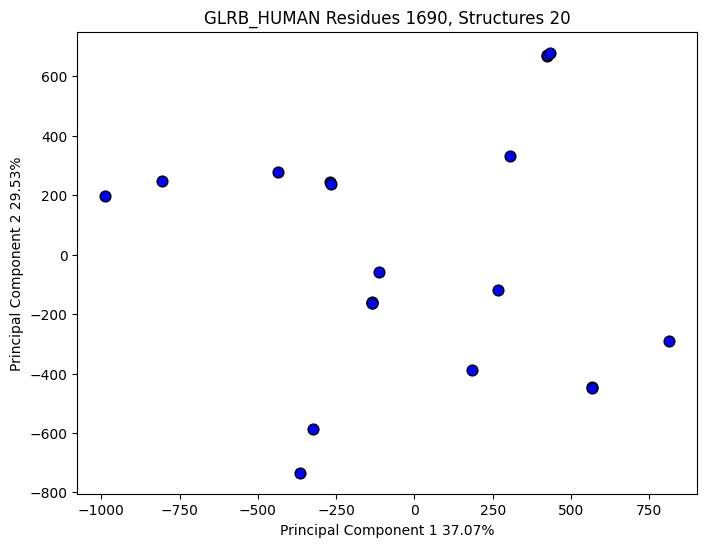

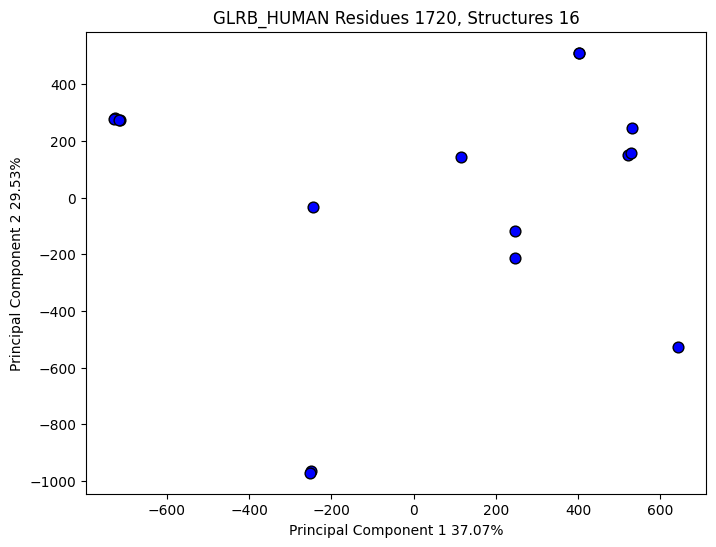

In [118]:
PCA_tool = PrincipalComponentAnalysis2(script_dir=script_dir, work_dir=new_work_dir,
                                      multiseq_dict=multiseq_dict, store_original=True)
#
PCA_tool.prepare_ensemble(USAligner.clustal_seqs_dict) # seems to work. but careful with non canonical residues. might be handled differently later.This version introduces an ALA instead.
PCA_tool.run_PCA()
PCA_tool.plot_pca_projections()


In [ ]:
for x, y in PCA_tool.pdb_all_ranges.items():
    for pdb, pcs in y.items():
        print(os.path.basename(pdb), pcs)

In [ ]:
raise AssertionError # block to prevent further auto execute

# Automated Clustering

In [ ]:
class AutoClusterClass:
    """Works but needs documentation."""
    def __init__(self, work_dir, pca_result_dict, logging=True, clusters="auto"):

        self.work_dir = work_dir
        self.pca_result_dict = pca_result_dict
        self.logging = logging
        self.num_clusters = clusters
        self.cluster_results = {} 

    def run_clustering(self, automated=True, OPTICS=False, optics_min_samples=None):
        if self.pca_result_dict:
            #then lets go and convert this to a np.array

            # we cluster for each range and result.
            for ranges, inner_dict in self.pca_result_dict.items():
                labels = np.array(list(inner_dict.keys())) # which we need later for identification of pdbs
                labels = [os.path.basename(x)[:-4] for x in labels] #shorten it to pdb_code
                X = np.array(list(inner_dict.values())) #pc1 and pc2 as tuples 

                if automated:
                    optimal_clust_num = self._obtain_optimal_clusters(X)
                    kmeans = KMeans(n_clusters=optimal_clust_num, random_state=7)    
                    clust_labels = kmeans.fit_predict(X)
                    
                    self.cluster_results[ranges] = (labels, clust_labels, X)

                if OPTICS:
                    if optics_min_samples:
                        optics = OPTICS(min_samples=optics_min_samples) # think how to do that properly
                        optics.fit(X)
                        clust_labels = optics.labels_
                        self.cluster_results[ranges] = (labels, clust_labels, X) #pdb codes , the predicted class , the PC1 PC2 array for plotting.
            
            return self.cluster_results
    
    def plot_clusters(self, num_labels_to_show=None):
        if self.cluster_results:
            for ranges, lbl_clust_X in self.cluster_results.items():
                labels, clust_labels, X = lbl_clust_X  #unpack the tuple

                plt.figure(figsize=(10,8))
                plt.scatter(X[:, 0], X[:, 1], c=clust_labels, cmap='viridis', label='Clusters')
                plt.title('Clustering')
                plt.xlabel('PC1')
                plt.ylabel('PC2')

                if num_labels_to_show:
                    for i, label in enumerate(labels):
                        if i % num_labels_to_show == 0:
                            plt.annotate(label, (X[i, 0], X[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
                
                plt.legend()
                prot_name = os.path.basename(self.work_dir)
                save_path = os.path.join(self.work_dir, f"{prot_name}_cluster_results.pdf")
                plt.savefig(save_path)
                plt.show()


    def _obtain_optimal_clusters(self, X, visualize=False):
        
        #more than 8 conformers are unrealistic
        cluster_range = range(2, 8)
        best_num_clusters = 0
        best_silhouette_score = -1
        elbow_scores = []
        silhouette_scores = []
        for n_clusters in cluster_range:
            kmeans = KMeans(n_clusters=n_clusters, random_state=7)
            cluster_labels = kmeans.fit_predict(X)
            elbow_scores.append(kmeans.inertia_) # the lower the bett
            #silhouette score
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette_scores.append(silhouette_avg)
            #if silhouette is better:
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_num_clusters = n_clusters
        
        if visualize:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
            # Elbow plot on the first subplot
            ax1.plot(cluster_range, elbow_scores, 'bo-')
            ax1.set_title('Elbow Method For Optimal Number of Clusters')
            ax1.set_xlabel('Number of Clusters')
            ax1.set_ylabel('Inertia')
            
            # Silhouette scores plot on the second subplot
            ax2.plot(cluster_range, silhouette_scores, 'bo-')
            ax2.set_title('Silhouette Score For Optimal Number of Clusters')
            ax2.set_xlabel('Number of Clusters')
            ax2.set_ylabel('Silhouette Score')
            
            # Display the subplots
            plt.tight_layout()  # Adjust subplots to fit into figure area.
            plt.show()

        return best_num_clusters
                
                



In [ ]:
pca_results = PCA_tool.pdb_all_ranges

ACC = AutoClusterClass(work_dir=new_work_dir, pca_result_dict=pca_results)

ACC.run_clustering()
ACC.plot_clusters()

# NMA and Hinge class

In [ ]:
class NormalModeAnalysis2:
    def __init__(self, work_dir, script_dir, atomistic_models, cluster_results=None,
                 gamma = 1,
                 dr = 8,
                 power = 0,
                 modes=10,
                 logging=True):
        
        self.work_dir = work_dir
        self.script_dir = script_dir
        self.gamma = float(gamma)
        self.dr = float(dr)
        self.power = float(power)
        self.hessian_matrices = {}
        self.coord_dict = {}
        self.eigenvalues = {}
        self.eigenvectors = {}
        self.modes = modes
        self.masses = {}
        self.hessian_weighted_matrices = {}
        
    def extract_ca_coordinates_and_masses(self, pdb):
        #helper function to parse a pdb file and  

        lst =  [('VAL',99), ('ILE',113), ('LEU',113), ('GLU',129), ('GLN',128),
                        ('ASP',115), ('ASN',114), ('HIS',137), ('TRP',186), ('PHE',147), ('TYR',163), 
                        ('ARG',156), ('LYS',128), ('SER',87), ('THR',101), ('MET',131), ('ALA',71), 
                        ('GLY',57), ('PRO',97), ('CYS',103)]
        
        aa_dict = defaultdict(lambda: 100, lst) # 100 if non canonical

        
        parser = PDBParser()
        structure = parser.get_structure("protein", pdb)
        
        coords = []
        chain_lbl = []
        masses = []
        
        for model in structure:
            for chain in model:
                for residue in chain:
                    for atom in residue:
                        if atom.get_name() == "CA":
                            atom_coords = atom.get_coord()
                            coords.append(atom_coords) # coord
                            chain_lbl.append(chain.get_id()) # chain
                            res = residue.get_resname()
                            
                            res_weight = np.float64(aa_dict[res]) #* self.mass_conv_u_to_kg # convert to kg from Dalton/Unit

                            masses.append(res_weight) # mass_in_kg

        
        self.coord_dict[pdb] = (np.array(coords), chain_lbl)
        self.masses[pdb] = masses
        
    def construct_hessian(self, pdb_code):
        
        if self.coord_dict[pdb_code]:
            coords, _ = self.coord_dict[pdb_code]

        print(coords.shape)
        n_atoms = len(coords)
        print(n_atoms)
        hessian = np.zeros((n_atoms*3, n_atoms*3), float)
        distance_mat = np.ones((n_atoms*3, n_atoms*3), float)

        #cutoff
        edENM_cutoff = int(2.9*np.log(n_atoms) - 2.9) # as in Lauras and Domenicos code.
        
        if edENM_cutoff >= 20:
            edENM_cutoff = 20
            
        if edENM_cutoff <= 8:
            edENM_cutoff = 8

        edENM_seq_exp = 2 # so we treat neighbours different in sequence.

        edENM_cart_exp = 6 
        edENM_seq_force_constant = 60
        edENM_cart_force_constant = 6
        edENM_M = 3
        
        for i in range(len(coords)):
            diff = coords[i+1:, :] - coords[i] # diff between x y z of entry n and entry n-1
            squared_diff = diff**2 # squared diff for each x y and z
            #print(f"{i=}")
            # diff = diff between current x y z and  all other x y z later in sequence. 
            
            for j, s_ij in enumerate(squared_diff.sum(1)): # col wise summation  # squared euclidian distance  
                #print(f"{j=}")
                # 0 0 , 0, 1 0, 2 etc.
                if j != i:
                    if np.abs(j - i) <= edENM_M: # which means they are neighbours within 3 res apart in seq.
                        gamma = edENM_seq_force_constant/(j-i)**edENM_seq_exp # then we will use this spring constant.
                    else:
                        if np.sqrt(s_ij) <= edENM_cutoff:
                            gamma = (edENM_cart_force_constant/np.sqrt(s_ij))**edENM_cart_exp 
                        else:
                            gamma = 1 # is this proper? setting it to 0? or 1 ?
                else:
                    gamma = 1
                    
                if s_ij <= edENM_cutoff**2:  # squared because he does the squared diff not the diff. if its below the cutoff both intra as well as extra chain.
                    
                    diff_coords = diff[j]
                    j = j + i + 1
                    derivative = np.outer(diff_coords, diff_coords)*(float(-gamma)/np.sqrt(s_ij)**(2+self.power))  # delta coords * -gamma/dist**0 in our case  in the paper its -gamma * delta diff  / dist**2
                    hessian[i*3:i*3+3, j*3:j*3+3] = derivative
                    hessian[j*3:j*3+3, i*3:i*3+3] = derivative #symmetry
                    hessian[i*3:i*3+3, i*3:i*3+3] = hessian[i*3:i*3+3, i*3:i*3+3] - derivative
                    hessian[j*3:j*3+3, j*3:j*3+3] = hessian[j*3:j*3+3, j*3:j*3+3] - derivative
                    d = np.sqrt(s_ij)
                    lobj = [[d,d,d],[d,d,d],[d,d,d]]
                    dmat = np.array(lobj)
                    distance_mat[i*3:i*3+3, j*3:j*3+3] = dmat

        hessian = np.divide(hessian, distance_mat)
        self.hessian_matrices[pdb_code] = hessian
        with open("/home/micnag/bioinformatics/domenico_nma/test_new_hessian.txt", "w") as fh_out:
            np.savetxt(fh_out, hessian, fmt='%7.4f')
        
    

    def add_masses_to_hessian(self, pdb_code):

        if self.hessian_matrices[pdb_code].size > 0: # not empty
            H = self.hessian_matrices[pdb_code]
            masses = self.masses[pdb_code] # masses per residue.
            N_x3 = H.shape[0] # is symmetrical and 3x num_atoms


        MWH = np.zeros_like(H, dtype=np.float64)
        mass_res_expanded = np.repeat(masses, 3) # same mass for x, y , z
        for i in range(N_x3):
            for j in range(N_x3):
                MWH[i, j] = H[i,j] / np.sqrt(mass_res_expanded[i//3] * mass_res_expanded[j//3])
                
            
        self.hessian_weighted_matrices[pdb_code] = MWH
    
    def solve_eigenproblem(self, pdb_code, weighted=False):
        # given that H is symmetrical, we can leverage eigh from numpy.linalg.

        #check symmetry
        if not self.hessian_matrices[pdb_code].size > 0:
            print("Hessian matrix is needed")
            return
    
        # Symmetrize the Hessian matrix
        if weighted:
            if self.hessian_weighted_matrices[pdb_code].size > 0:
                hessian = self.hessian_weighted_matrices[pdb_code]
        else:
            hessian = self.hessian_matrices[pdb_code]
        
        #print(f"{hessian=}")
        #with open("/home/micnag/bioinformatics/domenico_nma/test_weighted_hessian.txt", "w") as fh_out:
        #    np.savetxt(fh_out, hessian, fmt='%7.4f')
        
        #hessian_sym = (hessian + hessian.T) / 2
    
        # Solve the eigenproblem
        eigenvalues, eigenvectors = np.linalg.eigh(hessian)

        num_non_interesting_modes = 6  # Assuming the first 6 modes are not interesting
        eigenvalues = eigenvalues[num_non_interesting_modes:num_non_interesting_modes+self.modes]
        eigenvectors = eigenvectors[:, num_non_interesting_modes:num_non_interesting_modes+self.modes]
    
        # Store the results
        self.eigenvalues[pdb_code] = eigenvalues
        self.eigenvectors[pdb_code] = eigenvectors
        # now lets apply mass weighting as well

        

In [ ]:
work_dir ="/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/AT2A1_HUMAN"
script_dir = work_dir
path_to_pdb = "/home/micnag/bioinformatics/domenico_nma/original_6wod_A.pdb"

NMA = NormalModeAnalysis2(work_dir=work_dir, script_dir=script_dir, atomistic_models=path_to_pdb)

NMA.extract_ca_coordinates_and_masses(path_to_pdb)
NMA.construct_hessian(path_to_pdb)
#NMA.add_masses_to_hessian(path_to_pdb)

#print(NMA.eigenvectors[path_to_pdb][0:10,0])

#NMA.masses[path_to_pdb]
#NMA.masses
#NMA.coord_dict
#NMA.construct_hessian(path_to_pdb)
NMA.solve_eigenproblem(path_to_pdb)
#print(NMA.eigenvalues[path_to_pdb].shape)
#print(NMA.eigenvectors[path_to_pdb].shape)
#print(NMA.eigenvectors[path_to_pdb])

#first_set = np.round(NMA.eigenvectors[path_to_pdb][:,0], 4)

#with open("/home/micnag/bioinformatics/domenico_nma/test_pipeline_evecs.txt", "w") as fh_out:
#    np.savetxt(fh_out, NMA.eigenvectors[path_to_pdb], fmt='%7.4f')

In [ ]:
first_col = []
with open("/home/micnag/bioinformatics/domenico_nma/original_6wod_A_A_evecs.txt", "r") as fh_in:
    for line in fh_in:
        values = line.split()
        first_col_val = np.float(values[0])
        first_col.append(first_col_val)

first_col_arr = np.array(first_col)

#works, now lets check correlation
corr_mat = np.corrcoef(first_set, first_col_arr)
corr_coeff = corr_mat[0,1]
print("Correlation Coefficient between array1 and array2:", corr_coeff)

#print(first_set)
#print(first_col_arr)

# OLD Modeller Class

In [ ]:
class ModellerRepairEnsemble:
    '''
    Modeller Class that can be used to repair structures if needed.
    Returned structures should be compatible with format for downstream analysis.
    '''
    def __init__(self, work_dir, ensemble_dict):

        self.repair_ensemble = ensemble_dict
        self.work_dir = work_dir
        self.monomers = None
        self.oligomers = None
        self.monomeric_templates= None
        self.oligomeric_templates = None
        self.usalign_exe = os.path.join(work_dir, "USalign")
        self.repairable_structures = None
        self.repaired_monomers = None
        self.repaired_oligomers = None

    
    def _separate_oligostates(self):

        lst = [("1",'monomer'),("2", 'dimer'),("3", 'trimer'),("4", 'tetramer'),("5", 'pentamer'),
           ("6", 'hexamer'),("7", 'heptamer'),("8", 'oktamer'),("9", 'nonamer'),("10", 'decamer'),
           ("11", 'undecamer'),("12", 'dodecamer'),("13", 'tridecamer'),
           ("14", 'tetradecamer'),("15", 'pentadecamer'),("16", 'hexadecamer'),
           ("17", 'heptadecamer'),("18", 'oktadecamer'),("19", 'nonadecamer'),("20", 'eicosamer'),
           ("21", 'eicosameundamer'),("22", 'eicosadodamer'),("23", 'eicosatrimer'),("24", 'eicosatetramer')]

        oligodirdict = defaultdict(lambda: "X-mer", lst)

        
        oligos = defaultdict(dict)
        monos = defaultdict(dict)
        for ranges, dicts in self.repair_ensemble.items():
            for key, value in dicts.items():
                if key == 1:
                    monos[ranges][oligodirdict[str(key)]] = value
                else:
                    oligos[ranges][oligodirdict[str(key)]] = value

        self.monomers, self.oligomers = monos, oligos

    def _shuffle(self, dict_to_shuffle):


        lst = [("1",'monomer'),("2", 'dimer'),("3", 'trimer'),("4", 'tetramer'),("5", 'pentamer'),
           ("6", 'hexamer'),("7", 'heptamer'),("8", 'oktamer'),("9", 'nonamer'),("10", 'decamer'),
           ("11", 'undecamer'),("12", 'dodecamer'),("13", 'tridecamer'),
           ("14", 'tetradecamer'),("15", 'pentadecamer'),("16", 'hexadecamer'),
           ("17", 'heptadecamer'),("18", 'oktadecamer'),("19", 'nonadecamer'),("20", 'eicosamer'),
           ("21", 'eicosameundamer'),("22", 'eicosadodamer'),("23", 'eicosatrimer'),("24", 'eicosatetramer')]

        oligodirdict = defaultdict(lambda: "X-mer", lst)


        
        dirs_to_check = []
        
        for keys, vals in dict_to_shuffle.items():
            print(keys)
            keys = keys.split(",") #CONVERT tuple to a string.
            start, stop = keys[0][1:], keys[1][:-1]
            print(start)
            print(stop)
            new_range_obj = start+"-"+stop
            dir_path = os.path.join(work_dir, new_range_obj)
            if not os.path.exists(dir_path):
                #get rid of whitespace which makes issues later downstream
                os.mkdir(dir_path)
                
            for oligo, path_tm_rmsd in vals.items():
                print(oligo)
                oligo_path = os.path.join(work_dir, new_range_obj, oligodirdict[str(oligo)])
                if not os.path.exists(oligo_path):
                    os.mkdir(oligo_path)
                dirs_to_check.append(oligo_path) #this is a list that contains the locations of all directories that will be visited during repair.
                for path, _, _ in path_tm_rmsd:
                    shutil.copy(path, oligo_path) #new location
        
        return dirs_to_check

    
    def repair_structures(self):
        # first the monomeric case.
        self._separate_oligostates()
        
        # run now repairs on both.
        if self.monomers:
            #we need a separate environment for modeller etc.
            self.monomer_dirs = self._shuffle(self.monomers)
            oligo_dir_dict = defaultdict()
            if self.monomer_dirs:
                for directory in self.monomer_dirs:
                    #check which pdbs need repair.
                    pdb_to_check = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".pdb")] 
                    #first get the gap ranges
                    with ProcessPoolExecutor() as executor:
                        gap_list = list(executor.map(self._gap_localization_1, pdb_to_check))
                    #each gaplist member is a tuple of (path, list of gaps)
                    # keys: templates:   inner keys: the targets inner vals: their seqid and their TM score. which we will now filter and take the top X target to repair our structure.
                    
                    #print(f"{gap_list=}")
                    
                    suitable_templates = self._get_templates_for_monomeric_multitemplate_modelling(gap_list)

                    #print(f"{suitable_templates=}")
                    # now lets go through each and every of them an check if there are gaps.
                    
                    potential_template_dict = self._check_repairability(suitable_templates, gap_list)

                    #print(f"{potential_template_dict=}")
                    
                    #next step is repair. if empty we skip. else we go through all repairable structures.
                    if potential_template_dict:
                        with ProcessPoolExecutor() as executor:
                            key, value = zip(*potential_template_dict.items()) #unpack first 
                            try:
                                print("we try intelligent_monomeric_repair. ")
                                results = list(executor.map(self._intelligent_monomeric_repair, key, value))
                            except Exception as e:
                                results = []
                                print(e)
                        oligo_dir_dict[directory] = results
                        
                    else:
                        print(f"We have no repaired structures for directory: {directory}")
                        oligo_dir_dict[directory] = []
                        
            #this is a dict of paths for each oligostate and range as a instance of the class saved.
            self.repaired_monomers =  oligo_dir_dict


        
        
        
        if self.oligomers:
            #we need a separate environment for modeller etc.
            self.oligomer_dirs = self._shuffle(self.oligomers)

            oligo_dir_dict = defaultdict()
            if self.oligomer_dirs:
                for directory in self.oligomer_dirs:
                    #check which pdbs need repair.
                    pdb_to_check = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".pdb")] 


                    """Lets implement this later. First we just take all structures as they are and continue."""
                    oligo_dir_dict[directory] = pdb_to_check

                    
                    #first get the gap ranges
                    with ProcessPoolExecutor() as executor:
                        gap_list = list(executor.map(self._gap_localization_1_oligomeric, pdb_to_check))
        

                    suitable_templates = self._get_templates_for_oligo_multitemplate_modelling(template_path=template_path,
                                                                    potential_templates=template_backup_list,
                                                                    gap_dict=gap_dict)


            self.repaired_oligos = oligo_dir_dict


    def _check_repairability(self, template_dict: dict, gap_list: list, min_seq_id: float = 0.6) -> dict:
        """
        Checks each structure's eligibility for repair based on gap alignment and minimum sequence identity.
    
        Args:
        - template_dict (dict): A dictionary where keys are template paths and values are dicts containing template details.
        - gap_list (list): A list of tuples representing the paths and gaps in the structure to be repaired (path, [(start, stop), ...]).
        - min_seq_id (float): The minimum sequence identity required for a template to be considered suitable.
    
        Returns:
        - dict: A dictionary of potential templates that can be used for repair.
        """
        
        potential_template_dict = defaultdict(list)
        for (temp_path, temp_gaps) in gap_list:
            for template_path, details in template_dict.items():
                # Assume details structure is a dict with keys as some identifiers and values as tuples of details
                for key, val in details.items():
                    try:
                        # Attempt to unpack expecting 3 elements; adjust according to your data structure
                        tm_score, seq_id, template_gaps = val[0][0], val[0][1], val[1]
                    except ValueError:
                        # Handle cases where unpacking fails due to unexpected structure
                        print(f"Skipping {key} due to unpacking error: expected 3 values, got {len(val)}")
                        continue
                        
                    #print(seq_id, min_seq_id)
                    if float(seq_id) > min_seq_id and not self._has_large_gap_overlap(temp_gaps, template_gaps):
                        #print(seq_id, min_seq_id)
                        #print(temp_path, template_path)
                        potential_template_dict[(temp_path, temp_gaps)].append((template_path, (tm_score, seq_id, template_gaps)))
        
        return potential_template_dict

    def _has_large_gap_overlap(self, gaps1: list, gaps2: list) -> bool:
        """
        Determines if there is a large overlap in gaps between two structures.
    
        Args:
        - gaps1 (list): The gaps in the first structure as a list of tuples (start, stop).
        - gaps2 (list): The gaps in the second structure as a list of tuples (start, stop).
    
        Returns:
        - bool: True if there is a large overlap, False otherwise.
        """
        for start1, end1 in gaps1:
            for start2, end2 in gaps2:
                if start1 <= end2 and start2 <= end1:  # Check if gaps overlap
                    return True  # Overlapping gaps found
        return False  # No overlapping gaps




    
    def _gap_localization_1(self, pdb_path: str):
        """Helper function to compute the start and stops of gaps 
        for later potential reconstruction."""
    
        gap_ranges = []
        parser = PDBParser(QUIET=True)
        test_structure = parser.get_structure("test", pdb_path)
        
        test_res = test_structure.get_residues()
        start = end = None
    
        for res in test_res:
            res_id = int(res.get_id()[1])
            if end is None:
                start = end = res_id
            elif res_id == end + 1:
                end = res_id
            else:
                if start != end:
                    gap_ranges.append((start, end))
                start = end = res_id
    
        if start is not None and start != end:
            gap_ranges.append((start, end))

        if not gap_ranges:
            return (pdb_path, [])  # Return an empty list if there are no gaps

        # Convert the list of gap ranges to a list of gap tuples
        gap_tuples = [(start, end) for start, end in gap_ranges]
        merged_gaps = [(1, gap_tuples[0][0])] + [(gap_tuples[i][1], gap_tuples[i + 1][0]) for i in range(len(gap_tuples) - 1)]
        return (pdb_path, merged_gaps)


    

    def _get_templates_for_monomeric_multitemplate_modelling(self, pdb_gap_list):
        parser = PDBParser()
        suitable_templates = {}

        for template_index, (template_path, tmp_gap) in enumerate(pdb_gap_list):
            template_results = {}

            for target_index, (target_path, gaps) in enumerate(pdb_gap_list):
                if target_index != template_index:  # Avoid self-comparison
                    score = self._align(target_path, template_path)
                    template_results[target_path] = (score, gaps)

            suitable_templates[template_path] = template_results

        #print(suitable_templates)
        # outer keys: templates, inner keys: target_structures. inner values: (seq_id, tm., gaps) 
        return suitable_templates
    
    
    def _gap_localization_1_oligomeric(self,pdb_path: str):
        """Helper function to compute the start and stops of gaps for later potential reconstruction."""
        
        full_gaps_dict = defaultdict()
        gap_dict = defaultdict(list)
        parser = PDBParser(QUIET=True)
        test_structure = parser.get_structure("test", pdb_path)
        
        for model in test_structure:
            for chain in model:
                for residues in chain:
                    resnum = residues.get_id()
                    gap_dict[chain.id].append(resnum[1])
    
        #now we have all chains and all sequence nums from start to finish
        chain_to_query = []
    
        for chains, residues in gap_dict.items():
            chain_to_query.append(chains)
            
            start = end = None
            gap_ranges = []
            for res in residues:
                if end is None:
                    start = end = res
                elif res == end + 1:
                    end = res
                else:
                    if start != end:
                        gap_ranges.append((start, end))
                    start = end = res
    
            if start is not None and start != end:
                gap_ranges.append((start, end))
    
            gap_tuples = [(start, end) for start, end in gap_ranges]
            merged_gaps = [(1, gap_tuples[0][0])] + [(gap_tuples[i][1], gap_tuples[i + 1][0]) for i in range(len(gap_tuples) - 1)]
            full_gaps_dict[chains] = merged_gaps
        
        return full_gaps_dict, chain_to_query



    

    def _align(self, target_path, template_path):
        
        # Implement the logic to align the target_path with the template_path
        # focusing on the region defined by 'gap', and return a scoring metric
        bash_tm_and_rmsd_calc = f"{self.usalign_exe} {target_path} {template_path} -TMscore 0 -outfmt 1"
        bash_command = bash_tm_and_rmsd_calc.split()
        
        result_scores_for_templates = defaultdict()
        
        try:
            result = run(bash_command, stdout=PIPE, stderr=PIPE, universal_newlines=True)
    
            #print(result.stdout)
            result_list = self._get_aligned_fastas(result.stdout)  # gap list not used here... can be removed in future version.

            #print(result_list)
            return result_list
            
        except Exception as e:
            
            print(e)
            return {}
            


    def _get_aligned_fastas(self, result):

        lines = result.strip().split('\n')
        #this is gap_list : [(1, 3), (263, 276), (396, 407)]
        #print("this is gap_list :", gap_list)
        result_list = []
        #print(lines)
        # Initialize an empty dictionary
        template_header = lines[2].split("\t")
        #template_full_seq = lines[3]  #replace - to get the full seq.
        template_seq_id = float(template_header[3].split("=")[-1])
        template_tm_score = float(template_header[4].split("=")[-1])
        template_pdb_path = template_header[0].replace(">","")
        template_pdb_path = template_pdb_path.split(":")[0]
    
        potential_template_header = lines[0].split("\t")
        #potential_template_full_seq = lines[1]
        potential_template_seq_id = float(potential_template_header[3].split("=")[-1])
        potential_template_tm_score = float(potential_template_header[4].split("=")[-1])
        potential_template_pdb_path = potential_template_header[0].replace(">","")
        potential_template_pdb_path = potential_template_pdb_path.split(":")[0]
        #print(template_seq_id, template_tm_score)
        #print(potential_template_seq_id, potential_template_tm_score)
        #result_dict[potential_template_pdb_path] = (potential_template_seq_id, potential_template_tm_score, potential_template_full_seq)
        #result_dict[template_pdb_path] = (template_seq_id, template_tm_score, template_full_seq)
        return template_seq_id, template_tm_score
    
    def _score_meets_criteria(self, score):
        # Implement the logic to check if the score meets your criteria
        # for a suitable template
        pass


    


    def _intelligent_oligomeric_repair(self, path_to_pdb:str, gap_list:list, selected_templates:list,chains_query:list):
    
        """
        Function repairs structures with gaps less than 8 residues per gap.
    
        Args:
        - path_to_pdb (str): Path to the folder containing PDB files.
        - stop_pos (int): Stop position.
        - main_prot_seq (str): Main protein sequence.
        - use_main (bool): Whether to use the main protein.
    
        Output:
        Repaired structures.
        """
    
        #new_template_path='/home/micnag/test_modeller_oligomer/6hyr/6hyr.pdb'
        #,gap_list_all_chains=[[(1, 5), (96, 116)], [(1, 5)], [(1, 5)], [(1, 5)], [(1, 5)]], 
        #repair_templates_non_redundant={'/home/micnag/test_modeller_oligomer/6hz3_A.pdb'}







        
        print("inside oligomeric_repair")
        log.none()  # no stdout spam
        env = Environ()  # setup env for modelling
        aln = Alignment(env)  # setup the alignment
        mdl = Model(env)  # setup the model
    
        #path : /home/micnag/bioinformatics/.../monomer/pos/2duk_A.pdb
        # current working directory
        pdb_id_target = os.path.basename(path_to_pdb) #results in 2duk_A.pdb
    
        #pdb_id_target='6hyr.pdb'
        #print(f"{pdb_id_target=}")
        
        pdb_id_chain = chains_query #this corresponds to all chains in oligomeric struc. We shall also pass this
        #to our automodell derived child class.
    
        #we need first and last chain to set boundaries for our model 
        first_chain, last_chain = pdb_id_chain[0], pdb_id_chain[-1]
        
        #pdb_code_name is passed to modeller later.
        pdb_code_name = pdb_id_target[:-4] #2duk_ABCDEF
        
        pdb_4_digit_id = pdb_id_target[0:4] #2duk
    
        #print(f"{pdb_4_digit_id=}")
        
        #get uniprot_id second. HERE CHECK HOW WE GET X UNIPROT IDS FOR X PROTEINS IN A HETERO_OLIGOMER
        uniprot_id = return_uniprot_id_from_rcsb(pdb_4_digit_id)
    
        #print(f"{uniprot_id=}")
        #get associated fasta from uniprot id.
        fasta_seq = get_gene_fasta(uniprot_id)
    
        #print(f"{fasta_seq=}")
    
        #first_chain='A', last_chain='E', pdb_4_digit_id='6hyr', pdb_code_name='6hyr',uniprot_id='Q7NDN8', pdb_id_chain=['A', 'B', 'C', 'D', 'E']
        #print(f"{first_chain=}, {last_chain=}, {pdb_4_digit_id=}, {pdb_code_name=},{uniprot_id=}, {pdb_id_chain=}, {fasta_seq=}")
        """HERE WE NEED TO CHECK HOW TO MERGE OUR FASTAS.. ESPECIALLY CRUCIAL IF WE HAVE A MIXED OLIGOMER.
        SUBSEQUENT CHAINS NEEDS TO BE SEPARATED BY / """
        
        #if mixed oligomer this needs to be taken into account. 
        """WE NEED TO CHECK THIS IN THE FUTURE... ADAPT GET_GENE_FASTA for multiple seqs in hetero X mers."""
        
        merged_fasta = '/'.join([fasta_seq] * len(pdb_id_chain))
        
        #first we check what is the first ID in our struc. because otherwise we can miss structures that simply miss 
        #N terminus e.g gap 1-21 but they in fact start with residue 21 and are otherwise good or might just have small
        # gaps to fix otherwhere in the structure.
    
        start_stop_dict = defaultdict()
    
        temp_codes = []
        temp_abs_paths = []
        temp_chains = []
    
    
    
        #print(f"{merged_fasta=}")
    
        for structure in set(selected_templates):  #no duplicates here.
            #print(f"Structure: {structure} selected as template")
            
            temp_codes.append(structure.split("/")[-1][:-4]) #extract codes for all strucs. this works for oligomers.
            
            temp_abs_paths.append(structure) #grab abspath
            
            temp_chains.append(structure.split("/")[-1][5:-4]) #this are the chains we need.
    
    
        #print(f"{temp_codes=}, {temp_abs_paths=}, {temp_chains}")
    
        for temp_code, temp_paths, chains in zip(temp_codes, temp_abs_paths, temp_chains):
            if len(temp_code) <= 6:
                #append all start stop and shifts here.
                start_struc_temp, stop_struc_temp = get_struc_stop_oligomer(temp_paths)  #this works also for oligomers in theory. But it is questionable.. if chain A is 100 res and chain B is 40.
                #how should we give this info to modeller... 1:A until B:40 problably. include 
                
                start_stop_dict[temp_code] = ((start_struc_temp, stop_struc_temp, chains))
    
        start_struc_query, stop_struc_query = get_struc_stop_oligomer(path_to_pdb) 
        
        start_stop_dict[pdb_code_name] = ((start_struc_query, stop_struc_query, pdb_id_chain))
    
    
        #print(f"{start_stop_dict=}")
        
        #now the dict contains all paths and start stops.
        
        #this is the only shift we care about!
    
        #careful here.. shifts need to be taken into account FOR EACH CHAIN!
        
        shift = abs(1-start_struc_query)  #e.g 1- 8 abs means 7 shift.
        
        #if we find that the first end of gap corresponds to the start resi number of the pdb... we skip this gap.
    
        #would be better to check if one of the templates might cover this gap. But currently not implemented.
    
        #print(f"{shift=}")
    
    
        #gap_list=[((96, 116), 'A')]
        #print(f"{gap_list=}")
    
        """
    
        gap_list_all_chains=[[(1, 5), (96, 116)], [(1, 5)], [(1, 5)], [(1, 5)], [(1, 5)]]
        we enter oligomeric repair with: new_template_path='/home/micnag/test_modeller_oligomer/6hyr/6hyr.pdb',repairable_gaps=[((96, 116), 'A')], repair_templates_non_redundant={'/home/micnag/test_modeller_oligomer/6hz3_A.pdb'}
        inside oligomeric_repair
        Structure: /home/micnag/test_modeller_oligomer/6hz3_A.pdb selected as template
        temp_codes=['6hz3_A'], temp_abs_paths=['/home/micnag/test_modeller_oligomer/6hz3_A.pdb'], ['A']
        start_stop_dict=defaultdict(None, {'6hz3_A': (5, 315, 'A'), '6hyr': (5, 315, ['A', 'B', 'C', 'D', 'E'])})
        shift=4
        """
        
    
        
        """CONTINUE HERE AFTER COURSE TO PROCEED WITH HETEROMERIC OLIGOMER REPAIRS.  NOV 17 2023  18:33 """
        
    
        for gaps, chains in gap_list:
            #print(gaps, chains)
            
            found_N_terminus = False
            found_C_terminus = False
    
            #can only concatenate str (not "int") to str#
    
            #    n_terminus = [x for x in range(gap_list[0][0], gap_list[0][1]+1)] #including the last residue.
            #    c_terminus = [x for x in range(gap_list[-1][0], gap_list[-1][1]+1)] #including the last residue.
        
            #(96, 116) A
    
            if len(gaps) > 2: #means we have more than 1 gap. each gap = len 2
                n_terminus = [x for x in range(gaps[0][0], gaps[0][1]+1)] #including the last residue.
                c_terminus = [x for x in range(gaps[-1][0], gaps[-1][1]+1)] #including the last residue.
            else:
                n_terminus = None
                c_terminus = None
                #we dont deal with n or c terminus here if we only have 1 gap.
    
            #print(f"this is {n_terminus=}")
            #print(f"this is {c_terminus=}")
    
            max_n_terminus_found = None
            max_c_terminus_found = None
    
            #print(f"works until here inside intelligent oligomeric repair!!")
    
    
    
            for paths, (start, stop, chain) in start_stop_dict.items():
                # paths='6hz3_A',start=5, stop=315, chain='A'
                # paths='6hyr',start=5, stop=315, chain=['A', 'B', 'C', 'D', 'E']
                
                #print(f"{paths=},{start=}, {stop=}, {chain=}")
                #lets check for the n-terminus if we find something that can be repaired.
                
                if n_terminus:
                    if start < n_terminus[-1]:
                    
                        #then we set n terminus found because there is something to repair
                        found_N_terminus = True
                    
                        #but if we have no template... we cant repair beyond what we have and we stay with start.
                        if max_n_terminus_found == None or start < max_n_terminus_found:
                            max_n_terminus_found = start
                            
                #lets check for the c terminus in the same fashion
                if c_terminus: 
                    if stop > c_terminus[0]:
                    
                        #that means we have something that goes beyond the max available struc len.
                        found_C_terminus = True
                    
                        #but if we have no template, we still cant repair beyond.
                        if max_c_terminus_found == None or stop > max_c_terminus_found:
                            max_c_terminus_found = stop
                    
    
    
            #now lets check outside the loop
    
            if found_N_terminus == False and len(gaps) != 2: #means its not our only hit.
    
                if len(gaps) > 2:
    
                    gap_list = gaps[1:] #skip first tuple because we cant repair N terminus
                    
                else:
                    
                    print(f"We could not repair the only gap because we have no template. this is {gap_list=}")         
                    return
            
            if found_C_terminus == False and len(gaps) != 2:
                #this means we have no suitable template and we skip it.
                
                if len(gap_list) > 2:
                    
                    gap_list = gap_list[:-1]
                    
                else:
                    
                    print(f"We could not repair the only gap because we have no template. this is {gap_list=}")
                    return
    
            
            #lets grab the max range of gaps in our structure.
            if len(gaps) != 2:
                max_gap_range = sorted([y - x for x, y in gaps], reverse=True)
            else:
                max_gap_range = [gaps[1] - gaps[0]] #simple 1 gap, list for downstream compatibility
    
    
            if len(selected_templates) == 0 and max_gap_range[0] > 8:  
                #this last part checks for the case we have
                #no templates found but only small gaps of lenght < 8 and still want to repair.
                print("no suitable templates found.")
                return
    
        #print("we went through this chaos.")
    
        """Modeller aln.salign treats the FIRST structure provided as QUERY. so we need to load this one FIRST."""
        #code to be passed to mdl.read
    
        #start struc query is already above computed at the beginning so we re use it again here.
        #CONTINUE HERE
    
        """model_segment specifies the range we look into. Ideally we look for start - stop based on majority vote. Chain is always the same in monomeric"""
        mdl.read(file=pdb_code_name, model_segment=(f"{start_struc_query}:{pdb_id_chain[0]}", f"{stop_struc_query}:{pdb_id_chain[-1]}"))
    
        #pdb_code_name='6hyr',start_struc_query=5,pdb_id_chain[0]='A',stop_struc_query=315,pdb_id_chain[-1]='E'
        #print(f"{pdb_code_name=},{start_struc_query=},{pdb_id_chain[0]=},{stop_struc_query=},{pdb_id_chain[-1]=}")
        #append model object to alignment object.
    
        aln.append_model(mdl, align_codes=pdb_code_name, atom_files=pdb_code_name)
    
         
        for codes, (start_temp, stop_temp, chains) in start_stop_dict.items():
            #dont add our query again to the stack.
            if codes == pdb_code_name:
                continue
    
            #rest of templates...add to the stack.
            mdl.read(file=codes, model_segment=(f"{start_temp}:{chains[0]}", f"{stop_temp}:{chains[-1]}"))
            
            aln.append_model(mdl, align_codes=codes, atom_files=codes)
    
    
        #now add fasta sequence as last entry to the align model.
        with open(f"./{pdb_code_name}x.fasta", "w") as fastaout:
            fastaout.write(f">{pdb_code_name}x\n")
            fastaout.write(merged_fasta)
    
        aln_code = f"{pdb_code_name}x"
    
        #align fasta file to our alignment object which contains now a fasta sequence and a structure object.
        aln.append(file=f"./{pdb_code_name}x.fasta", align_codes=aln_code, alignment_format="fasta")
    
    
    
    
        #Overwrite MyModel and Inherit from AutoModel.
        class MyModel(AutoModel):
            def __init__(self, env, alnfile, knowns, sequence, gaps, chains, shift, **kwargs):
                super(MyModel, self).__init__(env, alnfile, knowns, sequence, **kwargs)
                self.gaps = gaps
                self.chain = chains
                self.shift = shift #shift because modeller always renumbers all stuff to be 1 based.
                
            def select_atoms(self):
                selections = []
                chain = self.chain
                #this needs to be adjusted for multi chain modells.
                #this is self.gaps: [((96, 116), 'A')]
                #print(f"this is self.gaps: {self.gaps}")
                for (start, end), chain in self.gaps:
                    if start > 1:
                        
                        #print(f"Selecting atoms for range {start-self.shift}:{chain} to {end-self.shift}:{chain}")
                        selection = self.residue_range(f'{start-self.shift}:{chain}', f'{end-self.shift}:{chain}')
                        selections.append(selection)
                        
                    else:
                        #print(f"Selecting atoms for range {start}:{chain} to {end-self.shift}:{chain}")
                        selection = self.residue_range(f'{start}:{chain}', f'{end-self.shift}:{chain}')
                        selections.append(selection)
    
                selected_atoms = Selection(*selections)
                
                # Combine all selections into a single Selection object
                print(f"Selected {len(selected_atoms)} atoms for optimization")
                
                return selected_atoms
    
    
        #setup environment dir for MODELLER. ACCEPTED current dir and previous dir.
        env.io.atom_files_directory = ['.','../.']
        
        #aln.malign3d(fit=True)
    
    
        # Additional debugging: Print alignment content
        #print("Alignment content before salign:")
        #for record in aln:
            #print(record.code)
    
        #align sequence to structure.
    
        #overhang = 0 because we are confident the structures as templates are suitable candidates (seq id > 0.8)
        # gap penalties are default.
        # alignment_type = progressive : each template pairwise against query comparison.
        # 
    
        
        aln.salign(overhang=0, gap_penalties_1d=(-450, -50), alignment_type="progressive", output="ALIGNMENT")
    
        #write out alignmentfile for automodell usage later
        aln.write(file=f"{pdb_code_name}.ali")
        
        #add template codes to the code list.
        alternate_templates = [x for x in temp_codes]
    
        # merge with our codes.
        full_knowns = (pdb_code_name, *alternate_templates) #empty list from alternate_templates
        
        #print(f"{full_knowns=}")
        #custom class
    
        # selected atoms do not feel the neighborhood
        #env.edat.nonbonded_sel_atoms = 2
    
        #here we need to rechain again and make sure that this is what modeller sees.. e.g BCD Will need to be ABC
    
        pdb_original = None #this is considered false by default == 1 == False
    
        letters = [chr(ord('A') + i) for i in range(26)]
        
        
        if pdb_id_chain != letters[0:len(pdb_id_chain)]:  # ABC for len 3 e.g
            #print(f"we are inside pdb_id_chain not fitting with modeller. : {pdb_id_chain=}")
            pdb_original = list(pdb_id_chain)
            #we set it to A for repair.. but afterwards we swap it back!
            pdb_id_chain = letters[0:len(pdb_id_chain)]
    
        #print(f"{pdb_id_chain=}")
    
        #print("works until here.")
    
        a = MyModel(env, alnfile=f"{pdb_code_name}.ali", knowns=full_knowns, sequence=aln_code,
                    gaps=gap_list, shift=shift, chains=pdb_id_chain)
    
    
        #print(f"ALIGN_CODES(1) = {a.alignment_codes[0]}")
        #a = AutoModel(env, alnfile=f"{pdb_code_name}.ali", knowns=full_knowns, sequence=aln_code)
    
        a.starting_model = 1
        a.ending_model = 1
    
        # Thorough MD optimization:
        #a.md_level = refine.slow
    
        # Repeat the whole cycle 2 times and do not stop unless obj.func. > 1E6
        #a.repeat_optimization = 2
    
        #env.libs.topology.make(aln)
        #env.libs.parameters.read(file='$(LIB)/par.lib')
        #mdl.generate_topology(aln[pdb_code_name])
        #a.generate_topology(aln[pdb_code_name])
        # Assign the average of the equivalent template coordinates to MODEL:
        #a.transfer_xyz(aln) #lets try this.
        
        # Get the remaining undefined coordinates from internal coordinates:
        #a.build(initialize_xyz=True, build_method='INTERNAL_COORDINATES')
    
        try:
            # Build the model(s)
            a.make();
            
        except Exception as e:
            print(f"An error occurred during modeling: {e}")
    
        #this worked.. now we need to clean all files that are no longer required
    
    
        try:
            #remove artifacts.
            #remove_repair_artefacts(pdb_basep=path_to_pdb, pdb_code_name=pdb_code_name)
    
            #ok now we need to check what the updated start stop range is!
    
            if max_n_terminus_found and max_n_terminus_found < start_struc_query:
                
                keep_start = max_n_terminus_found
                if not max_c_terminus_found:
                    keep_stop = stop_struc_query
                
                    
            if max_c_terminus_found and max_c_terminus_found > stop_struc_query:
                keep_stop = max_n_terminus_found
    
                if not max_n_terminus_found:
                    keep_start = start_struc_query
                    
            if not max_n_terminus_found and not max_c_terminus_found:
                keep_start, keep_stop = start_struc_query, stop_struc_query
            
    
            #here we can switch chain back to original if required:
    
            
            #print(f"{keep_start=}, {keep_stop=}")
            
            #this should select only from the start to end and excludes potentially repaired N and C termini that would only introduce more noise.
            select_c_alpha_and_correct_range(path_to_pdb, start=keep_start, stop=keep_stop)
    
            
            
            #not required!
            #renumber_structure_monomeric(path_to_pdb, start=start_struc, chain=pdb_id_chain)
            
        except Exception as e:
            print(e)

        return



    


    def _intelligent_monomeric_repair(self, repair_struc_gap_lst, temp_paths_tm_score_seq_id_template_gaps):
    
        """
        Function repairs structures with gaps less than 7 residues per gap.
    
        Args:
        - template_dict: key = (pdb to be repaired, temp_gaps), vals = (path_for_template_structure,  (tm_score, seq_id, template_gaps)) 

        We need to make sure that the selection of residues used for repair does not fall into the region of template_gaps.

        
        Attention:
    
        Modeller INTERNALLY RECHAINS AND RENUMBERS EVERY QUERY.
        ALL SINGLE CHAINS == A chain. irrespective of natural chain.. e.g if you supply chain B single chain it will go back to rechaining it to chain A.
        Also dangerous... it will renumber structures from 1... so you need to correct for this shift based on your desired selection target. 
        If you structure starts with residue 30... and you want to remodell a gap between 40-50 you need to take this into account. shift = abs(1-start_struc_query)
        
        Output:
        Repaired structures.
        """
        
        print(repair_struc_gap_lst)
        print(temp_paths_tm_score_seq_id_template_gaps)

        #lets unpack everything properly.

        pdb_id_target_path = repair_struc_gap_lst[0] #the path
        pdb_id_target_gaps = repair_struc_gap_lst[1] #the list of gaps to be checked

        template_paths = temp_paths_tm_score_seq_id_template_gaps[0] #the path to the templates
        template_gaps = temp_paths_tm_score_seq_id_template_gaps[1][2] # the list of gaps in the templates


        if len(pdb_id_target_gaps) == 0:
            #means we have nothing to add.
            return pdb_id_target_path 
        
        log.none()  # no stdout spam
        env = Environ()  # setup env for modelling
        aln = Alignment(env)  # setup the alignment
        mdl = Model(env)  # setup the model
        #path : /home/micnag/bioinformatics/.../monomer/pos/2duk_A.pdb
        # current working directory
        #print("works until here step 1:")
        pdb_id_target = os.path.basename(pdb_id_target_path) #results in 2duk_A.pdb
        pdb_id_chain = pdb_id_target[-5] #this corresponds to chain in single monomeric struc. We shall also pass this
        #to our automodell derived child class.
        #pdb_code_name is passed to modeller later.
        pdb_code_name = pdb_id_target[:6] #2duk_A
        pdb_4_digit_id = pdb_id_target[0:4]
        #print(f"this is {pdb_4_digit_id=}, {pdb_id_chain=}, {pdb_code_name=}")
        #print("works until here step 2:")
        #get uniprot_id second.
        uniprot_id = self._return_uniprot_id_from_rcsb(pdb_4_digit_id)
        #get associated fasta from uniprot id.
        fasta_seq = self._get_gene_fasta(uniprot_id)
    
        #first we check what is the first ID in our struc. because otherwise we can miss structures that simply miss 
        #N terminus e.g gap 1-21 but they in fact start with residue 21 and are otherwise good or might just have small
        # gaps to fix otherwhere in the structure.
    

        start_stop_dict = self._setup_and_prep_templates(template_paths)
        start_struc_query, stop_struc_query = self._get_struc_stop(pdb_id_target_path) 

        #leave this as this adds the QUERY to the start_stop_dic
        start_stop_dict[pdb_code_name] = ((start_struc_query, stop_struc_query, pdb_id_chain))

        
        #now the dict contains all paths and start stops.
        #this is the only shift we care about!
        shift = abs(1-start_struc_query)  #e.g 1- 8 abs means 7 shift.
        
        #if we find that the first end of gap corresponds to the start resi number of the pdb... we skip this gap.
        #would be better to check if one of the templates might cover this gap. But currently not implemented.
        #[(275, 284), (882, 889)]
        #print(f"this is {gap_list=}")
        
        found_N_terminus, found_C_terminus, pdb_id_target_gaps = self._check_terminus_coverage(pdb_id_target_gaps, start_stop_dict)
            
        #print(f"gaplist after cutting: {gap_list=}")
        
        #lets grab the max range of gaps in our structure.
        #max_gap_range = sorted([y - x for x, y in pdb_id_target_gaps], reverse=True)
    
        #check if we found suitable templates... IF NO and there are still only small gaps < 8 then we use the structure itself as template and still repair.
        #if len(selected_templates) == 0 and max_gap_range[0] > 8:  
            #this last part checks for the case we have
            #no templates found but only small gaps of lenght < 8 and still want to repair.
            #print("no suitable templates found.")
        #    return
            
        #elif len(selected_templates) == 0 and max_gap_range[0] < 8:
            #nothing to do since we always append our own structure to repair ensemble. But in this case we can continue.
            #print("we found gaps but they are small so we shall continue")
        #    pass
        
    
        """Modeller aln.salign treats the FIRST structure provided as QUERY. so we need to load this one FIRST."""
        #code to be passed to mdl.read
    
        #start struc query is already above computed at the beginning so we re use it again here.
        #CONTINUE HERE
    
        """model_segment specifies the range we look into. Ideally we look for start - stop based on majority vote. Chain is always the same in monomeric"""
        mdl.read(file=pdb_code_name, model_segment=(f"{start_struc_query}:{pdb_id_chain}", f"{stop_struc_query}:{pdb_id_chain}"))
        #append model object to alignment object.
        aln.append_model(mdl, align_codes=pdb_code_name, atom_files=pdb_code_name)
    
        #now lets add all the templates.
        #now we need to append all template strucs.
        
        for codes, (start_temp, stop_temp, chains) in start_stop_dict.items():
            #dont add our query again to the stack.
            if codes == pdb_code_name:
                continue
    
            #rest of templates...add to the stack.
            #print(f"{start_temp}:{chains}", f"{stop_temp}:{chains}")
            mdl.read(file=codes, model_segment=(f"{start_temp}:{chains}", f"{stop_temp}:{chains}"))  
            aln.append_model(mdl, align_codes=codes, atom_files=codes)
    
        #now add fasta sequence as last entry to the align model.
        with open(f"./{pdb_code_name}x.fasta", "w") as fastaout:
            fastaout.write(f">{pdb_code_name}x\n")
            fastaout.write(fasta_seq)
    
        aln_code = f"{pdb_code_name}x"
        #align fasta file to our alignment object which contains now a fasta sequence and a structure object.
        aln.append(file=f"./{pdb_code_name}x.fasta", align_codes=aln_code, alignment_format="fasta")
        
        class MyModel(AutoModel):
            def __init__(self, env, alnfile, knowns, sequence, gaps, chain, shift, **kwargs):
                super(MyModel, self).__init__(env, alnfile, knowns, sequence, **kwargs)
                self.gaps = gaps
                self.chain = chain
                self.shift = shift #shift because modeller always renumbers all stuff to be 1 based.
                
            def select_atoms(self):
                selections = []
                chain = self.chain
    
                #print(f"this is self.gaps: {self.gaps}")
                for start, end in self.gaps:
                    if start > 1:  #negative indx make problems so we start from 1 in this cases.
                        #print(f"Selecting atoms for range {start-self.shift}:{chain} to {end-self.shift}:{chain}")
                        selection = self.residue_range(f'{start-self.shift}:{chain}', f'{end-self.shift}:{chain}')
                        selections.append(selection)
                    else:
                        #print(f"Selecting atoms for range {start}:{chain} to {end-self.shift}:{chain}")
                        selection = self.residue_range(f'{start}:{chain}', f'{end-self.shift}:{chain}')
                        selections.append(selection)
                
                selected_atoms = Selection(*selections)
                # Combine all selections into a single Selection object
                #print(f"Selected {len(selected_atoms)} atoms for optimization")
                return selected_atoms
    
    
        #setup environment dir for MODELLER. ACCEPTED current dir and previous dir.
        env.io.atom_files_directory = [f'{self.work_dir}', f'../.']

        #aln.malign3d(fit=True)
        # Additional debugging: Print alignment content
        #print("Alignment content before salign:")
        #for record in aln:
            #print(record.code)
        #align sequence to structure.
        #overhang = 0 because we are confident the structures as templates are suitable candidates (seq id > 0.8)
        # gap penalties are default.
        # alignment_type = progressive : each template pairwise against query comparison.
        #    
        aln.salign(overhang=0, gap_penalties_1d=(-450, -50), alignment_type="progressive", output="ALIGNMENT")
        #write out alignmentfile for automodell usage later
        aln.write(file=f"{pdb_code_name}.ali")
        #add template codes to the code list.
        alternate_templates = [x for x in temp_codes]
        # merge with our codes.
        full_knowns = (pdb_code_name, *alternate_templates) #empty list from alternate_templates
        #print(full_knowns)
        #custom class
        # selected atoms do not feel the neighborhood
        #env.edat.nonbonded_sel_atoms = 2
        #check chain if not A... take A and afterwards change it back to original chain. 
        pdb_original = None #this is considered false by default == 1 == False
        if pdb_id_chain != "A":
            #print(f"we are inside pdb_id_chain != A: {pdb_id_chain=}")
            pdb_original = list(pdb_id_chain)
            #we set it to A for repair.. but afterwards we swap it back!
            pdb_id_chain = "A"
    
        a = MyModel(env, alnfile=f"{pdb_code_name}.ali", knowns=full_knowns, sequence=aln_code,
                    gaps=pdb_id_target_gaps, shift=shift, chain=pdb_id_chain) #pdb_id_chain
     

        #print(f"ALIGN_CODES(1) = {a.alignment_codes[0]}")
        #a = AutoModel(env, alnfile=f"{pdb_code_name}.ali", knowns=full_knowns, sequence=aln_code)
    
        a.starting_model = 1
        a.ending_model = 1
    
        # Thorough MD optimization:
        #a.md_level = refine.slow
    
        # Repeat the whole cycle 2 times and do not stop unless obj.func. > 1E6
        #a.repeat_optimization = 2
    
        #env.libs.topology.make(aln)
        #env.libs.parameters.read(file='$(LIB)/par.lib')
        #mdl.generate_topology(aln[pdb_code_name])
        #a.generate_topology(aln[pdb_code_name])
        # Assign the average of the equivalent template coordinates to MODEL:
        #a.transfer_xyz(aln) #lets try this.
        
        # Get the remaining undefined coordinates from internal coordinates:
        #a.build(initialize_xyz=True, build_method='INTERNAL_COORDINATES')
        
        try:
            # Build the model(s)
            a.make();
            
        except Exception as e:
            print(f"An error occurred during modeling: {e}")
    
        #this worked.. now we need to clean all files that are no longer required
    
    
        try:
            #remove artifacts.
            self._remove_repair_artefacts(pdb_basep=pdb_id_target_path, pdb_code_name=pdb_code_name)
    
            #ok now we need to check what the updated start stop range is!
    
            #print(f"{max_n_terminus_found=}, {max_n_terminus_found < start_struc_query=}")
            
            #print(f"{max_c_terminus_found=}, {max_c_terminus_found > start_struc_query=}")
    
            #print(f"{start_struc_query=}")
            #print(f"{stop_struc_query=}")
            
            """
            max_n_terminus_found=-2, max_n_terminus_found < start_struc_query=True
            max_c_terminus_found=994, max_c_terminus_found > start_struc_query=True
            start_struc_query=1
            stop_struc_query=992
            keep_start=-2, keep_stop=-2
            """
    
            if pdb_original:
                #print(f"this is inside pdb_original {pdb_id_chain=}")
                #rechain back and set pdb_id_chain to original pdb chain.
                pdb_id_chain = self._rechain_back(path_to_pdb=pdb_id_target_path, pdb_original=pdb_original)
                
            #should take both chains and pdb path.. then rechain back and return back the new chain.
    
    
            keep_start = start_struc_query
            keep_stop = stop_struc_query
            
            if max_n_terminus_found and max_n_terminus_found < start_struc_query:
                keep_start = max_n_terminus_found
                    
            if max_c_terminus_found and max_c_terminus_found > stop_struc_query:
                keep_stop = max_c_terminus_found
            
            #print(f"{keep_start=}, {keep_stop=}")
            #this should select only from the start to end and excludes potentially repaired N and C termini that would only introduce more noise.
            self._select_correct_range(pdb_id_target_path, start=keep_start, stop=keep_stop)
    
    
            monomeric_chain = "".join(pdb_id_chain)
            #print(f"{monomeric_chain=}")
            #not required! ?? lets see later if it is .
            self._renumber_structure_monomeric(pdb_id_target_path, start=keep_start, chain=pdb_id_chain)
            
        except Exception as e:
            print(e)

        #if everyhing worked out we return the path!
        return pdb_id_target_path





    

    def _return_uniprot_id_from_rcsb(self, uniprot_id:str):
    
        link_path = "https://www.ebi.ac.uk/pdbe/api/mappings/uniprot"
        
        searchp = f"{link_path}/{uniprot_id}"
        #print(searchp)
        resp = get_url(searchp)
        resp = resp.json()
        
        for pdb_id, pdb_info in resp.items():
            for uniprot_id, uniprot_info in pdb_info['UniProt'].items():
                return uniprot_id


    def _get_gene_fasta(self, uniprot_id:str):
    
        #print("we are in get gene fasta")
        "this is already overworked. should work."
        #uniprot_canonical_isoform = get_uniprot_id(uniprot_id=uniprot_id)
        
        fields = "sequence"
        
        URL = f"https://rest.uniprot.org/uniprotkb/search?format=fasta&fields={fields}&query={uniprot_id}"
        resp = get_url(URL)
        resp = resp.iter_lines(decode_unicode=True)
        
        seq = ""
        
        i = 0
        for lines in resp:
            if i > 0:
                seq += lines
                #print(lines)
            i += 1
        
        #print(seq)
        return seq



    def _setup_and_prep_templates(self, template_paths)->dict:

        #print("works until here step 3:")
        start_stop_dict = defaultdict()
    
        temp_codes = []
        temp_abs_paths = []
        temp_chains = []
        
        for structure in set(template_paths):  #no duplicates here.
            #print(f"Structure: {structure} selected as template")
            temp_codes.append(structure.split("/")[-1][:-4])
            temp_abs_paths.append(structure)
            temp_chains.append(structure.split("/")[-1][-5]) #this is the chain we need.
    
        for temp_code, temp_paths, chains in zip(temp_codes, temp_abs_paths, temp_chains):
            if len(temp_code) <= 6:
                #append all start stop and shifts here.
                start_struc_temp, stop_struc_temp = get_struc_stop(temp_paths)
                start_stop_dict[temp_code] = ((start_struc_temp, stop_struc_temp, chains))
    
        return start_stop_dict

    
    def _get_struc_stop(self, path_to_pdb):
    
        parser = PDBParser()
        structure = parser.get_structure("none", path_to_pdb)
        seq_ids = [x.get_id()[1] for x in structure.get_residues()]
        seq_ids = sorted(seq_ids)
        return seq_ids[0], seq_ids[-1] #this corresponds to the last residue.


    def _remove_repair_artefacts(self, pdb_basep, pdb_code_name):
    
        pattern = f"{pdb_code_name}"
        #print(pattern)
        # Remove original_****_*.ali file
        ali_files = glob.glob(f"{pattern}.ali")
        for file in ali_files:
            os.remove(file)
        # Remove original_****_A.pdb
        old_pdb_file = f"{pattern}.pdb"
        if os.path.exists(old_pdb_file):
            os.remove(old_pdb_file)
            
        # Rename original_****_Ax.B99990001.pdb to original_****_A.pdb
        repaired_pdb_file = f"{pattern}x.B99990001.pdb"
        if os.path.exists(repaired_pdb_file):
            new_pdb_file = repaired_pdb_file.replace('x.B99990001', '')
            shutil.move(repaired_pdb_file, new_pdb_file)
    
        # Remove original_****_*x.D00000001
        d_files = glob.glob(f"{pattern}x.D00000001")
        for file in d_files:
            os.remove(file)
    
        # Remove other files
        extensions_to_remove = ['.fasta', '.ini', '.rsr', '.sch', '.V99990001']
        for ext in extensions_to_remove:
            files = glob.glob(f"{pattern}x{ext}")
            for file in files:
                os.remove(file)
                

    def _check_terminus_coverage(self, pdb_id_target_gaps, start_stop_dict):
        """
        Checks if the N-terminus and C-terminus gaps in the target structure can be covered by any of the templates.
    
        Args:
        - pdb_id_target_gaps: A list of tuples representing the gaps in the target structure.
        - start_stop_dict: A dictionary with template start and stop residue numbers and chains.
    
        Returns:
        - A tuple of booleans indicating whether suitable templates for the N-terminus and C-terminus were found.
        - Updated pdb_id_target_gaps after excluding uncovered terminus gaps.
        """
        found_N_terminus = False
        found_C_terminus = False
    
        n_terminus_range = range(pdb_id_target_gaps[0][0], pdb_id_target_gaps[0][1] + 1)
        c_terminus_range = range(pdb_id_target_gaps[-1][0], pdb_id_target_gaps[-1][1] + 1)
    
        max_n_terminus_found = None
        max_c_terminus_found = None
    
        for _, (start, stop, _) in start_stop_dict.items():
            if int(start) < n_terminus_range[-1]:
                found_N_terminus = True
                max_n_terminus_found = max(max_n_terminus_found, start) if max_n_terminus_found is not None else start
    
            if int(stop) > c_terminus_range[0]:
                found_C_terminus = True
                max_c_terminus_found = max(max_c_terminus_found, stop) if max_c_terminus_found is not None else stop
    
        # Adjust the gaps list based on the terminus coverage
        if not found_N_terminus and len(pdb_id_target_gaps) > 1:
            pdb_id_target_gaps = pdb_id_target_gaps[1:]
        elif not found_N_terminus:
            return False, False, []
    
        if not found_C_terminus and len(pdb_id_target_gaps) > 1:
            pdb_id_target_gaps = pdb_id_target_gaps[:-1]
        elif not found_C_terminus:
            return False, False, []
    
        return found_N_terminus, found_C_terminus, pdb_id_target_gaps


    def _rechain_back(self, path_to_pdb:str, pdb_original:list)-> None:

        #first check if its multichain or single chain.
        new_chains = "".join(pdb_original)
        parser = PDBParser()
        structure = parser.get_structure("default", path_to_pdb)

        for model in structure:
            for idx, chain in enumerate(model):
                if chain.id != new_chains[idx]:
                    chain.id = new_chains[idx]
    
        io = PDBIO()
        io.set_structure(structure)
        io.save(path_to_pdb)
        return pdb_original




    def _select_correct_range(self, path:str, start:int, stop:int):
    
        #sel only c_alpha
        class CAlphaOnlyInCorrectRange(Select):
            def __init__(self, start, stop, *args):
                super().__init__(*args)
                self.start = start
                self.stop = stop

            #overloaded to only accept positive residue numbering.
            def accept_residue(self, residue):      
                return 1 if residue.id[1] >= self.start and residue.id[1] <= self.stop else 0    
            
        #filelst    path
        #5ltu_A.pdb /home/micnag/bioinformatics/rcsb_retrieved_pdbs/rcsb_fetched_structures/NUD4B_HUMAN
        
        parser = PDBParser(QUIET=True)
        prot_name = f"default"
        
        #print("we are here")
        #print(fullpath)
        structure = parser.get_structure(prot_name, path)
        
        # Select C-alpha atoms and save the modified structure
        io = PDBIO()
        io.set_structure(structure)
        io.save(path, CAlphaOnlyInCorrectRange(start=start, stop=stop))



    def _renumber_structure_monomeric(self, path_to_pdb:str, start:int, chain:str):

        shiftres_location = f"{self.work_dir}/pdb_shiftres_by_chain.py"
        bash_cmd = f"python {shiftres_location} {path_to_pdb} {start-1} {chain}"
        bash_cmd_rdy = bash_cmd.split()
        
        with open(f"{path_to_pdb}_tmp", "w") as fh_tmp:
            result = run(bash_cmd_rdy, stdout=fh_tmp, stderr=PIPE, 
                 universal_newlines=True)
        
        #now replace the original one with the temp file.
        os.replace(f"{path_to_pdb}_tmp", f"{path_to_pdb}")

In [ ]:
#PdbEnsemble_meta = Downloader.meta_dict
#PdbEnsemble_chains_seq_id = Downloader.chain_seqid_dict

#Downloader.conservation(uniprot_id="Q9NZJ9")
#shifts = PdbEnsemble.parallel_shift_calculation()
#Downloader.conservation_df

In [ ]:
PDB_Cleaner = PDBCleaning(work_dir=work_dir, meta_dict=PdbEnsemble_meta, chain_seq_dict=PdbEnsemble_chains_seq_id)
PDB_Cleaner.setup_cutoff(cutoff=3, apply_filter=True)  #apply filter to only include structures that are of good quality
#PDB_Cleaner.parallel_shift_calculation()  # compute shift for each structure
#PDB_Cleaner.parallel_renumbering()  # renumber based on shifts.
#PDB_cleaned_ensemble.chain_dict

#PDB_Cleaner.filtered_structures
struct = PDB_Cleaner.filtered_structures
#struct = PDB_Cleaner.get_unfiltered_strucs()
#chain_seqid = PDB_Cleaner.chain_seq_dict

In [ ]:
print(struct) #get_unfiltered_strucs() misses out on all files with multi chains
#['3i7v_A', '6woh_A', '6wog_A', '4hfq_AB', '6wob_A', '3h95_AB', '7aui_A', '6woe_A', '6pcl_A', '2q9p_A', '7aul_A', '6wod_A', '6wo8_A', '6woa_A', '6wo9_A', '6wof_A', '3i7u_ABCD', '6pck_A', '7aup_A', '7auk_A', '7aus_A', '7aut_A', '2fvv_A', '6wo7_A', '7nnj_A', '7tn4_A', '6woi_A', '7aun_A', '6woc_A', '3mcf_A', '7aur_A']

In [ ]:
#print(chain_seqid)

In [ ]:
#PDB_Builder = PDBBuilder(work_dir=work_dir, structures=struct, remove_intermediates=True) #structures that are filtered
#PDB_Builder.build_assembly()
#oligo_dict = PDB_Builder.oligodict

In [ ]:
#print(oligo_dict)

In [ ]:
#Preper = PDBEnsemblePrep(work_dir=work_dir, oligo_dict=oligo_dict, chain_seq_dict=chain_seqid, main_prot_seq=None)
#Preper.create_domain_boundaries()
#Preper.get_oligostates(num_most_common_oligostates=3)
#Preper.process_templates()
#top_templates = Preper.top_templates

In [ ]:
#USAligner = USAlign(work_dir=work_dir, structure_seqid_dict=Preper.templates_for_oligos, 
#                    template_min_identity=0.1,
#                   num_top_clusters_per_range=4)

#USAligner.USAlign_run()
#USAligner.filter_results(tm_cutoff=0.8,rmsd_min_cutoff=0.2, log_file=True)
#USAligner.setup_oligo_directories()
#result_dict = USAligner.result_dict
#USAligner.run_multiseq_alignment(directory="/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/monomer/1-203")

In [ ]:
#Repairstation = ModellerRepairEnsemble(ensemble_dict=result_dict, work_dir=work_dir)
#print(Repairstation.repair_ensemble)
#print(Repairstation.monomers)
#Repairstation.repair_structures()

In [ ]:
#script_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/scripts"

#work_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/monomer/1-203"

#fasta = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/monomer/1-203/multiseq_fasta.fa"

#pca_dir = "/home/micnag/bioinformatics/rcsb_retrieved_pdbs/Test_OOP_pipeline/pca_part"

#PCA_object = PrincipalComponentAnalysis(work_dir=work_dir, script_dir=script_dir, 
#                                        pca_dir=pca_dir,store_original=True)
#PCA_object.run_PCA(work_dir)
#PCA_object.prepare_ensemble()
#PCA_object.run_PCA()  # works but is crap because of forced path locations for executables.

In [ ]:
#PCA_object.multi_pdb_codes